# Проект Хакатон "Кинопоиск"


ФУНКЦИОНАЛЬНЫЕ ТРЕБОВАНИЯ:
1. Вывести наиболее эффективные и точные метрики для еженедельного/ежемесячного анализа работы  

2. Формирование списка KPI для дальнейшей работы и отслеживания заказчиком совместно с маркетологами.

**Артефакты для направления работы DA**

1. Вывести метрики эффективности поста, изучив:
- Типы публикаций  
- Темы постов  
- Объем текста  
- Отсутствие / наличие эмодзи
- Отсутствие / наличие изображений  
- Знаки препинания (сложность текста)  

2. Посчитать метрики эффективности каждого поста:

- Охват публикаций
- Вовлеченность аудитории

3. Провести семантический анализ комментариев к постам, чтобы понять, какие посты побуждают людей к целевым действиям  

4. Исследовать корреляцию характеристик и метрик постов с привлечением новых пользователей в канал Кинопоиска  

5. Сформировать краткий отчет по результатам поведенного анализа для маркетологов.

## Загрузка библиотек

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install emoji
!pip install pymorphy2
!pip install pyLDAvis==3.4.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 50.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=87823eeab182fb9662da0a86bd8d8bfc45dc7d23f85be6475d0c4f8b3c419e24
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.3 MB/s eta 0:00:00


In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta

import re
import requests
import json
import string
import pytz
import gdown
import zipfile
import ast
import emoji

# графики
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.subplots as sp
color = sns.color_palette()

# обработка текста
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger_ru')
from nltk import FreqDist, word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")

# моделирование
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
mystem = Mystem()

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.lda_model
pyLDAvis.lda_model.prepare
import pyLDAvis.gensim #LDA visualization library
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway
from scipy.stats import kruskal

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim import models

from sklearn.model_selection import train_test_split
from gensim.models.coherencemodel import CoherenceModel
from statsmodels.stats.multicomp import pairwise_tukeyhsd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


## Обзор данных и предобработка


Данные представлены следующими источниками:  
1. kinopoisk_channel_posts_2024-01-21.csv

**Сведения о постах в телеграм канале Кинопоиска:**

- Channel - неинформативная колонка - название канала

- Id - идентификатор поста Соответствует post_id в файле с комментариями к постам

- Date - дата и время публикации поста в формате CTE (+2 часа для получения
московского времени)

- Text - текст поста

- Views - количество просмотров поста

- Reactions - словарь с реакциями (эмоджи/смайлы) на пост Дает информацию о типе смайла и его количестве

- With media - дает представление о прикрепленном к посту документе Как правило MessageMediaPhoto - фото MessageMediaDocument - видео
MessageMediaWebPage - ссылка

- Forwarded - сколько раз пересылался пост

- Replies - словарь с количеством комментариев к посту

- Reactions_count - количество реакций/эмоджи на пост Столбец получен из столбца reactions путем суммирование количества всех реакций

- Comments - количество комментариев к посту Столбец получен на основе Replies

- Type attachement - вид прикрепленного к посту документа Получен из словаря в With media   

2. kinopisk_subscribers_detailed_2024-01-18.csv  
**Информация о подписчиках канала и отписках:**
- Date - дата
- Time - время
- Subscribers - количество подписавшихся
- Unsubscribed - количество отписок


3. kinopoisk_subscribers_general_2024_18_01.csv   
**Общая информация о подписчиках канала в разбивке по дням:**
- Date - дата
- Subscribers - суммарное количество подписок на эту дату
- Changes - разница в количестве подписчиков между текущей и предыдущей датами

### Posts

In [ ]:
# Ссылка на файл архива ZIP на Google Диске
url = 'https://drive.google.com/uc?export=download&id=1ZeMg2LFM-2zt-z-hcQmAMFGDCCsHNE2T'

# Имя файла архива
zip_file = 'kinopoisk_channel_posts_2023-01-21.zip'

# Имя файла CSV внутри архива
csv_file_inside_zip = 'kinopoisk_channel_posts_2023-01-21.csv'

# Загрузка файла архива ZIP
gdown.download(url, zip_file, quiet=False)

# Разархивация файла
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

# Загрузка данных из CSV файла в DataFrame
posts = pd.read_csv(csv_file_inside_zip, index_col=0).sort_index()

# Удаление временных файлов
import os
os.remove(zip_file)
os.remove(csv_file_inside_zip)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ZeMg2LFM-2zt-z-hcQmAMFGDCCsHNE2T
From (redirected): https://drive.google.com/uc?export=download&id=1ZeMg2LFM-2zt-z-hcQmAMFGDCCsHNE2T&confirm=t&uuid=597ef9fe-3261-45c4-b75f-9a55a7715f4a
To: /content/kinopoisk_channel_posts_2023-01-21.zip
100%|██████████| 29.9M/29.9M [00:00<00:00, 86.3MB/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Depr

In [ ]:
# напишем функцию для вывода первых и последних 5 строк + информации о датафрейме
def show_info(df):
    print('Информация о наборе данных:')
    df.info()
    print('---------------------')
    print('Выводим первые 5 строк')
    display(df.head())
    print('Выводим последние 5 строк')
    display(df.tail())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
show_info(posts)

Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23326 entries, 0 to 35656
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   channel          23326 non-null  object 
 1   id               23326 non-null  int64  
 2   date             23326 non-null  object 
 3   text             23326 non-null  object 
 4   views            23325 non-null  float64
 5   reactions        9507 non-null   object 
 6   with_media       22594 non-null  object 
 7   forwarded        23325 non-null  float64
 8   replies          12233 non-null  object 
 9   reactions_count  23326 non-null  int64  
 10  comments         23326 non-null  int64  
 11  type_attachment  22594 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 2.3+ MB
---------------------
Выводим первые 5 строк


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


channel     id                       date  \
0  https://t.me/kinopoisk  37125  2024-01-21 08:02:21+00:00   
4  https://t.me/kinopoisk  37121  2024-01-20 18:01:00+00:00   
5  https://t.me/kinopoisk  37120  2024-01-20 16:01:16+00:00   
6  https://t.me/kinopoisk  37119  2024-01-20 14:20:04+00:00   
7  https://t.me/kinopoisk  37118  2024-01-20 10:48:48+00:00   

                                                text    views  \
0  Какими подростками были актеры из «Трудных под...  12744.0   
4  Фильм дня — [**«Дневник Бриджит Джонс»**](http...  49486.0   
5  Кристоферу Нолану [вручат](https://www.hollywo...  53713.0   
6  Отгадайте фильм: в жизни грустной девочки появ...  55890.0   
7  Правда или фейк? 🧐\n\n#ДежурныйПоКинопоиску Се...  60348.0   

                                           reactions  \
0  {'_': 'MessageReactions', 'results': [{'_': 'R...   
4  {'_': 'MessageReactions', 'results': [{'_': 'R...   
5  {'_': 'MessageReactions', 'results': [{'_': 'R...   
6  {'_': 'MessageReactions', 'results': [{'_': 'R...   
7  {'_': 'MessageReactions', 'results': [{'_': 'R...   

                                          with_media  forwarded  \
0  {'_': 'MessageMediaWebPage', 'webpage': {'_': ...       12.0   
4  {'_': 'MessageMediaPhoto', 'spoiler': False, '...      161.0   
5  {'_': 'MessageMediaPhoto', 'spoiler': False, '...      136.0   
6  {'_': 'MessageMediaWebPage', 'webpage': {'_': ...      148.0   
7  {'_': 'MessageMediaDocument', 'nopremium': Fal...       27.0   

                                             replies  reactions_count  \
0  {'_': 'MessageReplies', 'replies': 5, 'replies...               57   
4  {'_': 'MessageReplies', 'replies': 85, 'replie...              896   
5  {'_': 'MessageReplies', 'replies': 68, 'replie...             1782   
6  {'_': 'MessageReplies', 'replies': 12, 'replie...              189   
7  {'_': 'MessageReplies', 'replies': 3, 'replies...              210   

   comments       type_attachment  
0         5   MessageMediaWebPage  
4        85     MessageMediaPhoto  
5        68     MessageMediaPhoto  
6        12   MessageMediaWebPage  
7         3  MessageMediaDocument

Выводим последние 5 строк


channel  id                       date  \
35651  https://t.me/kinopoisk  13  2016-12-21 10:02:22+00:00   
35653  https://t.me/kinopoisk  11  2016-12-21 08:40:33+00:00   
35654  https://t.me/kinopoisk  10  2016-12-21 08:35:05+00:00   
35655  https://t.me/kinopoisk   9  2016-12-20 08:18:29+00:00   
35656  https://t.me/kinopoisk   8  2016-12-19 16:24:41+00:00   

                                                    text   views  \
35651  Кстати, уже через три часа, в  16-00 по Москве...  5990.0   
35653  И, кстати, у нас есть первая тысяча подписчико...  5967.0   
35654  Первые счастливчики уже посмотрели новый эпизо...  6486.0   
35655  Каждый год кто-то ходит в баню, а мы выбираем ...  8188.0   
35656  Всем привет! Меня зовут Лиза Сурганова и я воз...  9078.0   

                                               reactions  \
35651  {'_': 'MessageReactions', 'results': [{'_': 'R...   
35653  {'_': 'MessageReactions', 'results': [{'_': 'R...   
35654  {'_': 'MessageReactions', 'results': [{'_': 'R...   
35655  {'_': 'MessageReactions', 'results': [{'_': 'R...   
35656  {'_': 'MessageReactions', 'results': [{'_': 'R...   

                                              with_media  forwarded replies  \
35651                                                NaN        0.0     NaN   
35653                                                NaN        0.0     NaN   
35654                                                NaN        4.0     NaN   
35655  {'_': 'MessageMediaWebPage', 'webpage': {'_': ...       11.0     NaN   
35656                                                NaN       16.0     NaN   

       reactions_count  comments      type_attachment  
35651                3         0                  NaN  
35653                7         0                  NaN  
35654                2         0                  NaN  
35655                6         0  MessageMediaWebPage  
35656               52         0                  NaN

In [ ]:
# назначим упорядоченные индексы
posts.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# проверим кол-во дубликатов в датафрейме posts
posts.duplicated(subset='id').sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0

Дубликаты в датафрейме posts не обнаружены.

In [ ]:
# удалим столбец channel, так он не информативен
posts.drop(posts.columns[0], axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# назначим упорядоченные индексы
posts.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# поменяем формат в колонке с датой на datetime
posts['date'] = pd.to_datetime(posts['date'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# определим часовой пояс (изначально было не cte, а utc, потому что +00:00)
moscow_tz = pytz.timezone('Europe/Moscow')
# преобразуем время во временную зону Москвы
posts['date'] = posts['date'].dt.tz_convert(moscow_tz)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# проверим типы колонок в датафрейме posts
posts['date'].dtype

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


datetime64[ns, Europe/Moscow]

In [ ]:
# удалим для удобства работы часовой пояс из колонки date
posts['date'] = posts['date'].dt.tz_localize(None)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# выделим и запишем в колонку date_YMD только дату и переведем в формат datetime
posts['date_YMD'] = posts['date'].dt.date
posts['date_YMD'] = posts['date_YMD'].astype('datetime64')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# проверим значения в date_YMD
posts['date_YMD'].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0   2024-01-21
1   2024-01-20
2   2024-01-20
3   2024-01-20
4   2024-01-20
Name: date_YMD, dtype: datetime64[ns]

In [ ]:
# проверим период, за который представлены данные в датафрейме posts
print(f"минимальная дата сбора данных: {pd.to_datetime(posts['date']).dt.date.min()}")
print(f"максимальная дата сбора данных: {pd.to_datetime(posts['date']).dt.date.max()}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


минимальная дата сбора данных: 2016-12-19
максимальная дата сбора данных: 2024-01-21


Данные о постах представлены с 2016 года. Анализ данных на таком большом периоде мало информативен, поэтому предлагаем выделить актуальный период исследования с 2023 года.

In [ ]:
# отберем для анализа данные с января 2023 года
posts = posts[posts['date'].astype(str) >= '2023-01-01']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# проверим кол-во постов
posts['id'].nunique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2695

In [ ]:
# проверим период исследования после выделения актуального периода
print(f"минимальная дата сбора данных: {pd.to_datetime(posts['date']).dt.date.min()}")
print(f"максимальная дата сбора данных: {pd.to_datetime(posts['date']).dt.date.max()}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


минимальная дата сбора данных: 2023-01-01
максимальная дата сбора данных: 2024-01-21


### Subscribers_g

In [ ]:
# загрузим данные о подписчиках и сохраним в переменную subscribers_g
url1 = 'https://drive.google.com/uc?export=download&id=1YCdsYkC90I4hj7d7MB4gtdabUiQJjXSC'

subscribers_g = pd.read_csv(url1, index_col=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [ ]:
# отобразим первые и последние 5 строк + информацию о датафрейме subscribers_g
show_info(subscribers_g)

Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 0 to 519
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         520 non-null    object
 1   subscribers  520 non-null    int64 
 2   changes      520 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 16.2+ KB
---------------------
Выводим первые 5 строк


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date  subscribers  changes
0  18.01.24       551378      415
1  17.01.24       550963     2061
2  16.01.24       548902     2043
3  15.01.24       546859     2539
4  14.01.24       544320     2021

Выводим последние 5 строк


date  subscribers  changes
515  21.08.22       206772      279
516  20.08.22       206493      330
517  19.08.22       206163      242
518  18.08.22       205921      116
519  17.08.22       205805       62

In [ ]:
# поменяем тип данных в колонке с датой
subscribers_g['date'] = pd.to_datetime(subscribers_g['date'], format='%d.%m.%y')
subscribers_g['date'] = subscribers_g['date'].dt.strftime('%Y-%m-%d')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
subscribers_g['date'] = pd.to_datetime(subscribers_g['date'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# отберем только данные о подписчиках начиная с 2023 года
subscribers_g = subscribers_g[subscribers_g['date'].astype(str) >= '2023-01-01']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# сохраним данные о подписчиках и постах за 2022 год в переменные subscribers_g_2022 и posts_2022
subscribers_g_2022 = subscribers_g[(subscribers_g['date'] >= '2022-01-01') & (subscribers_g['date'] <= '2022-12-31')] # чтобы был 2022 год
posts_2022 = posts[(posts['date'].astype(str) >= '2022-01-01') & (posts['date'].astype(str) <= '2022-12-31')]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# объединим данные о подписчиках и постах за 2022 год и сохраним в переменную merged_2022
merged_2022 = pd.merge(posts_2022, subscribers_g_2022, left_on='date_YMD', right_on='date', how='left')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# изменим тип данных в колонке с датой на datetime
subscribers_g['date'] = pd.to_datetime(subscribers_g['date']).dt.date
subscribers_g['date'] = subscribers_g['date'].astype('datetime64')
subscribers_g['date'].dtype

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dtype('<M8[ns]')

In [ ]:
# проверим значения в колонке date после изменений
subscribers_g['date'].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0   2024-01-18
1   2024-01-17
2   2024-01-16
3   2024-01-15
4   2024-01-14
Name: date, dtype: datetime64[ns]

In [ ]:
# проверим период исследования после выделения актуального периода
print(f"минимальная дата сбора данных: {subscribers_g['date'].dt.date.min()}")
print(f"максимальная дата сбора данных: {subscribers_g['date'].dt.date.max()}")

минимальная дата сбора данных: 2023-01-01
максимальная дата сбора данных: 2024-01-18


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Subscribers_detailed

In [ ]:
# https://drive.google.com/file/d/1hQG_Qeko05AFezYxgTs-55Dr136cwlj_/view?usp=drive_link

# загрузим дополнительные данные о подписчиках и сохраним в переменную subscribers
url2 = 'https://drive.google.com/uc?export=download&id=1hQG_Qeko05AFezYxgTs-55Dr136cwlj_'

subscribers = pd.read_csv(url2, index_col=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [ ]:
# отобразим первые и последние 5 строк + информацию о датафрейме subscribers
show_info(subscribers)

Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12282 entries, 0 to 12281
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          12282 non-null  object
 1   time          12282 non-null  object
 2   subscribers   12282 non-null  int64 
 3   unsubscribed  12282 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 479.8+ KB
---------------------
Выводим первые 5 строк


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date   time  subscribers  unsubscribed
0  Чт, 18 Jan  11:29          204          -300
1  Чт, 18 Jan  11:00          373          -366
2  Чт, 18 Jan  10:00          333          -150
3  Чт, 18 Jan  09:00          211          -133
4  Чт, 18 Jan  08:00          152           -90

Выводим последние 5 строк


date   time  subscribers  unsubscribed
12277  Ср, 17 Aug 2022  04:00            0            -1
12278  Ср, 17 Aug 2022  03:00            0             0
12279  Ср, 17 Aug 2022  02:00            0             0
12280  Ср, 17 Aug 2022  01:00           26             0
12281  Ср, 17 Aug 2022  00:00           23             0

In [ ]:
# проверим кол-во дубликатов в датафрейме subscribers
subscribers.duplicated().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0

Явные дубликаты в данных о подписчиках не обнаружены.

In [ ]:
# создадим словарь для преобразования русских названий дней недели в английские
rus_to_eng_days = {
    'Пн': 'Mon',
    'Вт': 'Tue',
    'Ср': 'Wed',
    'Чт': 'Thu',
    'Пт': 'Fri',
    'Сб': 'Sat',
    'Вс': 'Sun'
}

# напишем функцию для преобразования дат
def parse_date(date_str):
    # разделим строку на день недели и остальную часть
    day, rest = date_str.split(', ')
    # преобразуем русское название дня недели в английский
    day_eng = rus_to_eng_days[day]
    # соберем отформатированную строку обратно
    formatted_date_str = f"{day_eng}, {rest}"

    try:
        # попытка разбора строки
        parsed_date = datetime.strptime(formatted_date_str, '%a, %d %b %Y')
    except ValueError:
        # если возникает ошибка, добавляем год в конец строки и пробуем разобрать снова
        formatted_date_str += " 2024"
        parsed_date = datetime.strptime(formatted_date_str, '%a, %d %b %Y')

    return parsed_date

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# применим функцию к столбцу subscribers['date'] и запишем результат обратно
subscribers['date'] = subscribers['date'].apply(parse_date)
subscribers['date'].dtype

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dtype('<M8[ns]')

In [ ]:
subscribers['time'].unique()
# Заменим 11:29 на 11

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['11:29', '11:00', '10:00', '09:00', '08:00', '07:00', '06:00',
       '05:00', '04:00', '03:00', '02:00', '00:00', '23:00', '22:00',
       '21:00', '20:00', '19:00', '18:00', '17:00', '16:00', '15:00',
       '14:00', '12:00', '01:00', '13:00'], dtype=object)

In [ ]:
# проверим значения в колонке с датой после форматирования
subscribers['date'].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0   2024-01-18
1   2024-01-18
2   2024-01-18
3   2024-01-18
4   2024-01-18
Name: date, dtype: datetime64[ns]

In [ ]:
# выделим из колонки со временем значения часов и сохраним в отдельную колонку hour
subscribers['hour'] = pd.to_datetime(subscribers['time'], format='%H:%M').dt.hour

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# cгруппируем данные о подписчиках по дате и посчитаем сумму подписавшихся и отписавшихся
subscribers_group = subscribers.groupby('date').agg('sum').drop(columns='hour').reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# проверим полученные значения
subscribers_group.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


date  subscribers  unsubscribed
0 2022-08-17          124           -57
1 2022-08-18           92           -48
2 2022-08-19          221           -25
3 2022-08-20          373           -26
4 2022-08-21          135           -14

<font color='red'>КОМЕНТАРИЙ РЕВЬЮЕРА</font>
отписавиеся  - их бы я брала по модуля) кажется, у нас не может быть "отрицательных" землекопов)  

### Объединение датафреймов

In [ ]:
# объединим данные о постах и подписчиках и сохраним результат в merged_df
merged_df = pd.merge(posts, subscribers_g, left_on='date_YMD', right_on='date', how='inner')
merged_df = merged_df.sort_values(by='date_YMD')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<font color='red'>КОМЕНТАРИЙ РЕВЬЮЕРА</font>
проверили не потеряли ли посты при inner join?

In [ ]:
# добавим данные о кол-ве отписавшихся и подписавшихся
merged_df = pd.merge(merged_df, subscribers_group, left_on='date_YMD', right_on='date', how='left')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# проверим результат
merged_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id              date_x  \
0  31135 2023-01-01 09:15:26   
1  31151 2023-01-01 20:23:33   
2  31150 2023-01-01 20:00:12   
3  31136 2023-01-01 10:00:51   
4  31147 2023-01-01 14:55:33   

                                                text    views  \
0  Вышел первый [трейлер](https://youtu.be/PKBKma...  49611.0   
1  Дождались!\n\nНа Кинопоиске вышел «Гром: Трудн...  57794.0   
2  В широкий прокат вышел «Чебурашка» — вариация ...  57228.0   
3  Новый год — новые киновпечатления!🎄🎬\n\nУже се...  51746.0   
4  «Гром: Трудное детство» выходит на Кинопоиске ...  53993.0   

                                           reactions  \
0  {'_': 'MessageReactions', 'results': [{'_': 'R...   
1  {'_': 'MessageReactions', 'results': [{'_': 'R...   
2  {'_': 'MessageReactions', 'results': [{'_': 'R...   
3  {'_': 'MessageReactions', 'results': [{'_': 'R...   
4  {'_': 'MessageReactions', 'results': [{'_': 'R...   

                                          with_media  forwarded  \
0  {'_': 'MessageMediaWebPage', 'webpage': {'_': ...      101.0   
1  {'_': 'MessageMediaPhoto', 'spoiler': False, '...      231.0   
2  {'_': 'MessageMediaWebPage', 'webpage': {'_': ...       66.0   
3  {'_': 'MessageMediaPhoto', 'spoiler': False, '...       92.0   
4  {'_': 'MessageMediaPhoto', 'spoiler': False, '...      126.0   

                                             replies  reactions_count  \
0  {'_': 'MessageReplies', 'replies': 19, 'replie...              340   
1  {'_': 'MessageReplies', 'replies': 77, 'replie...              713   
2  {'_': 'MessageReplies', 'replies': 23, 'replie...              283   
3  {'_': 'MessageReplies', 'replies': 40, 'replie...              411   
4  {'_': 'MessageReplies', 'replies': 36, 'replie...              535   

   comments      type_attachment   date_YMD     date_y  subscribers_x  \
0        19  MessageMediaWebPage 2023-01-01 2023-01-01         226447   
1        77    MessageMediaPhoto 2023-01-01 2023-01-01         226447   
2        23  MessageMediaWebPage 2023-01-01 2023-01-01         226447   
3        40    MessageMediaPhoto 2023-01-01 2023-01-01         226447   
4        36    MessageMediaPhoto 2023-01-01 2023-01-01         226447   

   changes       date  subscribers_y  unsubscribed  
0     1337 2023-01-01           1214           -32  
1     1337 2023-01-01           1214           -32  
2     1337 2023-01-01           1214           -32  
3     1337 2023-01-01           1214           -32  
4     1337 2023-01-01           1214           -32

In [ ]:
# удалим дублирующий столбец с датой
merged_df.drop(columns=['date_y', 'date'], inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# изменим названия колонок
merged_df.rename(columns={'date_x': 'datetime',
                          'subscribers_x': 'total_subscribers',
                          'subscribers_y': 'new_subscribers'}, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# отобразим минимальную дату
merged_df['datetime'].min()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Timestamp('2023-01-01 09:15:26')

In [ ]:
# отобразим кол-во строк и колонок в итоговом датафрейме merged_df
merged_df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2679, 16)

### Боксплоты

Визуализируем распределение данных о количестве просмотров, репостов, реакций и комментариев с помощью графиков boxplot. Метод позволит определить разброс данных (минимум, максимум, размах), медианные значения, а также наличие/отсутствие выбросов и аномальных значений.



In [ ]:
# зададим параметры для будущих графиков
colours = ['#1f77b4', '#fc6c44', '#2b8a2b', '#fc7c7c', '#9467bd', '#4ba4ad', '#c7ad18', '#7f7f7f', '#69d108'];
axtitle_dict = {'family': 'serif','color':  '#010D36','weight': 'bold','size': 16}
axlab_dict = {'family': 'serif', 'color': 'black','size': 14}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

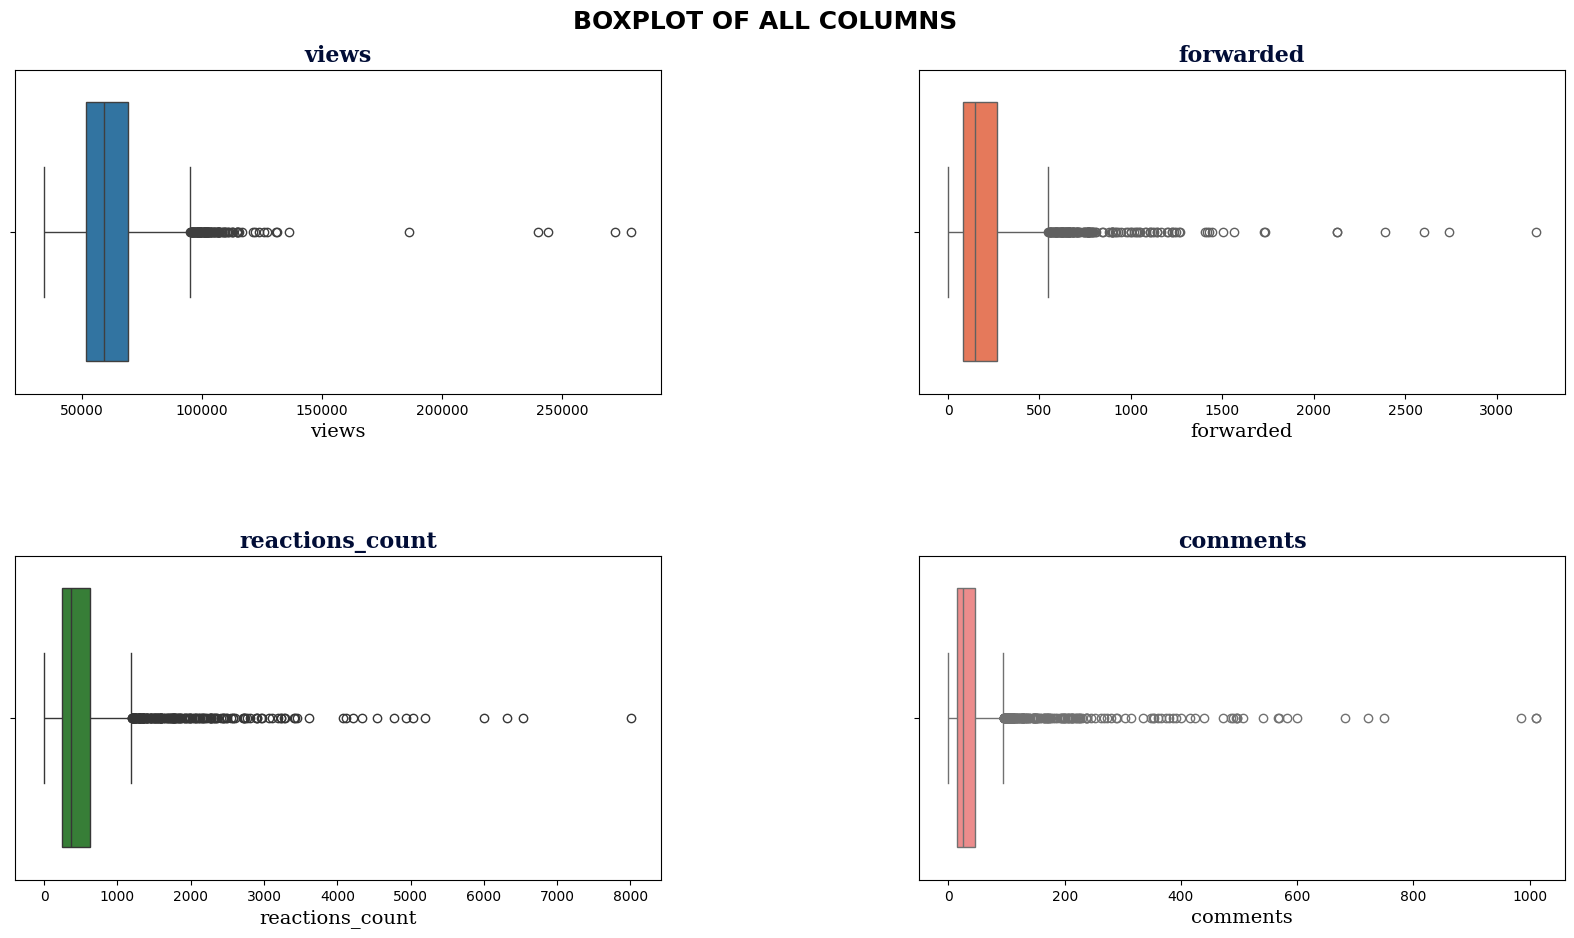

In [ ]:
# выберем данные о просмотрах, репостах, реакциях и комментариях
num_columns = merged_df[['views', 'forwarded', 'reactions_count', 'comments']]

# построим графики боксплот
plt.rcParams['axes.facecolor'] = 'white'
fig = plt.figure(figsize=[20,10])
fig.suptitle('BOXPLOT OF ALL COLUMNS', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(num_columns):
    ax1 = fig.add_subplot(2,2, i+1);
    ax1 = sns.boxplot(data = merged_df, x=col, color= colours[i]);
    ax1.set_title(f'{col}', fontdict=axtitle_dict)
    ax1.set_xlabel(f'{col}', fontdict=axlab_dict)

plt.show()

In [ ]:
# проверим также характерные значения с помощью метода describe
merged_df[['views', 'forwarded', 'reactions_count', 'comments']].describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


views    forwarded  reactions_count     comments
count    2679.000000  2679.000000      2679.000000  2679.000000
mean    62534.904815   210.465472       537.820082    42.287421
std     16866.397397   226.873676       561.831329    68.241807
min     34256.000000     2.000000         0.000000     0.000000
25%     51582.000000    80.000000       245.000000    14.000000
50%     59042.000000   145.000000       371.000000    26.000000
75%     69006.000000   266.000000       621.000000    46.000000
max    278962.000000  3212.000000      8012.000000  1010.000000

Можно сделать следующие выводы о данных по просмотрам, репостам, реакциям и комментариям:  

1. Межквартильный размах(IQR - диапазон, внутри которого лежит большинство данных):  
- просмотры ≈ от 51000 до 70000  
- репосты ≈ от 80 до 250  
- реакции ≈ от 250 до 600
- комментарии ≈ от 15 до 50

2. Медианные значения:  
- просмотры - 62534     
- репосты - 145
- реакции - 371
- комментарии - 26  

3. Выбросами являются:  
- просмотры - значения более 180000
- репосты - значения более 700
- реакции - значения более 1400
- комментарии - значения болеее 100  

## Типы публикаций

In [ ]:
# посмотрим на структуру текста в постах на примере первых двух постов
merged_df['text'].values[:2]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Вышел первый [трейлер](https://youtu.be/PKBKmaOFlsg) фильма «Вызов» Клима Шипенко — того самого, ради которого режиссер вместе с актрисой Юлией Пересильд поднимался на борт МКС. \n\nПремьера картины — 12 апреля 2023 года, в день космонавтики. \n\n«Вызов» стал первым фильмом, который снимался прямо на космической станции. О том, как проходила подготовка к съемкам, мы рассказывали [в нашем материале](https://www.kinopoisk.ru/media/news/4005231/?utm_source=telegram&utm_medium=social).',
       'Дождались!\n\nНа Кинопоиске вышел «Гром: Трудное детство» — полнометражный приквел боевика «Майор Гром: Чумной Доктор», посвященный взрослению главного героя в 1990-е.\n\nРассказываем в карточках самое важное, что нужно знать о фильме, и желаем [приятного просмотра](https://www.kinopoisk.ru/film/4771048/?utm_source=telegram&utm_medium=social) ❤️'],
      dtype=object)

Как мы видим, значения в колонке text неоднородные, в частности, в тексте присутствуют ссылки и эмодзи, которые могут указывать на определенный тип публикуемого контента.

Напишем функцию, которая проверит наличие ссылок и эмодзи, а затем присвоит типы публикаций каждому посту:

In [ ]:
def categorize_links(text):
    # регулярное выражение для поиска ссылок
    link_regex = r'(https?://\S+)'
    links = re.findall(link_regex, text)

    if ('📸' in text or 'Фото: соцсети' in text) and '🔥 Подписывайтесь на [**«Кинопоиск»**](https://t.me/kinopoisk)' in text and len(links) == 1:
        return 'Фотографии'
    # Проверяем, что есть только одна ссылка и это ссылка на Кинопоиск
    if '🔥 Подписывайтесь на [**«Кинопоиск»**](https://t.me/kinopoisk)' in text and len(links) == 1:
        return 'Текст'

    # Проверяем наличие фотографий в тексте и ссылку на Кинопоиск


    categories = {
        'Кинопоиск медиа/новости': ['kinopoisk.ru/media/news', 'kinopoisk.ru/news'],
        'Кинопоиск новости тг': ['t.me/kinopoisk_soon'],
        'Кинопоиск медиа/статьи': ['kinopoisk.ru/media/article'],
        'Кинопоиск подборки': ['kinopoisk.ru/lists'],
        'Кинопоиск игры, тесты': ['kinopoisk.ru/media/game'],
        'Кинопоиск фильмы': ['kinopoisk.ru/film'],
        'Кинопоиск сериалы': ['kinopoisk.ru/series'],
        'Кинопоиск игры тг': ['t.me/igrapoisk'],
        'Кинопоиск новости тг': ['t.me/kinopoisk_soon'],
        'Кинопоиск видеоэсс тг': ['t.me/kinopoisk_videoessay'],
        'Кинопоиск ютуб': ['youtu.be', 'youtube.com'],
        'Кинопоиск плюс тг': ['t.me/plus_yndx'],
        'Букмейт': ['bookmate.ru'],
        'Яндекс музыка': ['music.yandex.ru'],
        'Подкаст': ['podcast.ru'],
        'Прочие ссылки': []  # Для ссылок, которые не соответствуют другим категориям
    }

    post_categories = set()  # Используем множество для уникальных категорий

    if not links:
        return 'Текст'

    for link in links:
        for category, keywords in categories.items():
            if any(keyword in link.lower() for keyword in keywords):
                post_categories.add(category)
                break
        if not post_categories:
            post_categories.add('Прочие ссылки')

    return ', '.join(post_categories)

merged_df['categories'] = merged_df['text'].apply(categorize_links)

# Выводим первые несколько строк DataFrame для проверки результата
merged_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id            datetime  \
0  31135 2023-01-01 09:15:26   
1  31151 2023-01-01 20:23:33   
2  31150 2023-01-01 20:00:12   
3  31136 2023-01-01 10:00:51   
4  31147 2023-01-01 14:55:33   

                                                text    views  \
0  Вышел первый [трейлер](https://youtu.be/PKBKma...  49611.0   
1  Дождались!\n\nНа Кинопоиске вышел «Гром: Трудн...  57794.0   
2  В широкий прокат вышел «Чебурашка» — вариация ...  57228.0   
3  Новый год — новые киновпечатления!🎄🎬\n\nУже се...  51746.0   
4  «Гром: Трудное детство» выходит на Кинопоиске ...  53993.0   

                                           reactions  \
0  {'_': 'MessageReactions', 'results': [{'_': 'R...   
1  {'_': 'MessageReactions', 'results': [{'_': 'R...   
2  {'_': 'MessageReactions', 'results': [{'_': 'R...   
3  {'_': 'MessageReactions', 'results': [{'_': 'R...   
4  {'_': 'MessageReactions', 'results': [{'_': 'R...   

                                          with_media  forwarded  \
0  {'_': 'MessageMediaWebPage', 'webpage': {'_': ...      101.0   
1  {'_': 'MessageMediaPhoto', 'spoiler': False, '...      231.0   
2  {'_': 'MessageMediaWebPage', 'webpage': {'_': ...       66.0   
3  {'_': 'MessageMediaPhoto', 'spoiler': False, '...       92.0   
4  {'_': 'MessageMediaPhoto', 'spoiler': False, '...      126.0   

                                             replies  reactions_count  \
0  {'_': 'MessageReplies', 'replies': 19, 'replie...              340   
1  {'_': 'MessageReplies', 'replies': 77, 'replie...              713   
2  {'_': 'MessageReplies', 'replies': 23, 'replie...              283   
3  {'_': 'MessageReplies', 'replies': 40, 'replie...              411   
4  {'_': 'MessageReplies', 'replies': 36, 'replie...              535   

   comments      type_attachment   date_YMD  total_subscribers  changes  \
0        19  MessageMediaWebPage 2023-01-01             226447     1337   
1        77    MessageMediaPhoto 2023-01-01             226447     1337   
2        23  MessageMediaWebPage 2023-01-01             226447     1337   
3        40    MessageMediaPhoto 2023-01-01             226447     1337   
4        36    MessageMediaPhoto 2023-01-01             226447     1337   

   new_subscribers  unsubscribed                               categories  
0             1214           -32  Кинопоиск медиа/новости, Кинопоиск ютуб  
1             1214           -32                         Кинопоиск фильмы  
2             1214           -32                   Кинопоиск медиа/статьи  
3             1214           -32                            Прочие ссылки  
4             1214           -32                            Яндекс музыка

In [ ]:
merged_df[merged_df['categories'] == 'Текст'].shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(546, 17)

У 546 постов (категория "Текст") нет ссылок и фото. Рассмотрим детальнее эти посты:

In [ ]:
# Посмотрим на тексты нескольких постов без фото и ссылок
merged_df[merged_df['categories'] == 'Текст']['text'].values[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['От капитана до короля — Джонни Депп на новом промо фильма «Жанна Дюбарри».\n\nБиографическая драма Майвенн («Мой король») покажет Деппа в образе короля Людовика XV. Картина посвящена истории Жанны Бекю, фаворитки французского монарха.\n\nУвидим Францию 1740-х на экране в этом году.',
       'Тим Бёртон на съемках «Бэтмена», оказывается, еле понимал Джека Николсона из-за того, как тот разговаривал.\n\n«У Джека очень абстрактная манера говорить. Он говорил мне что-то, я отвечал: „Да, я понял“. А потом переспрашивал кого-нибудь: „Что он вообще только что сказал?“» — рассказал Бёртон журналу Empire.\n\nБёртон таки нашел способ общаться с Николсоном. По словам режиссера, они разговаривали на первобытном уровне. «У нас было хорошее общение в стиле пещерных людей», — добавляет Бёртон.\n\nНиколсон, тем не менее, постоянно вселял уверенность и поддерживал Бёртона, для которого «Бэтмен» в то время был самым крупным проектом в карьере. «Я смог пройти через это благодаря ему», — признался 

Посты категории "Текст" в основном представляют собой обзоры фильмов, новости кино, интервью актеров.

In [ ]:
# Возьмем топ-10 категорий контента и посмотрим на медианные значения просмотров постов
merged_df['categories'].value_counts().head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Кинопоиск медиа/статьи                      802
Текст                                       546
Прочие ссылки                               292
Кинопоиск ютуб                              196
Кинопоиск фильмы                            179
Кинопоиск новости тг                        142
Кинопоиск медиа/новости                      87
Кинопоиск сериалы                            72
Подкаст                                      45
Кинопоиск медиа/статьи, Кинопоиск фильмы     30
Name: categories, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

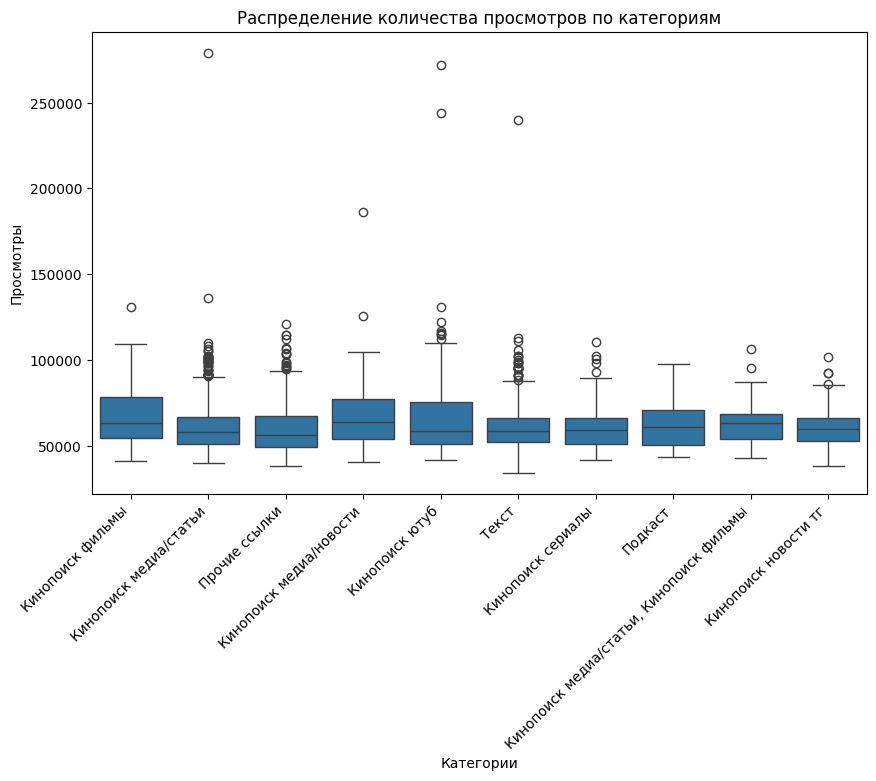

In [ ]:
# Сохраним топ-10 категорий контента
top_categories = merged_df['categories'].value_counts().head(10).index

# Фильтруем DataFrame, оставляя только строки с выбранными категориями
filtered_df = merged_df[merged_df['categories'].isin(top_categories)]

# Построим ящик с усами для просмотров каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='categories', y='views', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Категории')
plt.ylabel('Просмотры')
plt.title('Распределение количества просмотров по категориям')
plt.show()

График показывает, что просмотры практически никак не отличаются, медианные значения находятся на одном уровне. Это может быть связано с тем, что просмотры могут быть не самой информативной характеристикой поста.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

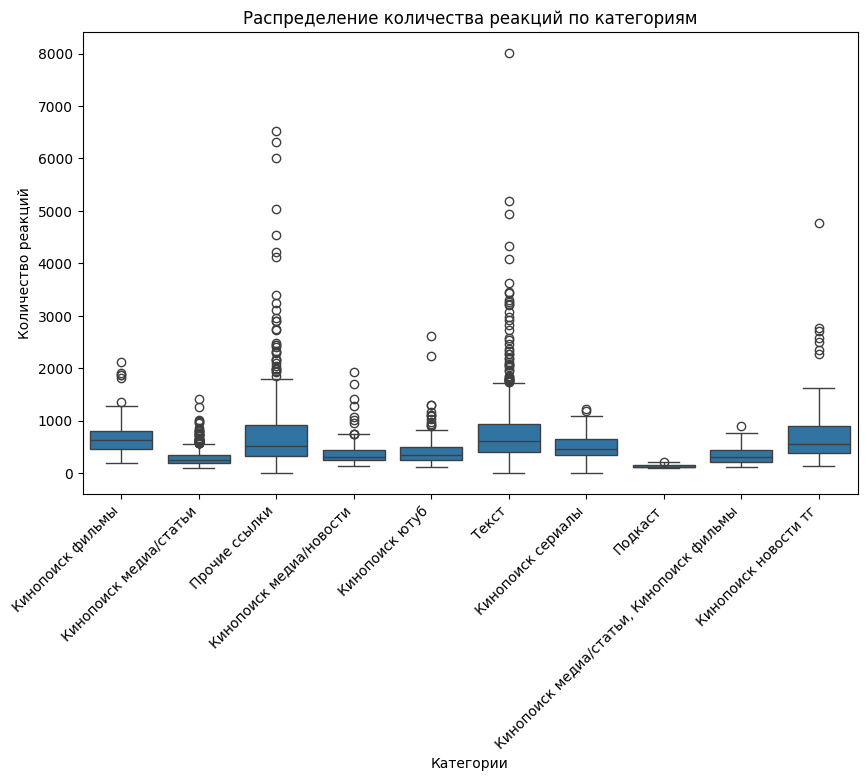

In [ ]:
# Строим ящик с усами для количества реакций каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='categories', y='reactions_count', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Категории')
plt.ylabel('Количество реакций')
plt.title('Распределение количества реакций по категориям')
plt.show()

Распределение количества реакций по категориям публикаций оказалось более информативным:

Наиболее **низкими** медианами по количеству реакций выделяются категории:
- **Кинопоиск медиа/статьи** (ссылки статьи и материалы Кинопоиска на сайте)
- **Подкасты** (ссылки на подкасты)  
- **Кинопоиск медиа/новости** (ссылки на новости на сайте Кинопоиска)

Это может быть связано с тем, что такие категории подразумевают трату времени: чтобы ознакомиться с контентом, нужно переходить, читать, слушать информацию, а реакции - это более быстрый и эмоциональный способ взаимодействия подписчиков с телеграм-каналом.

**Больше всего** реакций набирают категории:
 - **Прочие ссылки** (внешние ссылки, обычно новостные)
 - **Тексты** - как правило, общение и взаимодействие Кинопоиска с подписчиками. Например, вопросы аудитории (прим.: 'как вы думаете?' и т.п.)

Резюмируя, больше реакций набирают посты, которые являются уникальным контентом телеграм-канала Кинопоиска, а также посты, которые нацелены на взаимодействие с подписчиками, плюс короткие новости и анонсы кино-новинок.

Данный показатель (количество реакций) является информативным и может быть использован в качестве метрики эффективности поста.  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

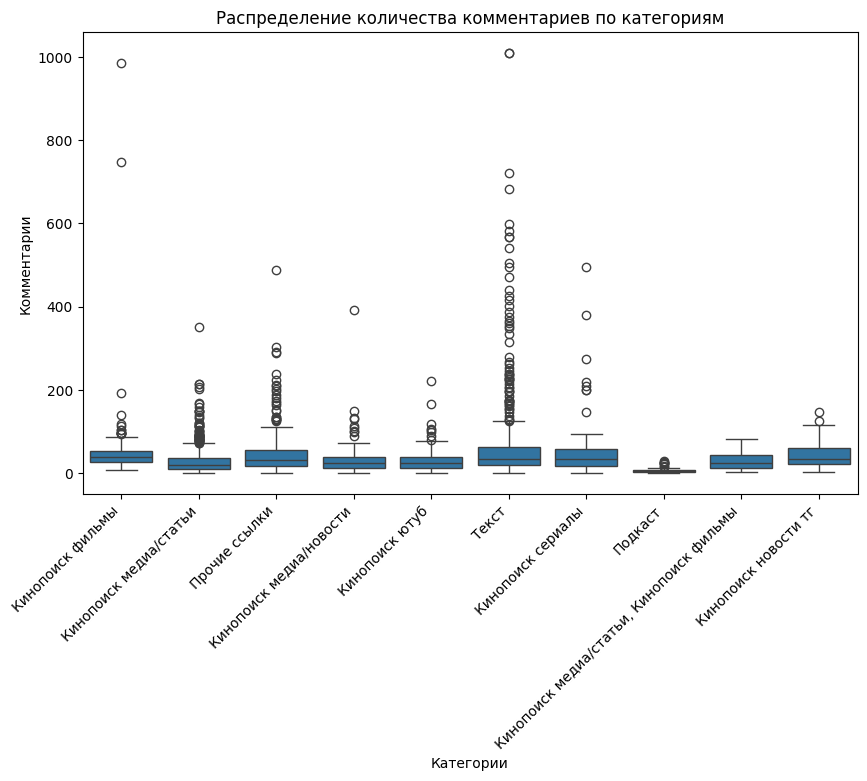

In [ ]:
# Строим ящик с усами для количества комментариев каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='categories', y='comments', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Категории')
plt.ylabel('Комментарии')
plt.title('Распределение количества комментариев по категориям')
plt.show()

Количество комментариев по категориям, также как и просмотры, является не очень информативным показателем.  

Однако, хочется отметить, что в категории **подкасты** наблюдается меньше всего комментариев. Это может быть связано с тем, что пост представляет собой просто анонс нового подкаста/дайджеста и ссылку на него.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

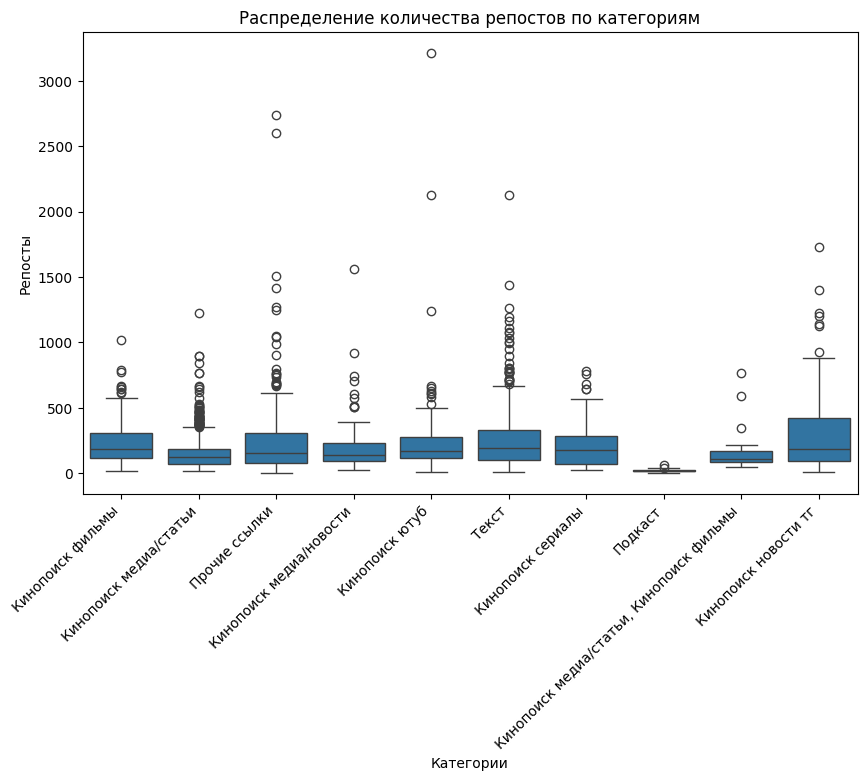

In [ ]:
# Строим ящик с усами для количества репостов каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='categories', y='forwarded', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Категории')
plt.ylabel('Репосты')
plt.title('Распределение количества репостов по категориям')
plt.show()

Анализ количества репостов по категориям показал следующие результаты:  


- **Ссылки на фильмы** пересылают **чаще** других категорий  

Посты о фильмах и сериалах часто могут и хотят порекомендовать друзьям/знакомым, поэтому показатели репостов у данной категории самые высокие  

- **Низким** медианным значением снова выделяются **подкасты**   

Причина предположительно, та же: для рекомендации подкаста нужно выделить время, чтобы сначала его прослушать/посмотреть, сформировать мнение, и только потом принять решение делиться с кем-то или нет.


- **Высоким** количестов репостов выделяются категории:   

1) *Прочие ссылки* (как правило, новости)  
2) *Текст* (новости, анонсы премьер)  
3) *Кинопоиск сериалы* (ссылки на сериалы)  
4) *Кинопоиск новости тг*(посты с новостями из тематического новостного телеграм-канала Кинопоиска)  

Резюмируя, подписчики **чаще** всего делятся постами о **фильмах**, **сериалах** (рекомендации друзьям/знакомым), а также короткими текстовыми постами, с которыми можно быстро ознакомиться и переслать - новости, премьеры и новинки.

## Темы постов


Тексты постов в соцсетях являются довольно сложным объектом для анализа.   

При определении типа публикаций было выявлено, что тексты постов являются неоднородными, содержат разные специальные символы, эмодзи, ссылки и не имеют каких-либо явных ключевых признаков, по которым их можно бы было однозначно сгруппировать.  

Ниже нами будет рассмотрено несколько подходов, позволяющих сформировать темы для каждого поста.  

### Подход 1: хэштеги и подсчет частоты слов в посте

При анализе типа публикаций была замечена некоторая структура текста в посте - **заголовки**, отделяемые символами \n\n, **квадратные скобки** (кликабельный текст ссылки, который видит читатель вместо http-адреса), а также проставленные **хэштеги** для некоторых постов.

Рассмотрим детальнее тексты нескольких постов:

In [ ]:
merged_df['text'].str.split('\n\n').str[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       Вышел первый [трейлер](https://youtu.be/PKBKma...
1                                              Дождались!
2       В широкий прокат вышел «Чебурашка» — вариация ...
3                    Новый год — новые киновпечатления!🎄🎬
4       «Гром: Трудное детство» выходит на Кинопоиске ...
                              ...                        
2674    Из «Психо» чуть не вырезали сцену в душе, а Дж...
2675    Как Джереми Аллен Уайт прошел путь от роли Лип...
2676    Новый постер «Мастера и Маргариты» посвящен, к...
2677    😻 Юра Борисов — котик, а «Мастер и Маргарита» ...
2678    Фильм дня — [**«Резня»**](https://www.kinopois...
Name: text, Length: 2679, dtype: object

Как видно из примеров, в заголовке поста, как правило,  содержится ключевая мысль текста, чтобы привлечь внимание читателя.

Предлагаю следующую логику определения тем постов:
- для постов с хэштегами выделим тему из хэштегов
- для остальных постов посчитаем частоту слов в посте и выберем в качестве темы наиболее встречаемое значение  

#### Очистка + лемматизация текста постов

In [ ]:
# Напишем функцию для очистки текста постов
def remove_punctuation(text):
    punctuation_to_remove = string.punctuation + '—«»'
    return "".join([ch if ch not in punctuation_to_remove else ' ' for ch in text])

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # смайлики эмодзи
                               u"\U0001F300-\U0001F5FF"  # символы и пиктограммы
                               u"\U0001F680-\U0001F6FF"  # символы транспорта и карты
                               u"\U0001F1E0-\U0001F1FF"  # флаги стран
                               u"\U00002500-\U00002BEF"  # китайские иероглифы
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text)

def remove_links(text):
    return re.sub(r'https?://\S+', '', str(text))

def preprocess_text(text):
    text = remove_links(text)
    text = remove_emoji(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = remove_multiple_spaces(text)
    text = text.replace('ё', 'е')
    return text.strip().lower()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Применим функцию для очистки текста постов
merged_df['pre_text'] = merged_df['text'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# сделаем копию датафрейма
data = merged_df.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# создадим список пользовательских стоп-слов
post_stopwords = {'фильм', 'подписываться', 'кинопоиск',
                 'который', 'свой', 'почему', 'самый',
                  'это', 'хороший', 'первый', 'второй', 'рассказывать',
                  'наш', 'кот', 'смотреть', 'мэнди', 'день', 'слово', 'фанни',
                   'возможно', 'включать', 'группа', 'завтра', 'канал'}

# объединим со значениями библиотеки nltk
stop_words = set(stopwords.words('russian')).union(post_stopwords)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Создание экземпляра класса MorphAnalyzer для лемматизации
parser = MorphAnalyzer()

# Загрузка списка стоп-слов для русского языка + пользовательских стоп-слов
custom_stop_words = set(stopwords.words('russian')).union(post_stopwords)

# напишем функцию для обработки текста с использованием pymorphy2 и NLTK
def preprocess_lemm(input_text):
    tokenized_text = word_tokenize(input_text)
    lemmatized_text = [parser.parse(word)[0].normal_form for word in tokenized_text if parser.parse(word)[0].tag.POS == 'NOUN']
    final_lemm = " ".join([word for word in lemmatized_text if len(word) > 3 and word not in custom_stop_words])
                        ## оставила сущ и слова >3х букв

    return final_lemm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Py

In [ ]:
# выделим заголовки постов
data['head'] = data['text'].str.split('\n\n').str[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Применим функцию для лемматизации текста
data['lemm_text'] = data['pre_text'].apply(preprocess_lemm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Применим функцию для очистки заголовков постов
data['pre_head'] = data['head'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Применим функцию для лемматизации заголовков
data['lemm_head'] = data['pre_head'].apply(preprocess_lemm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Определение тем для постов с хэштегами

Попробуем определить часть тем исходя их хэштегов:  
- сделаем отдельный столбец с хэштегами, если они есть в посте  
- приведем хэштеги к единому написанию и смысловой нагрузке

In [ ]:
# напишем функцию для извлечения хэштегов из текста постов
def extract_and_format_hashtags(text):
    hashtags = re.findall(r'#\w+', text) if pd.notna(text) else []
    return ', '.join(hashtags) if hashtags else pd.NA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# применим функцию к столбцу text и сохраним хэштеги в новый столбец hashtags
data['hashtags'] = data['text'].apply(lambda x: extract_and_format_hashtags(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# напишем функцию для нормализации хэштегов
def normalize_hashtags(hashtags):
    if isinstance(hashtags, str):  # Проверяем, что значение не NaN
        # Разделяем хэштеги по запятой и выбираем первый
        normalized_hashtags_list = [hashtag.strip() for hashtag in hashtags.split(',')]
        normalized_hashtags = normalized_hashtags_list[0]
        # Приводим все символы к нижнему регистру
        normalized_hashtags = normalized_hashtags.lower()
        # Заменяем 'коротыше' на 'коротыш'
        normalized_hashtags = normalized_hashtags.replace('коротыше', 'коротыш')
        # Удаляем годы из хэштега
        normalized_hashtags = re.sub(r'\b20\d{2}\b', '', normalized_hashtags)
        # Удаляем все символы, кроме букв
        normalized_hashtags = re.sub(r'[^a-zA-Zа-яА-Я,]', '', normalized_hashtags)

        return normalized_hashtags
    else:
        return ''  # Возвращаем пустую строку для пропущенных значений

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# применим функцию нормализации хэштегов и сохраним значения в столбец topic
data['topic'] = data['hashtags'].apply(normalize_hashtags)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# заменим пустые значения на NaN
data['topic'] = data['topic'].mask(data['topic'] == '', pd.NA)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data['topic'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([<NA>, 'кинопанорама', 'коротыш', 'оскар', 'киномемкп', 'нейрокп',
       'канны', 'дайджестновостей', 'кпитоги', 'мартимертв', 'подслушано',
       'летоскинопоиском', 'песочетверг', 'венеция',
       'рейтингфильмографии', 'кпвеликихигр', 'дождались', 'всейсемьей',
       'кпвеликихфильмов', 'кпновоеимя', 'скажимиядзаки',
       'кинопопятницам', 'гостькинопоиска', 'малкович', 'итогикп',
       'кпитогигода', 'дежурныйпокинопоиску'], dtype=object)

In [ ]:
# создадим словарь для замены значений
replacement_dict = {
    'летоскинопоиском': 'рекомендации',
    'дайджестновостей': 'новости',
    'венеция': 'кинофестивали',
    'канны': 'кинофестивали',
    'кпновоеимя': 'актеры',
    'дежурныйпокинопоиску': 'дежурный_по_кинопоиску',
    'оскар': 'премии_и_номинации',
    'кинопанорама': 'рецензии_и_обзоры',
    'кинопопятницам': 'рецензии_и_обзоры',
    'рейтингфильмографии': 'рейтинги',
    'киномемкп': 'юмор',
    'нейрокп': 'юмор',
    'всейсемьей': 'рекомендации',
    'скажимиядзаки': 'премьеры',
    'мартимертв': 'рецензии_и_обзоры',
    'гостькинопоиска': 'интерактив',
    'песочетверг': 'интерактив',
    'малкович': 'актеры',
    'дождались': 'рецензии_и_обзоры'
}

# заменим значения с использованием словаря
data['topic'] = data['topic'].apply(lambda x: replacement_dict.get(x, x))

# заменим значения с помощью lambda-функции
data['topic'] = data['topic'].apply(lambda x: 'рейтинги' if isinstance(x, str) and 'великих' in x else x)
data['topic'] = data['topic'].apply(lambda x: 'рейтинги' if isinstance(x, str) and 'итоги' in x else x)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data['topic'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


коротыш                   113
рейтинги                   35
премии_и_номинации         32
рецензии_и_обзоры          25
кинофестивали              17
рекомендации               11
подслушано                  7
дежурный_по_кинопоиску      6
новости                     4
юмор                        3
интерактив                  3
актеры                      2
премьеры                    1
Name: topic, dtype: int64

#### Определение тем из частых значений

In [ ]:
# cоздадим срез датафрейма с пустыми значениями в колонке 'topic'
no_topic = data[data['topic'].isna()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from collections import Counter

# Функция для подсчета частоты слов
def count_word_frequency(lemm_text):
    words = lemm_text.split()
    word_count = Counter(words)
    # Оставляем только слова с частотой больше 1
    filtered_word_count = {word: count for word, count in word_count.items() if count > 1}
    return word_count

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
no_topic.head(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id            datetime  \
0  31135 2023-01-01 09:15:26   

                                                text    views  \
0  Вышел первый [трейлер](https://youtu.be/PKBKma...  49611.0   

                                           reactions  \
0  {'_': 'MessageReactions', 'results': [{'_': 'R...   

                                          with_media  forwarded  \
0  {'_': 'MessageMediaWebPage', 'webpage': {'_': ...      101.0   

                                             replies  reactions_count  \
0  {'_': 'MessageReplies', 'replies': 19, 'replie...              340   

   comments  ... new_subscribers unsubscribed  \
0        19  ...            1214          -32   

                                categories  \
0  Кинопоиск медиа/новости, Кинопоиск ютуб   

                                            pre_text  \
0  вышел первый трейлер фильма вызов клима шипенк...   

                                                head  \
0  Вышел первый [трейлер](https://youtu.be/PKBKma...   

                                           lemm_text  \
0  трейлер вызов клим шипенко режиссёр актриса юл...   

                                            pre_head  \
0  вышел первый трейлер фильма вызов клима шипенк...   

                                           lemm_head hashtags topic  
0  трейлер вызов клим шипенко режиссёр актриса юл...     <NA>  <NA>  

[1 rows x 24 columns]

In [ ]:
# Применение функции к каждой строке
no_topic['freq_head'] = no_topic['lemm_head'].apply(count_word_frequency)
no_topic['freq_text'] = no_topic['lemm_text'].apply(count_word_frequency)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# сделаем сортировку значений словаря по убыванию частоты
no_topic['freq_text'] = no_topic['freq_text'].apply(lambda x: dict(sorted(x.items(), key=lambda item: item[1], reverse=True)))

no_topic['freq_head'] = no_topic['freq_head'].apply(lambda x: dict(sorted(x.items(), key=lambda item: item[1], reverse=True)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
no_topic[['id', 'text', 'lemm_text', 'lemm_head', 'freq_head', 'freq_text']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id                                               text  \
0  31135  Вышел первый [трейлер](https://youtu.be/PKBKma...   
1  31151  Дождались!\n\nНа Кинопоиске вышел «Гром: Трудн...   
2  31150  В широкий прокат вышел «Чебурашка» — вариация ...   
3  31136  Новый год — новые киновпечатления!🎄🎬\n\nУже се...   
4  31147  «Гром: Трудное детство» выходит на Кинопоиске ...   

                                           lemm_text  \
0  трейлер вызов клим шипенко режиссёр актриса юл...   
1  гром детство приквел боевик майор гром доктор ...   
2  прокат чебурашка вариация тема классика ушасти...   
3  киновпечатление приквел майор гром детство пот...   
4  гром детство саундтрек плейлист композиция янд...   

                                           lemm_head  \
0  трейлер вызов клим шипенко режиссёр актриса юл...   
1                                                      
2    прокат чебурашка вариация тема классика ушастик   
3                                    киновпечатление   
4                             гром детство саундтрек   

                                           freq_head  \
0  {'трейлер': 1, 'вызов': 1, 'клим': 1, 'шипенко...   
1                                                 {}   
2  {'прокат': 1, 'чебурашка': 1, 'вариация': 1, '...   
3                             {'киновпечатление': 1}   
4          {'гром': 1, 'детство': 1, 'саундтрек': 1}   

                                           freq_text  
0  {'вызов': 2, 'трейлер': 1, 'клим': 1, 'шипенко...  
1  {'гром': 2, 'детство': 1, 'приквел': 1, 'боеви...  
2  {'шапокляк': 2, 'прокат': 1, 'чебурашка': 1, '...  
3  {'киновпечатление': 1, 'приквел': 1, 'майор': ...  
4  {'гром': 2, 'детство': 2, 'саундтрек': 1, 'пле...

In [ ]:
#no_topic['topic'] = pd.NA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# запишем в качестве темы слова, которые чаще всего встречаются в посте
## Функция для оставления только ключа с максимальной частотой
def get_max_word(row):
    word_counts = row['freq_text']
    if word_counts:
        max_word = max(word_counts, key=word_counts.get)
        return max_word
    else:
        return None

# Применение функции к каждой строке
no_topic['topic'] = no_topic.apply(get_max_word, axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.f

In [ ]:
# посмотрим на значения топ-20 тем
no_topic['topic'].value_counts().head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


сериал     92
сезон      42
игра       30
ответ      30
друг       27
трейлер    22
подкаст    22
серия      19
кино       19
джон       18
Name: topic, dtype: int64

In [ ]:
no_topic.query('topic == "сезон"')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


id            datetime  \
18    31165 2023-01-03 09:22:33   
53    31213 2023-01-10 19:01:18   
117   31310 2023-01-17 14:25:01   
128   31321 2023-01-18 13:07:52   
137   31342 2023-01-19 14:30:27   
226   31478 2023-01-30 10:55:15   
231   31516 2023-01-31 19:30:42   
263   31561 2023-02-02 18:13:43   
359   31762 2023-02-13 19:02:15   
464   31975 2023-02-28 19:02:52   
475   31982 2023-03-01 15:54:05   
512   32044 2023-03-06 12:52:18   
604   32214 2023-03-14 12:35:48   
608   32248 2023-03-15 20:00:09   
616   32238 2023-03-15 11:40:40   
681   32357 2023-03-24 19:31:10   
1001  33028 2023-05-13 18:02:11   
1046  33105 2023-05-21 12:18:37   
1113  33271 2023-06-01 12:52:26   
1154  33376 2023-06-07 16:58:20   
1161  33400 2023-06-08 22:34:19   
1221  33509 2023-06-18 02:43:55   
1248  33573 2023-06-22 17:01:51   
1273  33633 2023-06-28 18:00:09   
1318  33784 2023-07-06 17:10:09   
1326  33796 2023-07-07 18:00:58   
1333  33805 2023-07-08 10:59:21   
1349  33846 2023-07-11 14:30:40   
1391  33964 2023-07-17 19:31:03   
1670  34629 2023-08-31 19:04:06   
1680  34639 2023-09-01 19:00:39   
1715  34704 2023-09-05 12:04:42   
1776  34900 2023-09-15 21:50:00   
1918  35217 2023-10-04 15:23:26   
1938  35250 2023-10-06 12:28:20   
1956  35312 2023-10-09 16:51:57   
1974  35349 2023-10-12 11:00:12   
2016  35452 2023-10-18 13:59:26   
2203  35907 2023-11-12 14:01:02   
2231  35984 2023-11-15 18:31:05   
2273  36075 2023-11-21 10:10:06   
2524  36739 2023-12-26 16:54:41   

                                                   text    views  \
18    Сериал «1899» на второй сезон не продлят. Как ...  51205.0   
53    Завершился третий (и последний) сезон фэнтези-...  44560.0   
117   Что мы увидим в третьем сезоне «Мандалорца»? К...  47596.0   
128   К актерскому составу третьего сезона «Убийства...  50716.0   
137   На Amazon вышел второй сезон «Охотников» — сер...  50573.0   
226   Пятый сезон «Очень странных дел» начнут снимат...  52674.0   
231   Человек или кровосос? 🤔\n\nК финалу второго се...  49753.0   
263   Третьему сезону «Вампиров средней полосы» [быт...  41860.0   
359   Кто? «Ты». \n\nНа Netflix стартовал четвертый ...  46979.0   
464   Мандо, мы дома!\n\nУже завтра на Disney+ старт...  50881.0   
475   Третий сезон «Мандалорца»: выходит \n\nМы: дел...  49833.0   
512   Первый сезон «Одних из нас» (18+) почти у фини...  54216.0   
604   На HBO завершился первый сезон «Одних из нас» ...  55851.0   
608   На Apple TV+ стартовал третий и последний сезо...  52915.0   
616   Финальный сезон «Теда Лассо» [покорил](https:/...  56745.0   
681   Осталось всего ничего — финальный сезон «Насле...  65094.0   
1001  Чего ждать от второго сезона «Андора»? Когда в...  63662.0   
1046  «Третий сезон МДЖ закатывает планку на новый у...  62142.0   
1113  Ну она 💅\n\n__Ждете второй сезон? \n__🔥__ __—_...  65507.0   
1154  «Дневники вампира» — сериал, в котором полно и...  50134.0   
1161  [Трейлер](https://www.youtube.com/watch?v=SzS8...  56252.0   
1221  Закончилась трансляция Tudum! Рассказываем о г...  80686.0   
1248  Новый Гай Ричи, второй сезон «Медведя» и Ник Ф...  65631.0   
1273  Второй сезон **«Пищеблока»** стартует 8 июля, ...  68322.0   
1318  Второй сезон «Пищеблока» выходит совсем скоро....  68226.0   
1326  Второй сезон «Пищеблока» выходит уже завтра. С...  70073.0   
1333  Второй сезон [**«Пищеблока»**](https://www.kin...  84465.0   
1349  В небесной канцелярии подсуетились, и этот ден...  60826.0   
1391  На Apple TV+ стартовал второй сезон «Основания...  73786.0   
1670  «В первом сезоне герой боролся с системой, а в...  61259.0   
1680  Помните,[ ](https://www.kinopoisk.ru/media/art...  52049.0   
1715  Давно не было новостей с Патриков! Там, между ...  42923.0   
1776  Итак, что нас ждет в новом сезоне?\n\nСобрали ...  53626.0   
1918  Второй сезон «Локи» крут? И да и нет!\n\nВыбра...  43831.0   
1938  На Apple TV+ идет третий сезон «Утреннего шоу»...  45368.0   
1956  🔥 ОГО! У нас вышел первый сезон [**«**](https:...

In [ ]:
# создадим словарь для замены значений
replacement_dict = {
    'сезон': 'сериал',
    'серия': 'премьеры',
    'кино': 'рекомендации',
    'джон': 'джон уик'
}

# заменим значения с использованием словаря
no_topic['topic'] = no_topic['topic'].apply(lambda x: replacement_dict.get(x, x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# запишем полученные значения в датафрейм data
data['topic'] = data['id'].map(no_topic.set_index('id')['topic']).combine_first(data['topic'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# посмотрим на топ-10 тем постов
data['topic'].value_counts().head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


сериал                134
коротыш               113
рейтинги               35
премии_и_номинации     32
игра                   30
рекомендации           30
ответ                  30
друг                   27
рецензии_и_обзоры      25
трейлер                22
Name: topic, dtype: int64

#### Боксплоты для топ-10 тем постов

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

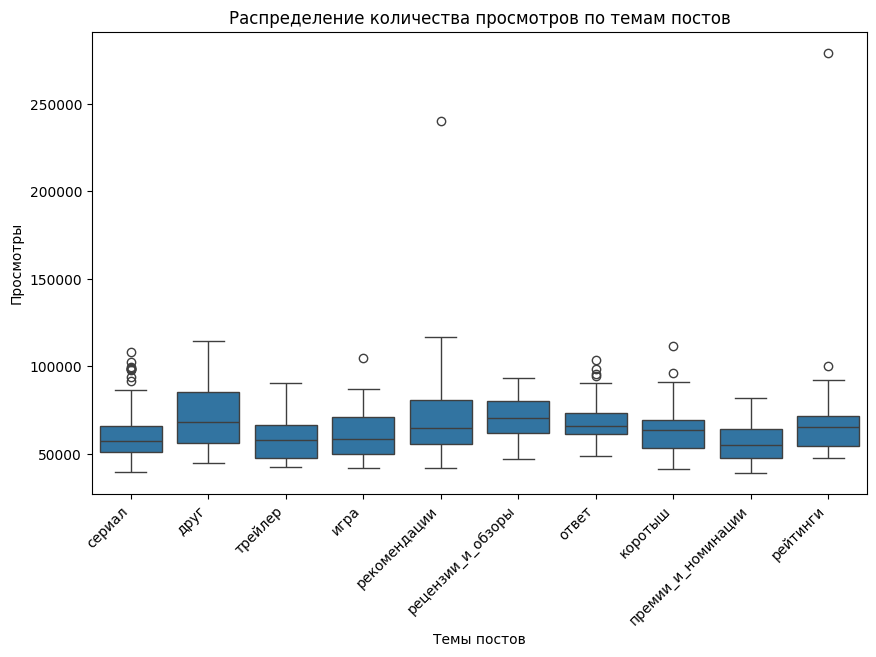

In [ ]:
# Сохраним топ-10 тем постов
top_topic = data['topic'].value_counts().head(10).index

# Фильтруем DataFrame, оставляя только строки с выбранными категориями
filtered_df = data[data['topic'].isin(top_topic)]

# Построим ящик с усами для просмотров каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic', y='views', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Темы постов')
plt.ylabel('Просмотры')
plt.title('Распределение количества просмотров по темам постов')
plt.show()

Распределение количества просмотров по темам довольно информативно:  
- **больше** всего просматривают посты с темой **друг** (подавляющая часть это обращение и вопросы к читателям, интерактивы с ними, чуть реже новости о партнерских проектах, прим.: "у наших друзей..")  
- высокие показатели по количеству просмотров также у рецензий, рейтингов и обзоров кино   

<font color='red'>КОМЕНТАРИЙ РЕВЬЮЕРА</font> : ну тут у меня чисто смысловой вопрос: а что чкрывается за жтим друг и коротыш? понимаю, что навреное многое что.. но не ясно..

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

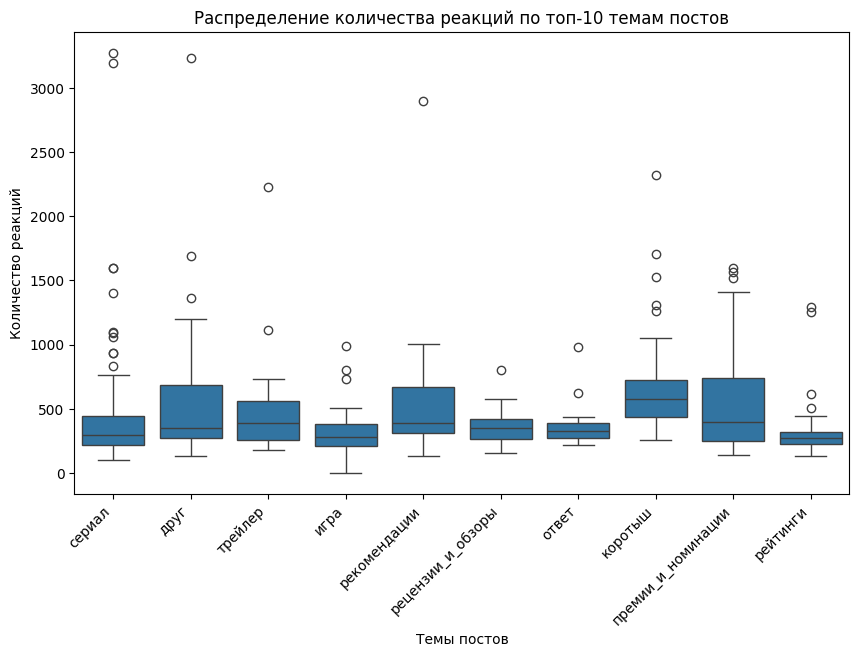

In [ ]:
# Строим ящик с усами для количества реакций каждой из топ-10 тем
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic', y='reactions_count', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Темы постов')
plt.ylabel('Количество реакций')
plt.title('Распределение количества реакций по топ-10 темам постов')
plt.show()

Количество реакций также довольно показательно и разнится для разных тем постов:  
- **Больше** всего реакций получают видео из рубрики "**коротыш**"(короткие видео-отрывки из разных фильмов) и посты о грядущих или прошедших **премиях** и **номинациях**
- Довольно **большое** количество реакций (как и просмотров) имеют посты со взаимодействием с читателями (тема "**друг**")  
- **Меньше** всего реакций ставят на посты с **подкастами** и **рейтингами**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

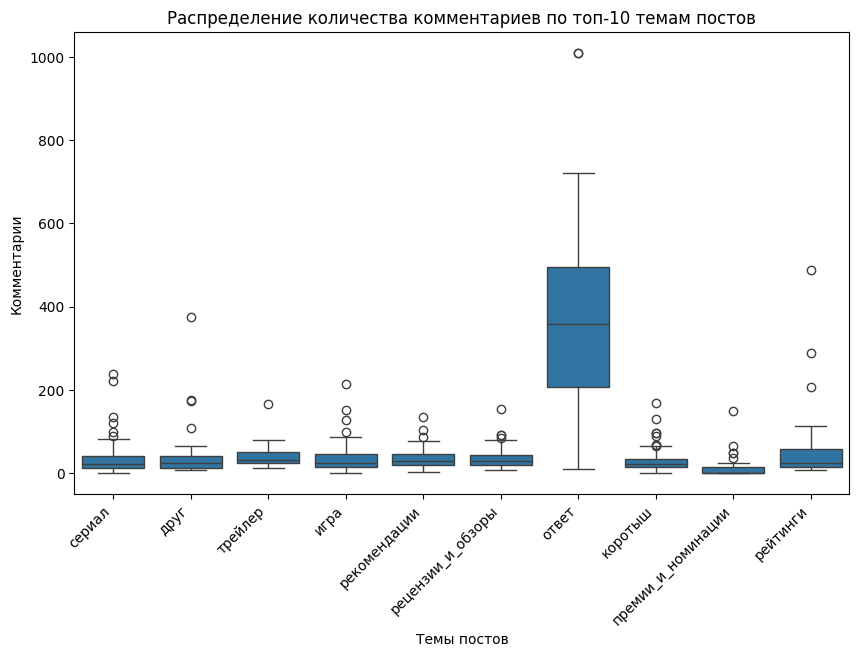

In [ ]:
# Строим ящик с усами для количества комментариев каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic', y='comments', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Темы постов')
plt.ylabel('Комментарии')
plt.title('Распределение количества комментариев по топ-10 темам постов')
plt.show()

Как мы видим, количество комментариев не является слишком информативным показателем в разрезе тем постов.   

Все темы, за исключением одной - **ответ**, которая содержит в текстах прямой призыв к действию, слабо комментируются.  
- Меньше всего читатели комментируют подскасты и премии, остальные темы имеют схожее количество комментариев.  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

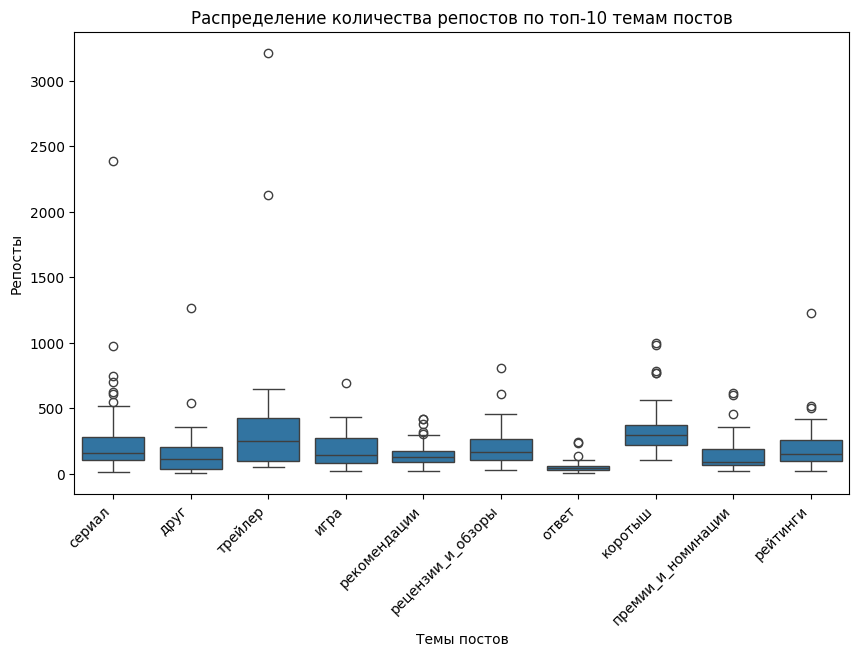

In [ ]:
# Строим ящик с усами для количества репостов каждой категории
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic', y='forwarded', data=filtered_df)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Темы постов')
plt.ylabel('Репосты')
plt.title('Распределение количества репостов по топ-10 темам постов')
plt.show()

Количество репостов в разрезе тем постов является слабо информативным показателем.  

Однако, стоит отметить, что **больше** всего читатели репостят **видео-контент** (рубрика "коротыш"), а **меньше** всего посты, подразумевающие взаимодействие и общение с читателями (тема "**ответ**", "**друг**").

Остальные темы имеют схожее количество репостов.

### Другой подход к выделению тем

####  Подготовка данных

In [ ]:
parser = MorphAnalyzer()

# Функция для обработки текста с использованием pymorphy2 и NLTK
def preprocess_lemm(input_text):
    tokenized_text = word_tokenize(input_text)
    lemmatized_text = [parser.parse(word)[0].normal_form for word in tokenized_text]
    out_text = " ".join(lemmatized_text)
    return out_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Py

In [ ]:
merged_df['lemm1'] = merged_df['pre_text'].apply(preprocess_lemm)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Выделим стопслова
# Скачиваем стоп-слова из JSON-файла
url_stopwords_ru = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.json"
response = requests.get(url_stopwords_ru)
stopwords_ru = set(json.loads(response.text))

# Cоздаем словарь из стоп-слов
stopwords_nltk_ru = set(nltk_stopwords.words('russian'))
all_stopwords = stopwords_nltk_ru | stopwords_ru

all_stopwords = all_stopwords.union({'…', '"', '...', '-', 'подписываться', 'на', 'кинопоиск', 'getty',\
                                     'images', 'фото', 'легион', 'медиа'
                                     })

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Функция для удаления стопслов
def remove_stop_words(text):
    # Загрузка списка стоп-слов для русского языка
    # Токенизация текста
    tokens = text.split()
    stopwords = all_stopwords

    # Удаление стоп-слов
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords]

    # Сборка текста из оставшихся токенов
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df['lemm1'] = merged_df['lemm1'].apply(remove_stop_words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df[['text', 'pre_text', 'lemm1']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


text  \
0  Вышел первый [трейлер](https://youtu.be/PKBKma...   
1  Дождались!\n\nНа Кинопоиске вышел «Гром: Трудн...   
2  В широкий прокат вышел «Чебурашка» — вариация ...   
3  Новый год — новые киновпечатления!🎄🎬\n\nУже се...   
4  «Гром: Трудное детство» выходит на Кинопоиске ...   

                                            pre_text  \
0  вышел первый трейлер фильма вызов клима шипенк...   
1  дождались на кинопоиске вышел гром трудное дет...   
2  в широкий прокат вышел чебурашка вариация на т...   
3  новый год новые киновпечатления уже сегодня на...   
4  гром трудное детство выходит на кинопоиске веч...   

                                               lemm1  
0  трейлер фильм вызов клим шипенко ради режиссёр...  
1  дождаться гром трудный детство полнометражный ...  
2  широкий прокат чебурашка вариация тема классик...  
3  киновпечатление k долгожданный приквел майор г...  
4  гром трудный детство выходить вечером послушат...

In [ ]:
## Биграммы
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([text.split() for text in merged_df['lemm1']])
# Filter only those that occur at least 5 times
finder.apply_freq_filter(5)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram, lang='rus')
    # Отладочная информация
    print("Bigram:", bigram)
    print("Tags:", tag)
    # Проверяем, что оба элемента биграммы являются существительными или прилагательными
    if (tag[0][1].startswith('S') or tag[0][1].startswith('A')) and (tag[1][1].startswith('S') or tag[1][1].startswith('A')):
        return True
    return False

filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.f

Bigram: ('arturo', 'holmes')
Tags: [('arturo', 'NONLEX'), ('holmes', 'NONLEX')]
Bigram: ('пак', 'чхан')
Tags: [('пак', 'V'), ('чхан', 'S')]
Bigram: ('чхан', 'ук')
Tags: [('чхан', 'S'), ('ук', 'S')]
Bigram: ('уолл', 'стрит')
Tags: [('уолл', 'S'), ('стрит', 'V')]
Bigram: ('тайка', 'вайтити')
Tags: [('тайка', 'S'), ('вайтити', 'S')]
Bigram: ('rotten', 'tomatoes')
Tags: [('rotten', 'NONLEX'), ('tomatoes', 'NONLEX')]
Bigram: ('натали', 'портман')
Tags: [('натали', 'V'), ('портман', 'S')]
Bigram: ('вино', 'дизель')
Tags: [('вино', 'S'), ('дизель', 'S')]
Bigram: ('кристен', 'стюарт')
Tags: [('кристен', 'A=m'), ('стюарт', 'S')]
Bigram: ('comic', 'con')
Tags: [('comic', 'NONLEX'), ('con', 'NONLEX')]
Bigram: ('кунг', 'фу')
Tags: [('кунг', 'S'), ('фу', 'ANUM=ciph')]
Bigram: ('энтони', 'хопкинс')
Tags: [('энтони', 'S'), ('хопкинс', 'A=pl')]
Bigram: ('риза', 'уизерспун')
Tags: [('риза', 'V'), ('уизерспун', 'S')]
Bigram: ('spider', 'man')
Tags: [('spider', 'NONLEX'), ('man', 'NONLEX')]
Bigram: ('джо

In [ ]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df['lemm1'] = merged_df['lemm1'].map(lambda x: replace_ngram(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df[['text', 'lemm1']].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


text  \
0  Вышел первый [трейлер](https://youtu.be/PKBKma...   
1  Дождались!\n\nНа Кинопоиске вышел «Гром: Трудн...   
2  В широкий прокат вышел «Чебурашка» — вариация ...   
3  Новый год — новые киновпечатления!🎄🎬\n\nУже се...   
4  «Гром: Трудное детство» выходит на Кинопоиске ...   

                                               lemm1  
0  трейлер фильм вызов клим шипенко ради режиссёр...  
1  дождаться гром_трудный_детство полнометражный ...  
2  широкий прокат чебурашка вариация тема классик...  
3  киновпечатление k долгожданный приквел майор_г...  
4  гром_трудный_детство выходить вечером послушат...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


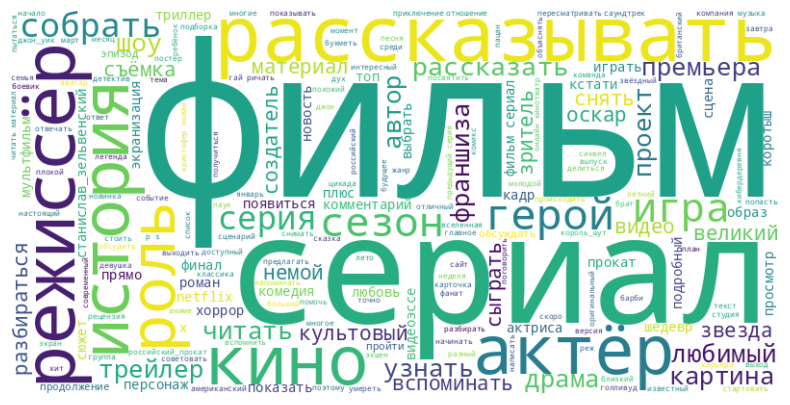

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Объединяем текст из столбца датафрейма в одну строку
text = ' '.join(merged_df['lemm1'])

# Создаем объект WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Отображение облака слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
merged_df['lemm_text'] = merged_df['lemm1'].apply(lambda x: x.split())
merged_df['lemm_text']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       [трейлер, фильм, вызов, клим, шипенко, ради, р...
1       [дождаться, гром_трудный_детство, полнометражн...
2       [широкий, прокат, чебурашка, вариация, тема, к...
3       [киновпечатление, k, долгожданный, приквел, ма...
4       [гром_трудный_детство, выходить, вечером, посл...
                              ...                        
2674    [психо, вырезать, сцена, джон, рэмбо, умереть,...
2675    [джереми, аллен, уайт, пройти, роль, липа, бес...
2676    [постер, мастер_маргарита, посвятить, кот, бег...
2677    [юра_борис, котик, мастер_маргарита, ожидать, ...
2678    [фильм, резня, роман_поланский, семейный, пара...
Name: lemm_text, Length: 2679, dtype: object

In [ ]:
# Делим данные на обучающую и тестовую выборки
X_train, X_test = train_test_split(merged_df['lemm1'], test_size=0.2, random_state=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
 def transform_data(data: pd.Series) -> list:
    transform_lst = data.tolist() # Преобразуем объект Series в список списков и затем в один плоский список
    transform_lst = [x for x in transform_lst if x not in [None, '']]  # Удаляем значения None и пустые строки из списка
    return transform_lst

train_lst = transform_data(X_train)
test_lst = transform_data(X_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Подход 1: Модель LDA

In [ ]:
vector_ben = CountVectorizer(
    analyzer='word',
    min_df = 5)

train_vec_ben = vector_ben.fit_transform(train_lst)
test_vec_ben = vector_ben.transform(test_lst)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Модель латентного размещения Дирихле
lda_model_ben = LatentDirichletAllocation(
    learning_method='online', random_state=10,
    n_jobs=-1,
)
lda_model_ben.fit(train_vec_ben)
print(lda_model_ben)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=10)


In [ ]:
print("Log Likelihood: ", lda_model_ben.score(test_vec_ben))
# Перплексия - сложность. чем ниже, тем лучше
print("Perplexity: ", lda_model_ben.perplexity(test_vec_ben))

Log Likelihood:  -65095.54046831645


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  7368.715601211103


In [ ]:
def get_coherence_mean(model, texts, n_top_words=20):
    """Получение средней оценки когерентности"""

    # кол-во тем
    topics = model.components_

    # получение токенов
    texts = [[word for word in doc.split()] for doc in texts]
    # создание словаря с использованием gensim
    dictionary = corpora.Dictionary(texts)

    # Корпус на основе матрицы подсчета слов
    corpus = [dictionary.doc2bow(text) for text in texts]

    feature_names = [dictionary[i] for i in range(len(dictionary))]

    # Получение ТОП-слов для каждой темы
    top_words = []
    for topic in topics:
        top_words.append(
            [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    coherence_model = CoherenceModel(topics=top_words,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
get_coherence_mean(lda_model_ben, test_lst)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.7901914758713537

In [ ]:
def compute_coherence_values(vec_train_text,
                             test_text,
                             min_topic=5,
                             max_topic=40,
                             step=5):
    """Вычисление оценок в зависимости от кол-ва тематик"""

    coherence_values = []
    model_list = []

    for num_topics in tqdm_notebook(range(min_topic, max_topic, step)):
        model = LatentDirichletAllocation(
            max_iter=10,
            n_components=num_topics,
            learning_method='online',
            random_state=RAND,
            n_jobs=-1,
        )
        model.fit(vec_train_text)

        model_list.append(model)
        coherence_values.append(get_coherence_mean(model, test_text))

    return model_list, coherence_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
RAND = 10

from tqdm import tqdm_notebook
min_topic = 5
max_topic = 50
step = 5

model_list, coherence_values = compute_coherence_values(vec_train_text=train_vec_ben,
                                                        test_text=test_lst,
                                                        min_topic=min_topic,
                                                        max_topic=max_topic,
                                                        step=step)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-114-384a17646d27>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_topics in tqdm_notebook(range(min_topic, max_topic, step)):


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


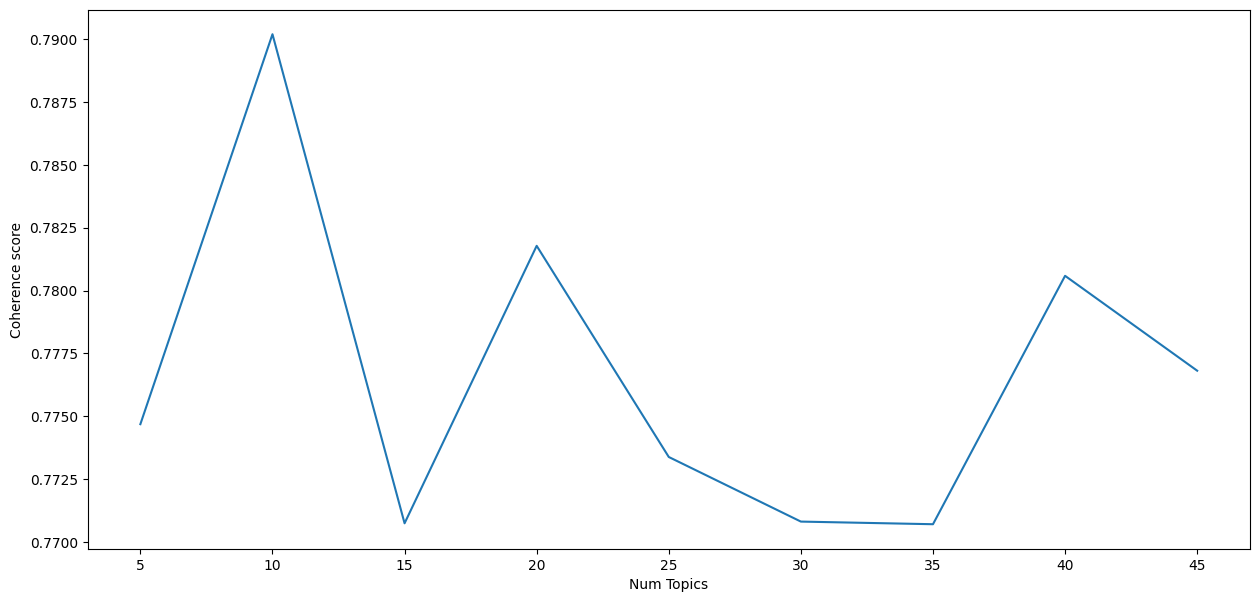

In [ ]:
x = range(min_topic, max_topic, step)

plt.figure(figsize=(15, 7))

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show()

In [ ]:
for n_topics, coherence in zip(x, coherence_values):
    print(f"Num Topics = {n_topics}, Coherence = {coherence:.3f}")

Num Topics = 5, Coherence = 0.775
Num Topics = 10, Coherence = 0.790
Num Topics = 15, Coherence = 0.771
Num Topics = 20, Coherence = 0.782
Num Topics = 25, Coherence = 0.773
Num Topics = 30, Coherence = 0.771
Num Topics = 35, Coherence = 0.771
Num Topics = 40, Coherence = 0.781
Num Topics = 45, Coherence = 0.777


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Берем 30 тем и строим модель латентного размещения Дирихле
lda_model_ben = LatentDirichletAllocation(
    # кол-во тем
    n_components=25,
    max_iter=10,
    learning_method='online',
    random_state=RAND,
    n_jobs=-1,
)
lda_model_ben.fit(train_vec_ben)
print(lda_model_ben)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_method='online', n_components=25, n_jobs=-1,
                          random_state=10)


In [ ]:
get_coherence_mean(lda_model_ben, test_lst)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.7733793823824073

In [ ]:
pyLDAvis.enable_notebook()

panel = pyLDAvis.lda_model.prepare(lda_model_ben,
                                 test_vec_ben,
                                 vector_ben,
                                 mds='tsne')
panel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
21    -30.471926 -67.665413       1        1  19.420656
3      88.059868   0.152141       2        1  15.796109
10     55.875687 -16.083527       3        1   8.059699
1      31.050222 -35.411915       4        1   5.949689
6     -63.334454  32.490196       5        1   5.695659
0      57.225639  17.627409       6        1   4.743989
20    -28.257734  29.891014       7        1   3.293542
5       7.234425 -81.846893       8        1   3.274385
16    -47.120869  -1.775796       9        1   3.041383
14    -37.732197  63.580269      10        1   2.718404
12     35.951500  69.992920      11        1   2.703668
9       5.040003  18.560457      12        1   2.664333
11     72.969688 -44.999687      13        1   2.652683
24    -26.489092 -30.608917      14        1   2.613225
15     -1.236553  82.078415      15        1   2.526142
7      69.945297  49.073864      16        1   2.472525
4      -0.806014  48.916092      17        1   2.262238
17      5.577586 -17.459856      18        1   2.105497
23    -17.572475   0.227958      19        1   1.616692
13     30.898148  36.530231      20        1   1.417118
19     41.756889 -66.973145      21        1   1.346607
8     -58.911278 -41.659706      22        1   1.270427
2     -79.292770  -7.090215      23        1   1.145083
18     29.267389   1.068513      24        1   0.842006
22      1.012539 -48.614361      25        1   0.368239, topic_info=             Term        Freq       Total Category  logprob  loglift
1898        фильм  242.000000  242.000000  Default  30.0000  30.0000
1544        сезон   37.000000   37.000000  Default  29.0000  29.0000
1560       сериал  110.000000  110.000000  Default  28.0000  28.0000
1076        оскар   23.000000   23.000000  Default  27.0000  27.0000
1626      собрать   31.000000   31.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1203     подарить    0.008824    2.233565  Topic25  -8.0230   0.0704
1738        сцена    0.008824   11.802051  Topic25  -8.0231  -1.5944
526     запустить    0.008823    3.325910  Topic25  -8.0232  -0.3279
537       звучать    0.008823    1.928887  Topic25  -8.0232   0.2169
532   захватывать    0.008821    3.158889  Topic25  -8.0234  -0.2766

[1202 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0        19  0.562138     amazon
2         4  0.912775   bookmate
3        20  0.798827       bros
4        20  0.898671     bubble
5         3  0.548459         by
...     ...       ...        ...
2058     22  0.295761  янковский
2060      8  0.196646   японский
2060     23  0.786586   японский
2061      9  0.507394      яркий
2061     10  0.253697      яркий

[1629 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 4, 11, 2, 7, 1, 21, 6, 17, 15, 13, 10, 12, 25, 16, 8, 5, 18, 24, 14, 20, 9, 3, 19, 23])

**Выводы**

Данная модель очень сложна для интерпретации, были разные попытки поработать с гиперпараметрами, но не получилось.

#### Подход 2: вручную + NMF

**Описание подхода**

Подход заключался в следующем:
- Вручную смотрим на тексты и определяем темы, далее для постов, для которых не удалось определить тему строим NMF, смотрим на темы и пытаемся их далее внести в список вручную. И так много-много раз. В результате у 410 постов не удалось установить тему.

In [ ]:
# Функция для извлечения хэштегов
def extract_and_format_hashtags(text):
    hashtags = re.findall(r'#\w+', text) if pd.notna(text) else []
    return ', '.join(hashtags) if hashtags else pd.NA

# Применяем функцию к столбцу 'text' и создаем новый столбец 'hashtags'
merged_df['hashtags1'] = merged_df['text'].apply(lambda x: extract_and_format_hashtags(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df['hashtags1'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#коротыше                                     57
#коротыш                                      53
#Оскар2023                                    31
#Дождались                                    19
#КП100ВеликихФильмов                          17
#Венеция2023                                  10
#КПитоги23                                     9
#летоскинопоиском                              9
#Канны2023                                     7
#Подслушано                                    7
#ДежурныйПоКинопоиску                          6
#КПИтогиГода2023                               4
#КиноПоПятницам                                4
#ДайджестНовостей                              4
#НейроКП                                       2
#ИтогиКП2023                                   2
#ГостьКинопоиска                               2
#мартимертв, #мартимертв____                   1
#коротыше, #КП100ВеликихФильмов                1
#малкович                                      1
#скажимиядзаки, #мал

In [ ]:
# Сделаем словарь на основе этих хештегов и добавим темы вручную

def find_hashtag(text):
    # Проверяем каждый хэштег
    for hashtag in ['#коротыше', '#коротыш', '#Оскар2023', '#Дождались', '#КП100ВеликихФильмов', '#Венеция2023',
                   '#КПитоги23', '#летоскинопоиском', '#Канны2023', '#Подслушано', '#ДежурныйПоКинопоиску',
                   '#КПИтогиГода2023', '#КиноПоПятницам', '#ДайджестНовостей', '#НейроКП', '#ИтогиКП2023',
                   '#ГостьКинопоиска', '#мартимертв', '#мартимертв____', '#малкович', '#скажимиядзаки',
                   '#кп_новоеимя', '#ВсейСемьей', '#КП100ВеликихИгр', '#РейтингФильмографии', '#КиномемКП',
                   '#ЛетоСКинопоиском', '#летоскинопоиском' '#песочетверг', '#Кинопанорама']:
        # Если хэштег найден в тексте, возвращаем его
        if hashtag in text:
            return hashtag
        else:
            # Если не нашли хэштег, проверяем остальные условия
            pattern = r"сегодня\s\d+\sлет"
            if re.search(pattern, text):
                return 'день рождения'
            if 'исполнилось' in text and 'лет' in text or 'празднует' in text:
                return 'день рождения'
            if 'подкаст' in text.lower() or 'podcast' in text.lower():
                return 'подкаст'
            if 'видеоэссе' in text.lower():
              return 'видеоэссе'
            if 'соцсети' in text.lower():
              return 'фото из соцсетей звезд'
            pattern = r"Станислав(?:а|у|е|ы|ой)? Зельвенск(?:ий|ого|ому|им|ом)?"
            if re.search(pattern, text):
              return 'Станислав Зельвенский'
            if 'рецензи' in text.lower():
              return 'рецензии'
            if 'карточках' in text or 'наши карточки' in text:
              return 'карточки'
            if 'букмейт' in text.lower():
              return 'букмейт'
            if 'Экстра' in text:
              return 'кинопоиск экстра (youtube)'
            if 'На Кинопоиске выш' in text:
              return 'новое на Кинопоиске'
            if 'пересматр' in text.lower():
                return 'пересматриваем'
            if 'провал' in text:
              return 'провал'
            pattern = r"Майор[уеаыа] Гром[уеаыа]?и?"
            if re.search(pattern, text):
              return 'майор гром'
            if 'майор' in text.lower() and 'гром' in text.lower():
              return 'майор гром'
            if 'Гром' in text:
              return 'майор гром'
            if 'слово' and 'пацан' in text.lower():
              return 'слово пацана'
            pattern = r"титанов"
            if re.search(pattern, text):
              return 'атака титанов'

            if 'трейлер' in text or 'Трейлер' in text:
              return 'трейлер'
            if 'премьер' in text or 'Премьер' in text or 'постер' in text:
              return 'премьера'
            if 'сериал' and 'вышел' in text.lower():
              return 'анонс сериала'
            if 'киноблиц' in text.lower():
              return 'киноблиц'

            if 'дайджест' in text:
              return 'дайджест'
            if 'в Плюсе' in text or 'В плюсе' in text:
              return 'плюс'
            if 'путеводител' in text.lower():
              return 'путеводитель'
            if 'оскар' in text or 'преми' in text or ('золот'  and 'глобус') in text.lower() or 'номинац' in text or 'канн' in text.lower() or 'наград' in text.lower() or 'церемон' in text.lower():
              return 'премии'
            if 'Гарри' in text and 'Поттер' in text:
              return 'гарри поттер'
            if 'marvel' in text or 'Марвел' in text or 'Marvel' in text:
              return 'марвел'
            if 'Фандорин' in text:
              return 'фандорин. азазель'
            if 'Тед' in text and 'Лассо' in text:
              return 'тед лассо'
            if 'Миядзаки' in text:
              return 'Миядзаки'
            if 'Джон Уик' in text or 'Киану Ривз' in text or 'Джона Уика' in text:
              return 'джон уик'
            pattern = r"Пищеблок[уеаы]?и?"
            if re.search(pattern, text):
              return 'пищеблок'
            if 'Кибердеревн' in text or 'кибердеревн' in text:
              return 'кибердеревня'
            if 'Триггер' in text or 'триггер' in text:
              return 'триггер'
            if 'Джейсон' in text and 'Стэйтем' in text:
              return 'Джейсон Стэйтем'
            if (('Оппенгеймер' in text or 'оппенгеймер' in text) and ('барби' in text or 'Барби' in text)) or 'Барбигеймер' in text or 'барбигеймер' in text:
              return 'барбигеймер'
            if 'барби' in text or 'Барби' in text:
              return 'барби'
            if 'Оппенгеймер' in text or 'оппенгеймер' in text:
              return 'опенгеймер'
            if 'Нолан' in text:
              return 'Нолан'
            if "Мартин" in text and 'Скорсезе' in text:
              return 'мартин скорсезе'
            if "Ричи" in text:
              return 'Гай Ричи'
            if 'аватар' in text.lower():
              return 'аватар'
            if 'Переводчик' in text and 'Ричи' in text:
              return 'переводчик'
            if 'Король' in text and 'Шут' in text or 'Короля и Шута' in text:
              return 'король и шут'
            if 'Цикад' in text or 'цикад' in text:
              return 'цикады'
            if 'Кинопоиск | Индустрия' in text or 'промо' in text.lower() or 'съемк' in text.lower() or 'может сыграть' in text.lower() or 'интервью' in text.lower():
              return 'кинопоиск индустрия'
            if '«Кинопоиск | Игры»' in text:
              return 'кинопоиск игры'
            if 'комментариях' in text or 'комментах' in text:
              return 'конкурс или общение с подписчиками, вопросы актерам'
            if 'ждем' in text or 'Ждем' in text:
              return 'ждем (возможно кинопоиска канал)'
            if 'Мультфильм дня' in text:
              return 'мультфильм дня'
            if 'сезон' in text.lower():
              return 'анонс сезона'
            if 'онлайн-новинк' in text or 'онлайн-релиз' in text:
              return 'онлайн-новинки'
            if 'что нового' in text or 'новинк' in text.lower():
              return 'рекомендации новинок'
            if re.search(r'\bумер(ла)?\b', text, re.IGNORECASE):
              return 'новости о смерти'
            if 'сериал недели' in text.lower():
              return 'сериал недели'
            if 'сериал дня' in text.lower():
              return 'сериал дня'
            if 'фильм дня' in text.lower():
              return 'фильм дня'
            if 'фильм на вечер' in text.lower():
              return 'фильм на вечер'
            if 'вспоминаем' in text.lower() or 'лет назад' in text.lower() or ('спустя' and 'лет' in text.lower()):
              return 'вспоминаем'
            if 'подборк' in text or 'составили' in text.lower() or 'отобрали' in text.lower() or 'что смотреть на этой неделе' in text.lower() or 'топ' in text.lower() and ('сериал' in text.lower() or 'фильм' in text.lower()):
              return 'подборка'
            if 'прокат' in text:
              return 'выход в прокат'
            if 'посмотреть дома' in text or 'что посмотреть' in text.lower():
              return 'что посмотреть дома'
            if 'культов' in text.lower():
              return 'культовое кино'
            if 'разбираем' in text.lower() or 'материале' in text.lower() or 'рассказываем' in text.lower():
              return 'кинопоиск разбирает и рассказывает (ссылка на статью)'

            if 'поздравл' in text or 'Поздравл' in text:
              return 'поздравления'

    return np.nan

# Добавляем новое поле с темой поста
merged_df['topic1'] = merged_df['text'].apply(find_hashtag)

# Если хэштег не найден, записываем "нет темы"
merged_df['topic1'].fillna('нет темы', inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df['topic1'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['трейлер', 'карточки', 'анонс сериала', 'майор гром', 'премьера',
       'пересматриваем', 'кинопоиск экстра (youtube)', 'марвел',
       'кинопоиск индустрия', 'подкаст', 'видеоэссе',
       'кинопоиск разбирает и рассказывает (ссылка на статью)', 'провал',
       'рецензии', 'новое на Кинопоиске', 'фандорин. азазель',
       'фото из соцсетей звезд', 'выход в прокат', 'премии',
       'Джейсон Стэйтем', 'Станислав Зельвенский', 'аватар', 'киноблиц',
       'подборка', 'конкурс или общение с подписчиками, вопросы актерам',
       'анонс сезона', 'нет темы', 'путеводитель', 'новости о смерти',
       'букмейт', 'вспоминаем', 'Гай Ричи', 'культовое кино',
       'ждем (возможно кинопоиска канал)', 'атака титанов', 'джон уик',
       'тед лассо', 'Нолан', 'король и шут', 'дайджест', 'онлайн-новинки',
       'плюс', 'рекомендации новинок', 'что посмотреть дома',
       'день рождения', 'гарри поттер', 'мартин скорсезе', '#коротыше',
       '#Оскар2023', '#коротыш', '#КиномемКП', 'с

In [ ]:
merged_df['topic1'].value_counts().reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


index  topic1
0                                            нет темы     410
1                                            премьера     131
2   кинопоиск разбирает и рассказывает (ссылка на ...     128
3                                              премии     124
4                               Станислав Зельвенский     123
..                                                ...     ...
70                                         сериал дня       1
71                                           #НейроКП       1
72                                       #Венеция2023       1
73                                         #КПитоги23       1
74                                       поздравления       1

[75 rows x 2 columns]

In [ ]:
merged_df.loc[merged_df['topic1']=='кинопоиск разбирает и рассказывает (ссылка на статью)']['text'].values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Прилично серьезному человеку смотреть реалити, где все орут или маются дурью? Вот мы считаем, что да. \n\nВ порядке увеличения градуса кринжа [рассказываем](https://www.kinopoisk.ru/media/article/4007235/) про 12\xa0увлекательных шоу, которые можно посмотреть на\xa0Кинопоиске.',
       'Сатирический триллер «Меню» — один из самых любопытных фильмов прошлого года, высмеивающий фуди-культуру.\n\nКоротко рассказываем о нем в рубрике «В фокусе».',
       'Постучись в мою дверь, Мажор. \n\nВ\xa0новом исследовании Индекса Кинопоиск Pro [рассказываем](https://www.kinopoisk.ru/media/article/4007314/?utm_source=telegram&utm_medium=social) о\xa0том, какими сериалами интересовались и\xa0что смотрели жители России в январские каникулы и\xa0в\xa0декабре 2022\xa0года.',
       'Это случилось: на HBO Max стартовал сериал «Одни из нас» (18+).\xa0\n\nО чем он? Как снят? Получилось ли у создателей воссоздать атмосферу видеоигры-первоисточника? И что о сериале пишут первые зрители?\xa0\n\nЧитайте

In [ ]:
# Создаем словарь для нормализации тем
normalized_topics = {
    '#коротыше': 'коротыш',
    '#коротыш': 'коротыш',
    '#Оскар2023': 'оскар',
    '#Дождались': 'дождались',
    '#КП100ВеликихФильмов': 'кп великие фильмы',
    '#КПитоги23': 'итоги кп',
    '#летоскинопоиском': 'лето с кинопоиском',
    '#Венеция2023': 'венеция',
    '#Канны2023': 'канны',
    '#Подслушано': 'подслушано',
    '#ДежурныйПоКинопоиску': 'дежурный по кинопоиску',
    '#КПИтогиГода2023': 'итоги кп',
    '#КиноПоПятницам': 'кино по пятницам',
    '#ДайджестНовостей': 'дайджест новостей',
    '#НейроКП': 'нейро кп',
    '#ИтогиКП2023': 'итоги кп',
    '#ГостьКинопоиска': 'гость кинопоиска',
    '#мартимертв': 'марти мертв',
    '#мартимертв____': 'марти мертв',
    '#малкович': 'малкович',
    '#скажимиядзаки': 'скажи миядзаки',
    '#мальчикиптица': 'скажи миядзаки',  # Предполагаем нормализацию к теме 'скажимиядзаки'
    '#кп_новоеимя': 'кп новое имя',
    '#Оскар2023, #коротыше': 'оскар, коротыш',
    '#КП100ВеликихФильмов, #КП100ВеликихФильмов': 'кп великие фильмы',
    '#коротыше, #Оскар2023': 'коротыш, оскар',
    '#КП100ВеликихИгр': 'кп великие игры',
    '#РейтингФильмографии': 'рейтинг фильмографии',
    '#КиномемКП': 'киномем кп',
    '#ЛетоСКинопоиском': 'лето с кинопоиском',
    '#песочетверг': 'песочетверг',
    '#Кинопанорама': 'кинопанорама',
    '#ВсейСемьей': 'всей семьей',
    'мультфильм дня': 'мультфильм дня',
    'сериал недели': 'сериал недели',
    'фильм дня': 'фильм дня',
    'фильм на вечер': 'фильм на вечер',
    'карточки': 'карточки',
    'дайджест': 'дайджест',
    'видеоэссе': 'видеоэссе',
    'что посмотреть дома': 'что посмотреть дома',
    'Станислав Зельвенский': 'критик Зельвенский',
    'подкаст': 'подкаст',
    'трейлер': 'трейлер',
    'премьера': 'премьера',
    'онлайн-новинки': 'онлайн-новинки',
    'кинопоиск индустрия': 'кинопоиск индустрия',
    'подборка': 'подборка',
    'премии': 'премии',
    'конкурс или общение с подписчиками, вопросы актерам': 'конкурс или общение с подписчиками',
    'гарри поттер': 'гарри поттер',
    'марвел': 'marvel',
    'фандорин. азазель': 'фандорин_азазель',
    'Миядзаки': 'миядзаки',
    'цикады': 'цикады',
    'джон уик': 'джон уик',
    'барбигеймер': 'барбигеймер',
    'пищеблок': 'пищеблок',
    'барби': 'барби',
    'король и шут': 'король и шут',
    'опенгеймер': 'опенгеймер',
    'кинопоиск индустрия': 'кинопоиск индустрия',
    'Нолан': 'нолан',
    'переводчик': 'переводчик',
    'выход в прокат': 'выход в прокат',
    'поздравления': 'поздравления',
    'майор гром': 'майор гром',
    'день рождения': 'день рождения',
    'атака титанов': 'атака титанов',
    'плюс': 'плюс',
    'путеводитель': 'путеводитель',
    'кибердеревня': 'кибердеревня',
    'тед лассо': 'тед лассо',
    'Джейсон Стэйтем': 'Джейсон Стэйтем',
    'триггер': 'триггер',
    'рекомендации новинок': 'рекомендации новинок',
    'ждем (возможно кинопоиска канал)': 'ждем (возможно кинопоиска канал)',
    'анонс сезона': 'анонс сезона',
    'провал': 'провал',
    'кинопоиск игры': 'кинопоиск игры',
    'мартин скорсезе': 'мартин скорсезе',
    'аватар': 'аватар',
    'букмейт': 'букмейт',
    'пересматриваем': 'пересматриваем',
    'кинопоиск экстра (youtube)': 'кинопоиск экстра (youtube)',
    'Гай Ричи': 'Гай Ричи',
    'новое на Кинопоиске': 'новое на Кинопоиске',
    'новости о смерти': 'новости о смерти',
    'вспоминаем': 'вспоминаем',
    'культовое кино': 'культовое кино',
    'сериал дня': 'сериал дня',
    'рецензии': 'рецензии',
    'фото из соцсетей звезд': 'фото из соцсетей звезд',
    'анонс сериала': 'анонс сериала',
    'киноблиц': 'киноблиц',
    'слово пацана': 'слово пацана',
    'кинопоиск разбирает и рассказывает (ссылка на статью)': 'кинопоиск разбирает'
}


def find_normalize_topic(topic):
    for key in normalized_topics.keys():
        if key in topic:
            return normalized_topics[key]
    return 'нет темы'

# Добавляем новое поле "тема поста"
merged_df['n_topic'] = merged_df['topic1'].apply(find_normalize_topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# создаем df, в котором посты без тем
no_topics = merged_df[merged_df['n_topic'] == 'нет темы']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Подготовка данных
X_train, X_test = train_test_split(no_topics['lemm1'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Применение NMF
num_topics = 12
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(X_train_vec)

# Вывод слов для каждой темы
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic_words in enumerate(nmf.components_):
    top_words_idx = topic_words.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1: фильм, ожидать, андрей, история, обожать, скотт, снять, прочь, франшиза, кстати
Topic 2: классный, сторис, telegram, подписчик, поддерживать, дорогой, показать, приготовить, жмякнуть, кой
Topic 3: узнать, молодой, тысяча, основный, королева, winter, kevin, феррари, киноман, честь_юбилей
Topic 4: любимый, вселенная, проведение, фраза, юный, забыть, прощать, чендлера, форсаж, песня
Topic 5: актёр, режиссёр, кино, снимать, драма, бен, рассказать, снять, эрина, родитель
Topic 6: сериал, шоу, обзор, плохой, советовать, tv, вселенная, проект, выход, сцена
Topic 7: прямо, плюс, прийти, просмотр, малхолланд_драйв, ла, обсуждать, ленд, великий, прямой
Topic 8: игра, the, выбрать, пройти, клёвый, ссылка, экранизация, кино_мечта, звёздный, хайрула
Topic 9: кадр, описать, возвращаться, сиквел, настроение, выходной, план, неделя, опубликовать, роль
Topic 10: гений, winter, kevin, готовый, новость, грустный, франшиза, хватить, подождать, фанат
Topic 11: легенда, рождение, джек, семья, шедев

Далее сложно интрепретировать модель nmf, в результате не удалось присовоить темы 410 словам.

In [ ]:
merged_df['n_topic'].value_counts().reset_index() # В результате получилось так

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


index  n_topic
0              нет темы      410
1              премьера      131
2   кинопоиск разбирает      128
3                премии      124
4    критик Зельвенский      123
..                  ...      ...
69           сериал дня        1
70             нейро кп        1
71              венеция        1
72             итоги кп        1
73         поздравления        1

[74 rows x 2 columns]

In [ ]:
# Теперь отберем наиболее большие темы и посмотрим, если между ними стат. значимость по просмотрам, репостам, количеству реакций и комментариям.

topic_a_data = merged_df[merged_df['n_topic'] == 'нет темы']
topic_b_data = merged_df[merged_df['n_topic'] == 'премьера']
topic_c_data = merged_df[merged_df['n_topic'] == 'критик Зельвенский']
topic_d_data = merged_df[merged_df['n_topic'] == 'кинопоиск разбирает']
topic_e_data = merged_df[merged_df['n_topic'] == 'премии']

# Применяем тест Краскела-Уоллиса для каждого параметра, так как распределение не нормальное
for param in ['views', 'forwarded', 'reactions_count', 'comments']:
    h_statistic, p_value = kruskal(topic_a_data[param], topic_b_data[param],
                                    topic_c_data[param], topic_d_data[param], topic_e_data[param])
    print(f"Тест Краскела-Уоллиса для параметра '{param}':")
    print("H-статистика:", h_statistic)
    print("p-значение:", p_value)
    print()


Тест Краскела-Уоллиса для параметра 'views':
H-статистика: 16.987433061839795
p-значение: 0.001943846826609505

Тест Краскела-Уоллиса для параметра 'forwarded':
H-статистика: 9.322792945729487
p-значение: 0.05351860736001881

Тест Краскела-Уоллиса для параметра 'reactions_count':
H-статистика: 162.48612927345297
p-значение: 4.2823742651581665e-34

Тест Краскела-Уоллиса для параметра 'comments':
H-статистика: 45.44239313728468
p-значение: 3.2169647369276163e-09



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Статистически значимые различия обнаружены, различия между темами по просмотрам, комментариям, репостам и реакциям есть

In [ ]:
# проверим количество реакций, так как H-статистика самая высокая

# Соберем все данные в один массив
all_data = pd.concat([topic_a_data, topic_b_data, topic_c_data, topic_d_data])

# Добавим столбец с группами
all_data['group'] = ['A'] * len(topic_a_data) + ['B'] * len(topic_b_data) + ['C'] * len(topic_c_data) + ['D'] * len(topic_d_data)

# Выполним множественные сравнения с помощью метода Тьюки
tukey_results = pairwise_tukeyhsd(all_data['reactions_count'], all_data['group'])

print(tukey_results)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
     A      B -161.5993 0.0207 -305.6523  -17.5463   True
     A      C -442.3008    0.0 -589.8614 -294.7402   True
     A      D  -400.939    0.0 -546.2657 -255.6123   True
     B      C -280.7015 0.0004 -460.9119 -100.4911   True
     B      D -239.3397 0.0033 -417.7256  -60.9538   True
     C      D   41.3618 0.9358 -139.8684   222.592  False
---------------------------------------------------------


In [ ]:
topic_a_data['reactions_count'].mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


699.439024390244

In [ ]:
topic_b_data['reactions_count'].mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


537.8396946564885

In [ ]:
topic_c_data['reactions_count'].mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


257.1382113821138

In [ ]:
topic_d_data['reactions_count'].mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


298.5

**выводы**

К сожалению, отсутствие темы влияет сильно и среднее по количеству реакций статистически значимо выше по сравнению с другими группами.

## Анализ реакций по постам

In [ ]:
# выделим отдельно id постов и реакции
reactions_df = merged_df[['id', 'reactions']]

# напишем функцию, которая извлечет из каждого поста реакции
# и создаст датафрейм df c колонками в виде каждого извлеченного символа

## Создание пустого списка для данных о реакциях
reactions_data = []

for post_id, reactions_json in zip(reactions_df['id'], reactions_df['reactions']):
    if not reactions_json:  # Если строка пустая, добавить пустой словарь в reactions_data
        reactions_data.append({'Post_ID': post_id})
        continue

    try:
        reactions_dict = ast.literal_eval(reactions_json)  # Безопасно вычисляем строковое выражение Python
        reactions = reactions_dict['results']
    except (ValueError, KeyError) as e:
        print(f"Error processing JSON: {e}")
        continue  # Продолжить обработку следующей строки данных

    # Создание словаря для хранения данных о реакциях для данного поста
    post_reactions = {'Post_ID': post_id}
    # Проход по каждой реакции и добавление данных в словарь
    for reaction in reactions:
        emoticon = reaction['reaction']['emoticon']
        count = reaction['count']
        post_reactions[emoticon] = count
    # Добавление словаря в список данных о реакциях
    reactions_data.append(post_reactions)
df = pd.DataFrame(reactions_data)

Error processing JSON: malformed node or string: nan


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Error processing JSON: malformed node or string: nan
Error processing JSON: malformed node or string: nan
Error processing JSON: malformed node or string: nan
Error processing JSON: malformed node or string: nan


In [ ]:
# проверим, какие значения эмодзи выделились в колонки
df.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Post_ID', '👎', '👍', '🤔', '🔥', '❤', '😱', '👏', '🤬', '🤣', '❤‍🔥', '⚡', '🥱',
       '🎉', '💔', '🕊', '🌭', '😐', '🥰', '🍾', '🎄', '☃', '🎅', '😁', '🤯', '💯', '😢',
       '😍', '🤩', '🙏', '👌', '👀', '🍓', '🌚', '🍌', '🐳', '💅', '💋', '🗿', '💘', '🏆',
       '😈', '🤗', '🤝', '🤪', '😴', '🆒', '🙈', '👾', '😭', '👻', '😎', '🎃', '🦄', '😘'],
      dtype='object')

In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Post_ID      👎      👍     🤔      🔥      ❤    😱    👏    🤬    🤣  ...   😴   🆒  \
0    31135  163.0  115.0  20.0   18.0    9.0  7.0  2.0  2.0  2.0  ... NaN NaN   
1    31151   76.0   96.0   NaN    4.0  439.0  5.0  NaN  NaN  NaN  ... NaN NaN   
2    31150  152.0   41.0  13.0    3.0   52.0  NaN  NaN  NaN  NaN  ... NaN NaN   
3    31136   33.0  289.0   6.0   22.0   48.0  NaN  NaN  NaN  NaN  ... NaN NaN   
4    31147   60.0   51.0   NaN  331.0   46.0  NaN  2.0  NaN  NaN  ... NaN NaN   

    🙈   👾   😭   👻   😎   🎃   🦄   😘  
0 NaN NaN NaN NaN NaN NaN NaN NaN  
1 NaN NaN NaN NaN NaN NaN NaN NaN  
2 NaN NaN NaN NaN NaN NaN NaN NaN  
3 NaN NaN NaN NaN NaN NaN NaN NaN  
4 NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 55 columns]

In [ ]:
# объединим наши данные по просмотрам, комментариям, реакциям и репостам с полученными эмодзи
merged_df = df.merge(merged_df, left_on='Post_ID', right_on='id', how='left')

merged_df.drop('Post_ID', axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# проверим результат
merged_df.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


👎      👍     🤔     🔥      ❤    😱    👏    🤬    🤣   ❤‍🔥  ...  changes  \
0  163.0  115.0  20.0  18.0    9.0  7.0  2.0  2.0  2.0   1.0  ...     1337   
1   76.0   96.0   NaN   4.0  439.0  5.0  NaN  NaN  NaN  30.0  ...     1337   

   new_subscribers  unsubscribed                               categories  \
0             1214           -32  Кинопоиск медиа/новости, Кинопоиск ютуб   
1             1214           -32                         Кинопоиск фильмы   

                                            pre_text  \
0  вышел первый трейлер фильма вызов клима шипенк...   
1  дождались на кинопоиске вышел гром трудное дет...   

                                               lemm1  \
0  трейлер фильм вызов клим шипенко ради режиссёр...   
1  дождаться гром_трудный_детство полнометражный ...   

                                           lemm_text  hashtags1    topic1  \
0  [трейлер, фильм, вызов, клим, шипенко, ради, р...       <NA>   трейлер   
1  [дождаться, гром_трудный_детство, полнометражн...       <NA>  карточки   

    n_topic  
0   трейлер  
1  карточки  

[2 rows x 77 columns]

In [ ]:
# проверим все названия колонок
merged_df.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['👎', '👍', '🤔', '🔥', '❤', '😱', '👏', '🤬', '🤣', '❤‍🔥', '⚡', '🥱', '🎉', '💔',
       '🕊', '🌭', '😐', '🥰', '🍾', '🎄', '☃', '🎅', '😁', '🤯', '💯', '😢', '😍', '🤩',
       '🙏', '👌', '👀', '🍓', '🌚', '🍌', '🐳', '💅', '💋', '🗿', '💘', '🏆', '😈', '🤗',
       '🤝', '🤪', '😴', '🆒', '🙈', '👾', '😭', '👻', '😎', '🎃', '🦄', '😘', 'id',
       'datetime', 'text', 'views', 'reactions', 'with_media', 'forwarded',
       'replies', 'reactions_count', 'comments', 'type_attachment', 'date_YMD',
       'total_subscribers', 'changes', 'new_subscribers', 'unsubscribed',
       'categories', 'pre_text', 'lemm1', 'lemm_text', 'hashtags1', 'topic1',
       'n_topic'],
      dtype='object')

In [ ]:
# выделим в переменную top_emoji данные по самым популярным эмодзи
top_emoji = merged_df[['👎', '👍', '🤔',
       '🔥', '❤', '😱', '👏', '🤬', '🤣', '❤‍🔥', '⚡', '🥱', '🎉', '💔', '🕊', '🌭', '😐',
       '🥰', '🍾', '🎄', '☃', '🎅', '😁', '🤯', '💯', '😢', '😍', '🤩', '🙏', '👌', '👀',
       '🍓', '🌚', '🍌', '🐳', '💅', '💋', '🗿', '💘', '🏆', '😈', '🤗', '🤝', '🤪', '😴',
       '🆒', '🙈', '👾', '😭', '👻', '😎', '🎃', '🦄', '😘']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_emoji.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


👎      👍     🤔      🔥      ❤    😱    👏    🤬    🤣   ❤‍🔥  ...   😴   🆒  \
0  163.0  115.0  20.0   18.0    9.0  7.0  2.0  2.0  2.0   1.0  ... NaN NaN   
1   76.0   96.0   NaN    4.0  439.0  5.0  NaN  NaN  NaN  30.0  ... NaN NaN   
2  152.0   41.0  13.0    3.0   52.0  NaN  NaN  NaN  NaN   NaN  ... NaN NaN   
3   33.0  289.0   6.0   22.0   48.0  NaN  NaN  NaN  NaN   NaN  ... NaN NaN   
4   60.0   51.0   NaN  331.0   46.0  NaN  2.0  NaN  NaN   4.0  ... NaN NaN   

    🙈   👾   😭   👻   😎   🎃   🦄   😘  
0 NaN NaN NaN NaN NaN NaN NaN NaN  
1 NaN NaN NaN NaN NaN NaN NaN NaN  
2 NaN NaN NaN NaN NaN NaN NaN NaN  
3 NaN NaN NaN NaN NaN NaN NaN NaN  
4 NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 54 columns]

In [ ]:
# вычислим сумму по каждому из эмодзи
top_emoji = top_emoji.sum().sort_values(ascending=False).reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [ ]:
# переименуем колонки
top_emoji.columns = ['name', 'cnt']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# посчитаем доля каждого из эмодзи
top_emoji['percentage'] = top_emoji['cnt'].apply(lambda x: round(x / top_emoji['cnt'].sum() * 100))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# выведем топ-10 реакций, которые ставят к постам
top_emoji.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


name       cnt  percentage
0    ❤  480682.0          33
1    👍  338583.0          23
2    👎  145732.0          10
3    🔥  120565.0           8
4  ❤‍🔥  114106.0           8
5    😢   43641.0           3
6    😁   32105.0           2
7    💔   23865.0           2
8    🎉   14507.0           1
9    🐳   13274.0           1

Анализ эмодзи показал следущее:  
- У постов **больше позитивных** реакций, чем негативных: среди топ-10 реакций всего 3 можно интерпретировать как негативные  
- Больше всего ставят сердечек (треть реакций)
- На втром месте реакция палец вверх (23% от всех эмоджи)
- На третьем - палец вниз (10%)

In [ ]:
top_emoji_list = top_emoji['name'].to_list()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Создание нового DataFrame с выбранными столбцами и добавлением столбца с датой
new_df = merged_df[['datetime'] + top_emoji_list].copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
new_df['date_my'] = pd.to_datetime(new_df['datetime']).dt.to_period('m')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
new_df_filtered = new_df[new_df['date_my'].astype(str) > '2023-01']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
new_df_filtered.groupby('date_my').sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


❤        👍        👎        🔥      ❤‍🔥       😢       😁       💔  \
date_my                                                                        
2023-02  24156.0  25762.0   5223.0   8232.0   8115.0  1961.0  2505.0   520.0   
2023-03  43197.0  38831.0  10732.0  11011.0  13756.0   443.0  2716.0  4836.0   
2023-04  36660.0  20520.0   7885.0   8968.0  12303.0     5.0  3126.0  5681.0   
2023-05  35394.0  27688.0  15695.0   8820.0   6231.0  2548.0  2315.0  2841.0   
2023-06  32954.0  20047.0  12198.0  11552.0   7987.0  4771.0  1298.0  1354.0   
2023-07  31859.0  25735.0   8076.0   5670.0   7498.0  2003.0  5413.0   302.0   
2023-08  36944.0  20757.0  12253.0   7311.0   7826.0  7719.0  1223.0  1127.0   
2023-09  38941.0  29635.0  16692.0  10536.0   7346.0  3238.0  1897.0  1473.0   
2023-10  42592.0  26566.0  15980.0  10768.0   7494.0  8026.0  2302.0  2571.0   
2023-11  46231.0  29075.0  15534.0   8075.0   9896.0  1463.0  1724.0   653.0   
2023-12  52876.0  24347.0  10932.0  11185.0   7847.0  1760.0  2831.0   552.0   
2024-01  34301.0  20284.0   6474.0   9453.0   7450.0    92.0  1575.0   763.0   

              🎉       🐳  ...     🙈      🤝     🎃     🏆     👾     🤗     😴     🎅  \
date_my                  ...                                                    
2023-02   274.0     0.0  ...   0.0    0.0   0.0   0.0   0.0   0.0   0.0  14.0   
2023-03  1305.0   199.0  ...   0.0    0.0   0.0   0.0   0.0   0.0   0.0   4.0   
2023-04   261.0  1389.0  ...   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2023-05  1797.0  1122.0  ...   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2023-06  3494.0  1230.0  ...   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2023-07  2402.0  1182.0  ...   0.0    0.0   0.0   1.0   0.0   0.0   0.0   0.0   
2023-08  1236.0  2020.0  ...   0.0    1.0   0.0   0.0   0.0   1.0   0.0   0.0   
2023-09  1786.0  1225.0  ...   0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2023-10   799.0  1484.0  ...  91.0  102.0   0.0   0.0  36.0   0.0  65.0   0.0   
2023-11   331.0  1477.0  ...  47.0   11.0  28.0  43.0  44.0  48.0  11.0   0.0   
2023-12   432.0  1222.0  ...   0.0   18.0  62.0  26.0   0.0  20.0   0.0   0.0   
2024-01     7.0   724.0  ...   0.0    3.0  29.0  41.0   0.0   8.0   0.0   0.0   

            🆒    😘  
date_my             
2023-02   0.0  0.0  
2023-03   0.0  0.0  
2023-04   0.0  0.0  
2023-05   0.0  0.0  
2023-06   0.0  0.0  
2023-07   0.0  0.0  
2023-08   0.0  0.0  
2023-09   0.0  0.0  
2023-10  15.0  0.0  
2023-11   6.0  0.0  
2023-12   0.0  9.0  
2024-01   0.0  4.0  

[12 rows x 54 columns]

Разделим эмодзи на категории по эмоциональной окраске: *позитивные, нейтральные и негативные* и посчитаем их количество:

In [ ]:
# Позитивные эмодзи
positive_emojis = ['👍', '🔥', '❤', '👏', '🤣', '❤‍🔥', '🎉', '🥰', '🍾', '😁', '💯', '😍', '🤩', '🙏', '💋', '💘', '🤗', '🤝', '😘', '👌']

# Негативные эмодзи
negative_emojis = ['👎', '😱', '🤬', '💔', '😢', '🤯', '😐', '🌚', '🗿', '😈']

# Нейтральные эмодзи
neutral_emojis = ['🍓', '🕊', '🌭', '💅', '🆒', '👾', '👀', '🍌', '👻', '🎃', '🐳', '🎄', '☃', '🎅', '🏆', '🦄', '⚡']

def is_emoji_column(column_name):
    return any(emoji in column_name for emoji in positive_emojis + negative_emojis + neutral_emojis)

# Получаем список столбцов, которые являются названиями эмоджи
emoji_columns = [column for column in merged_df.columns if is_emoji_column(column)]

# Выводим список столбцов с названиями эмоджи
print("Столбцы с названиями эмоджи:", emoji_columns)

Столбцы с названиями эмоджи: ['👎', '👍', '🔥', '❤', '😱', '👏', '🤬', '🤣', '❤\u200d🔥', '⚡', '🎉', '💔', '🕊', '🌭', '😐', '🥰', '🍾', '🎄', '☃', '🎅', '😁', '🤯', '💯', '😢', '😍', '🤩', '🙏', '👌', '👀', '🍓', '🌚', '🍌', '🐳', '💅', '💋', '🗿', '💘', '🏆', '😈', '🤗', '🤝', '🆒', '👾', '👻', '🎃', '🦄', '😘']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# напишем функции для подсчета кол-ва эмодзи по категориям
def count_emotions(row):
    positive_count = 0
    negative_count = 0
    neutral_count = 0

    for column_name in row.index:  # Перебираем названия столбцов
        if is_emoji_column(column_name):  # Проверяем, является ли название столбца эмоджи
            emoji_count = row[column_name]  # Получаем количество эмоджи из столбца
            if emoji_count > 0:
                if column_name in positive_emojis:
                    positive_count += emoji_count
                elif column_name in negative_emojis:
                    negative_count += emoji_count
                else:
                    neutral_count += emoji_count

    return pd.Series([positive_count, negative_count, neutral_count])

# Применяем функцию к датафрейму и добавляем новые столбцы
merged_df[['positive_count', 'negative_count', 'neutral_count']] = merged_df.apply(count_emotions, axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.f

In [ ]:
# выведем топ-20 постов по позитивным реакциям
merged_df.sort_values(by='positive_count', ascending=False).head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


👎       👍    🤔       🔥       ❤     😱     👏     🤬   🤣     ❤‍🔥  ...  \
908   230.0     NaN  NaN     NaN  7484.0   NaN   NaN   NaN NaN   138.0  ...   
2457    3.0   362.0  NaN  4181.0  1715.0   NaN   NaN   NaN NaN    20.0  ...   
2638  200.0    91.0  NaN  5507.0   128.0   NaN   9.0   NaN NaN    29.0  ...   
1051  514.0    22.0  NaN     NaN  5578.0   NaN   NaN   NaN NaN     NaN  ...   
1400    NaN  3118.0  NaN    31.0  1498.0   NaN   NaN   NaN NaN     NaN  ...   
697    18.0   405.0  NaN    49.0  3338.0   NaN   NaN   NaN NaN    18.0  ...   
1781  188.0   106.0  NaN    36.0  3645.0   NaN   NaN   NaN NaN   108.0  ...   
2655  914.0  3418.0  NaN     NaN    85.0  10.0   NaN   NaN NaN    41.0  ...   
1702  641.0  3407.0  NaN     4.0    46.0   NaN   NaN   NaN NaN     6.0  ...   
2369   22.0    47.0  NaN     NaN  3122.0   NaN   NaN   NaN NaN    56.0  ...   
2598   17.0  1675.0  NaN   783.0   651.0  25.0   NaN   NaN NaN    28.0  ...   
1225  317.0    88.0  NaN    10.0  2936.0   NaN   NaN   NaN NaN    28.0  ...   
1752   23.0   133.0  NaN   146.0  2430.0   NaN   NaN   NaN NaN   192.0  ...   
1269    NaN  1777.0  NaN     8.0   955.0   NaN   NaN   NaN NaN    69.0  ...   
1843   14.0    35.0  NaN  1558.0    59.0   NaN   NaN   NaN NaN  1179.0  ...   
2318    NaN  1780.0  NaN     NaN   901.0   NaN   NaN   NaN NaN     2.0  ...   
2633   53.0    95.0  NaN    37.0  2330.0   NaN   NaN   NaN NaN    32.0  ...   
1161   40.0   294.0  NaN    31.0  2084.0   NaN   NaN   NaN NaN    43.0  ...   
2325  144.0    43.0  NaN     NaN  2461.0   NaN   NaN  15.0 NaN     6.0  ...   
75     10.0   133.0  9.0    19.0  1932.0   NaN  23.0   NaN NaN    53.0  ...   

                categories                                           pre_text  \
908                  Текст  тысяч сердечек на этом посте и мы ставим кена ...   
2457         Прочие ссылки  гэри олдман благодарит судьбу за гарри поттера...   
2638         Прочие ссылки  роберт дауни младший считает что роль тони ста...   
1051         Прочие ссылки  ушла эпоха будете скучать по привычному дубляж...   
1400                 Текст  барбигеймер уже на томатах за кого болеете нол...   
697                  Текст  молодому киноману на фото сегодня узнали слома...   
1781         Прочие ссылки  нолан гений теперь официально рады за режиссер...   
2655         Прочие ссылки  дженна ортега обещает во втором сезоне уэнсдэй...   
1702         Прочие ссылки  кристофер нолан лучший режиссер последних лет ...   
2369  Кинопоиск новости тг  тони старк больше не появится в фильмах marvel...   
2598         Прочие ссылки  оказывается моника и чендлер в десятом сезоне ...   
1225                 Текст  ааааааааааааа ждете новый шедевр мастера д а н...   
1752                 Текст  мартин скорсезе на обложке нового time давайте...   
1269                 Текст  оппенгеймер или барби том круз выбрал ничью и ...   
1843         Прочие ссылки  эндрю гарфилд и райан гослинг два стильных кра...   
2318         Прочие ссылки  кристофер нолан защищает франшизы это важная ч...   
2633  Кинопоиск новости тг  до премьеры дюны меньше двух месяцев фильм вый...   
1161                 Текст  сильные слова джонни деппа о голливуде кстати ...   
2325         Прочие ссылки  кого представляет автор ведьмака анджей сапков...   
75                   Текст  милота недели кейт уинслет поддержала юную жур...   

                                                  lemm1  \
908   тысяча сердечко пост ставить кен гослинг авата...   
2457  гэри олдман благодарить судьба гарри_поттер тё...   
2638  роберт_дауни младший роль тони старка фильм ma...   
1051  уйти эпоха скучать привычный дубляж леонардо д...   
1400         барбигеймер томат болеть нолан гений барби   
697   молодой киноман узнать сломать кнопка_лайк чес...   
1781         нолан гений официально рада режиссёр особо   
2655  дженна ортег обещать сезон уэнсдэя хоррор сост...   
1702  кристофер нолан режиссёр версия rotten tomatoe...   
2369  тони старк появиться фильм marvel роберт_дауни...   

Больше всего позитивных эмодзи набирают **фотографии**: среди выведенного топ-20 у 18 постов нет никакого текста.

In [ ]:
# Топ-20 по негативным реакциям
merged_df.sort_values(by='negative_count', ascending=False).head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


👎      👍    🤔      🔥       ❤   😱   👏   🤬    🤣   ❤‍🔥  ...  \
1015  4757.0  221.0  NaN    NaN    23.0 NaN NaN NaN  NaN   NaN  ...   
2090     4.0   27.0  NaN    5.0    25.0 NaN NaN NaN  3.0   NaN  ...   
1066  3132.0  416.0  NaN    NaN    15.0 NaN NaN NaN  NaN   NaN  ...   
1868     NaN   14.0  NaN    NaN    16.0 NaN NaN NaN  NaN  16.0  ...   
795      7.0   28.0  NaN    2.0    57.0 NaN NaN NaN  NaN  55.0  ...   
1840  2441.0   21.0  NaN  183.0     5.0 NaN NaN NaN  NaN   NaN  ...   
1195  2388.0   69.0  NaN  676.0    11.0 NaN NaN NaN  NaN   NaN  ...   
2133  2377.0   55.0  NaN    NaN   642.0 NaN NaN NaN  NaN   NaN  ...   
1194  2134.0   59.0  NaN    NaN   776.0 NaN NaN NaN  NaN   NaN  ...   
632     17.0   29.0  NaN    NaN    56.0 NaN NaN NaN  NaN   NaN  ...   
1481     NaN   20.0  NaN    NaN    19.0 NaN NaN NaN  NaN   8.0  ...   
1935  1951.0  184.0  NaN    NaN    22.0 NaN NaN NaN  NaN   NaN  ...   
2092     NaN   18.0  NaN    7.0  2111.0 NaN NaN NaN  NaN   5.0  ...   
1816  1676.0   24.0  NaN    2.0   504.0 NaN NaN NaN  NaN   5.0  ...   
1102  1671.0  525.0  NaN    NaN    29.0 NaN NaN NaN  NaN  11.0  ...   
1966  1527.0   41.0  NaN  504.0    12.0 NaN NaN NaN  NaN   4.0  ...   
93       4.0   50.0  4.0    7.0     8.0 NaN NaN NaN  8.0   NaN  ...   
1041     3.0   31.0  NaN   10.0    53.0 NaN NaN NaN  NaN   NaN  ...   
1537     NaN   24.0  NaN    3.0    17.0 NaN NaN NaN  NaN   NaN  ...   
2074  1462.0  574.0  NaN    NaN    22.0 NaN NaN NaN  NaN   NaN  ...   

                               categories  \
1015                        Прочие ссылки   
2090                                Текст   
1066                                Текст   
1868                        Прочие ссылки   
795                                 Текст   
1840                 Кинопоиск новости тг   
1195                                Текст   
2133                        Прочие ссылки   
1194                                Текст   
632                         Прочие ссылки   
1481                        Прочие ссылки   
1935                        Прочие ссылки   
2092                                Текст   
1816                 Кинопоиск новости тг   
1102                        Прочие ссылки   
1966  Кинопоиск новости тг, Прочие ссылки   
93                Кинопоиск медиа/новости   
1041                     Кинопоиск фильмы   
1537                                Текст   
2074                        Прочие ссылки   

                                               pre_text  \
1015  перезапуск назад в будущее таких планов пока н...   
2090  умер звезда друзей мэттью перри ему было года ...   
1066  ведьмак после ухода генри кавилла почему шоура...   
1868  палочки вверх умер британский и ирландский акт...   
795   умерла актриса дубляжа елена шульман ей было г...   
1840  офис переснимут снова руки прочь от классики д...   
1195  он просто устал ждете сериал по любимой вселен...   
2133  джон уик точно все на текущий момент „джон уик...   
1194              все равно ждем а вы еще как не особо…   
632   умер актер лэнс реддик известный по ролям в гр...   
1481  звезда эйфории ангус клауд умер в возрасте лет...   
1935  винс гиллиган прекрасно представляет как может...   
2092          прощай любимый чендлер мы тебя не забудем   
1816  ушастый непоседа возвращается ждете сиквел оче...   
1102  фредди крюгер уходит на пенсию культовый испол...   
1966  ни один из актеров лиги справедливости зака сн...   
93    умерла актриса инна чурикова ей было лет о сме...   
1041  умер рик далтон персонаж фильма и романа однаж...   
1537  умер легендарный vhs переводчик педагог радиов...   
2074  режиссер дэвид йейтс рассказал что у франшизы ...   

                                                  lemm1  \
1015  перезапуск будущее план исполнитель_роль марти...   
2090                        умереть звезда мэттью_перри   
1066  ведьмак уход генри_кавилл шоураннер сериал лор...   
1868  палочка умереть британский ирландский актёр ма...   
795   умереть актриса дубляж елена шул

Негативные реакции, в основном, ставят постам с новостями о смертях или неудачным перезапускам чего-либо, провалам и т.д.

## Отсутствие/наличие фото и видео в посте

In [ ]:
# Преобразуем столбец, которые показывает на тип вложения в посте
merged_df['type_attachment'] = merged_df['type_attachment'].fillna('нет вложения')
merged_df['type_attachment'] = merged_df['type_attachment'].replace({'MessageMediaPhoto': 'photo', 'MessageMediaDocument': 'video', 'MessageMediaWebPage': 'webpage'})


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# посчитаем кол-во комментариев, репостов, реакций и просмотров для каждого типа вложения
pivot_att = pd.pivot_table(index = 'type_attachment',
                           values = ['views', 'forwarded', 'reactions_count', 'comments'],
                           aggfunc='median', data=merged_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# выведем результат
pivot_att

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


comments  forwarded  reactions_count    views
type_attachment                                               
photo                  35      158.0            546.5  58203.5
video                  25      283.0            548.0  62221.0
webpage                20      125.5            268.0  59128.5
нет вложения           34       16.0            313.0  60513.0

Анализ количества комментариев, репостов, реакций и просмотров для каждого типа вложения показал:  
- **Больше** всего просматривают посты с **видео**  
- Медиана количества реакций значимо больше у постов с фото и видео (отличается почти в 2 раза)  
- Посты без вложений обсуждают также, как и посты с фотографиями  

Изучим детальнее посты без вложений:

In [ ]:
# отобразим текст нескольких постов без вложений
merged_df[merged_df['type_attachment']=='нет вложения']['text']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


454      «Оскар» за лучший фильм достается «Ла-Ла Ленду»!
1406              Кому скинуть нашу рецензию на «Барби»?)
1409                            Антон, там сторисы вышли…
1439    Результаты розыгрыша:\n\nПобедители:\n[1. ye](...
1745                           Чувства… чувства… чувства…
1764     И все-таки «Барби» — главный фильм года или нет?
1787    Киноманы, что посмотрели в выходные? Делитесь ...
1811                                                  🤖🤖🤖
1828    Сергей Бурунов рекомендует!\n\nПервые две сери...
1851    Кто обожает фильмы Вуди Аллена — с вас по лайку 🤓
1921    Это был ЛУЧШИЙ день в году 🔥🔥🔥\n \nНе терпится...
2049         Какой фильм вы любите пересматривать осенью?
2153                 Вы готовы? Ставьте реакцию, если да!
2155         Вы не готовы... Или готовы? Не можем понять!
2156                           У нас тут есть вопросик...
2183                                Два, три, Юра, приди!
2201    Кстати, подписывайтесь на наш [«Плюс Фандом»](...
2333          

Как мы видим, посты без вложений в основном интерактивного характера и подразумевают вопросы/общение с читателями, либо посвящены текущим событиям (новости, поздравления с новым годом и т.п.)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

<Figure size 1200x900 with 0 Axes>

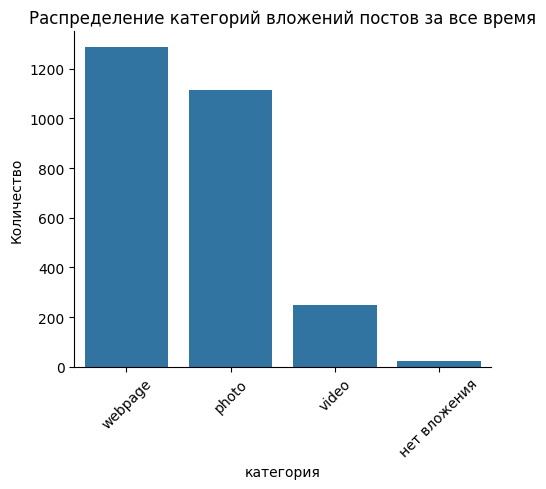

In [ ]:
plt.figure(figsize=(12, 9))
sns.catplot(x = 'type_attachment', kind = 'count', data = merged_df)
plt.title('Распределение категорий вложений постов за все время')
plt.ylabel('Количество')
plt.xlabel('категория')
plt.xticks(rotation=45)  # Поворот меток по оси X на 45 градусов для лучшей читаемости
plt.tight_layout()
plt.show()

Анализ категорий вложений постов показал, что:
- большая часть постов за все время анализа содержат ссылки, либо фотографии
- постов с видео-контентом довольно мало, около 250

Посмотрим на статистическую значимость в категориях вложений:

In [ ]:
attach_a_data = merged_df[merged_df['type_attachment'] == 'webpage'] # В основном статьи Кинопоиска
attach_b_data = merged_df[merged_df['type_attachment'] == 'photo']
attach_c_data = merged_df[merged_df['type_attachment'] == 'video']
attach_d_data = merged_df[merged_df['type_attachment'] == 'нет вложения']


# Применяем тест Краскела-Уоллиса для каждого параметра
for param in ['views', 'forwarded', 'reactions_count', 'comments']:
    h_statistic, p_value = kruskal(attach_a_data[param], attach_b_data[param],
                                    attach_c_data[param], attach_d_data[param])
    print(f"Тест Краскела-Уоллиса для параметра '{param}':")
    print("H-статистика:", h_statistic)
    print("p-значение:", p_value)
    print()


Тест Краскела-Уоллиса для параметра 'views':
H-статистика: 8.186995253374088
p-значение: 0.042301100349211036

Тест Краскела-Уоллиса для параметра 'forwarded':
H-статистика: 240.7139429120393
p-значение: 6.669836773975874e-52

Тест Краскела-Уоллиса для параметра 'reactions_count':
H-статистика: 719.937204984666
p-значение: 9.972674333770325e-156

Тест Краскела-Уоллиса для параметра 'comments':
H-статистика: 208.1018996391803
p-значение: 7.488534483419044e-45



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- Статистически значимые различия обнаружены между всеми группами показателей

In [ ]:
# Соберем все данные в один массив
all_data = pd.concat([attach_a_data, attach_b_data, attach_c_data, attach_d_data])

# Добавим столбец с группами
all_data['group'] = ['A'] * len(attach_a_data) + ['B'] * len(attach_b_data) + ['C'] * len(attach_c_data) + ['D'] * len(attach_d_data)

# Выполним множественные сравнения с помощью метода Тьюки для количества реакций
tukey_results = pairwise_tukeyhsd(all_data['reactions_count'], all_data['group'])

print(tukey_results)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     A      B 435.2788    0.0   380.454 490.1036   True
     A      C 344.9422    0.0  252.1574 437.7271   True
     A      D 356.1095 0.0065   74.1878 638.0312   True
     B      C -90.3366 0.0645 -184.2608   3.5876  False
     B      D -79.1693 0.8888  -361.468 203.1294  False
     C      D  11.1673 0.9997 -280.8872 303.2218  False
-------------------------------------------------------


- Статистически значимые различия обнаружены между группой A ('webpages') и остальными группами

In [ ]:
# посмотрим на среднее кол-во реакций для каждого из вложений
merged_df.groupby('type_attachment', as_index=False) \
         .agg({'reactions_count':'mean'}) \
         .sort_values('reactions_count', ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


type_attachment  reactions_count
0           photo       757.256272
3    нет вложения       678.086957
1           video       666.919679
2         webpage       321.977449

Получается, что статистически значимо у постов со ссылками меньше реакций, чем у постов с фото и видео.

In [ ]:
# Для количества комментариев
tukey_results = pairwise_tukeyhsd(all_data['comments'], all_data['group'])

print(tukey_results)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     A      B  30.6301    0.0  23.6207  37.6395   True
     A      C   3.9994 0.8221  -7.8632   15.862  False
     A      D  40.7487 0.0193   4.7047  76.7926   True
     B      C -26.6307    0.0  -38.639 -14.6224   True
     B      D  10.1186 0.8889 -25.9736  46.2107  False
     C      D  36.7493 0.0556  -0.5902  74.0887  False
------------------------------------------------------


- Статистически значимые различия обнаружены между группой A (вебстраницы) и B (фото)
- Статистически значимые различия обнаружены между группой A (вебстраницы) и D (нет вложения)
- Статистически значимые различия обнаружены между группой B (фото) и С (видео)

In [ ]:
merged_df.groupby('type_attachment', as_index=False) \
         .agg({'comments':'mean'}) \
         .sort_values('comments', ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


type_attachment   comments
3    нет вложения  69.608696
0           photo  59.490143
1           video  32.859438
2         webpage  28.860031

Анализ вложений постов показал, что:  
- Посты с фотографиями комментируют больше, чем посты с ссылками  
- Посты с фотографиями комментируют чаще, чем посты с видео  
- Среднее значение комментариев к постам с вложением фото в два раза больше, чем у постов с ссылками и видео, и данное различие статистически значимо.

### Хештеги (чтобы посмотреть, видео в рубриках или нет)

In [ ]:
# напишем функцию для извлечения хэштегов из текста постов
def extract_and_format_hashtags(text):
    hashtags = re.findall(r'#\w+', text) if pd.notna(text) else []
    return ', '.join(hashtags) if hashtags else pd.NA

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# применим функцию к столбцу text и сохраним хэштеги в новый столбец hashtags
merged_df['hashtags'] = merged_df['text'].apply(lambda x: extract_and_format_hashtags(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df['hashtags'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#коротыше                                     57
#коротыш                                      53
#Оскар2023                                    31
#Дождались                                    19
#КП100ВеликихФильмов                          17
#Венеция2023                                  10
#КПитоги23                                     9
#летоскинопоиском                              9
#Канны2023                                     7
#Подслушано                                    7
#ДежурныйПоКинопоиску                          6
#КПИтогиГода2023                               4
#КиноПоПятницам                                4
#ДайджестНовостей                              4
#НейроКП                                       2
#ИтогиКП2023                                   2
#ГостьКинопоиска                               2
#мартимертв, #мартимертв____                   1
#коротыше, #КП100ВеликихФильмов                1
#малкович                                      1
#скажимиядзаки, #мал

In [ ]:
# Функция для нормализации хэштегов
def normalize_hashtags(hashtags):
    if isinstance(hashtags, str):  # Проверяем, что значение не NaN
        # Разделяем хэштеги по запятой и удаляем лишние пробелы
        hashtags_list = [hashtag.strip() for hashtag in hashtags.split(',')]
        normalized_hashtags_list = []
        for hashtag in hashtags_list:
            # Приводим все символы к нижнему регистру
            normalized_hashtag = hashtag.lower()
            # Заменяем 'коротыше' на 'коротыш'
            normalized_hashtag = normalized_hashtag.replace('коротыше', 'коротыш')
            # Заменяем 'кпитоги' на 'итогикп'
            normalized_hashtag = normalized_hashtag.replace('кпитоги', 'итогикп')
            # Удаляем годы из хэштега
            normalized_hashtag = re.sub(r'\b20\d{2}\b', '', normalized_hashtag)
            # Удаляем все символы, кроме букв
            normalized_hashtag = re.sub(r'[^a-zA-Zа-яА-Я]', '', normalized_hashtag)
            normalized_hashtags_list.append(normalized_hashtag)
        return normalized_hashtags_list
    else:
        return []  # Возвращаем пустой список для пропущенных значений

# Добавляем столбец normalized_hashtags в DataFrame merged_df
merged_df['normalized_hashtags'] = merged_df['hashtags'].apply(normalize_hashtags)

# Преобразуем столбец 'normalized_hashtags' в строку для вывода
merged_df['normalized_hashtags_str'] = merged_df['normalized_hashtags'].apply(lambda x: ', '.join(x) if x else '')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df['normalized_hashtags_str'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                      2415
коротыш                                110
оскар                                   31
дождались                               19
кпвеликихфильмов                        17
итогикп                                 11
летоскинопоиском                        10
венеция                                 10
канны                                    7
подслушано                               7
дежурныйпокинопоиску                     6
итогикпгода                              4
кинопопятницам                           4
дайджестновостей                         4
коротыш, кпвеликихфильмов                2
гостькинопоиска                          2
нейрокп                                  2
мартимертв, мартимертв                   1
малкович                                 1
скажимиядзаки, мальчикиптица             1
кпновоеимя                               1
оскар, коротыш                           1
кпвеликихфильмов, кпвеликихфильмов       1
коротыш, ос

In [ ]:
# отфильтруем толкьо посты без хэштегов
non_zero_normalized_hashtags = merged_df[merged_df['normalized_hashtags_str'] != '']

# выведем информацию о типе контента для постов без хэштегов
print(non_zero_normalized_hashtags['type_attachment'].value_counts())

video      122
photo       75
webpage     62
Name: type_attachment, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Больше всего видео у постов с хэштегами, возможно что это специальные рубрики (проекты) кинопоиска

## Количество эмоджи в тексте поста

In [ ]:
# напишем функцию для подсчета эможзи
def count_emojis(text):
    emojis = [c for c in text if c in emoji.EMOJI_DATA]
    return len(emojis)

# Применяем функцию count_emojis к каждой ячейке столбца 'text' и сохраняем результат в новом столбце 'emoji_count'
merged_df['emoji_count'] = merged_df['text'].apply(count_emojis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df['emoji_count'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0     1154
1      930
2      376
3      119
4       52
5       13
7        9
6        8
8        4
9        3
10       3
11       1
12       1
17       1
Name: emoji_count, dtype: int64

In [ ]:
print(f'Медианное количество эмоджи в текстах постов: {merged_df["emoji_count"].median()} ')

Медианное количество эмоджи в текстах постов: 1.0 


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
merged_df.loc[merged_df['emoji_count'] == 17] # эмоджи для выделения пунктов подборки

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


👎     👍   🤔     🔥      ❤   😱   👏   🤬   🤣  ❤‍🔥  ...  hashtags1  \
2606  7.0  94.0 NaN  18.0  297.0 NaN NaN NaN NaN  NaN  ...       <NA>   

                     topic1             n_topic  positive_count  \
2606  Станислав Зельвенский  критик Зельвенский           413.0   

      negative_count  neutral_count  hashtags  normalized_hashtags  \
2606            10.0            3.0      <NA>                   []   

      normalized_hashtags_str  emoji_count  
2606                                    17  

[1 rows x 84 columns]

- Большинство постов не содержат эмоджи в тексте поста
- Очень редко более 3 эмоджи в тексте

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


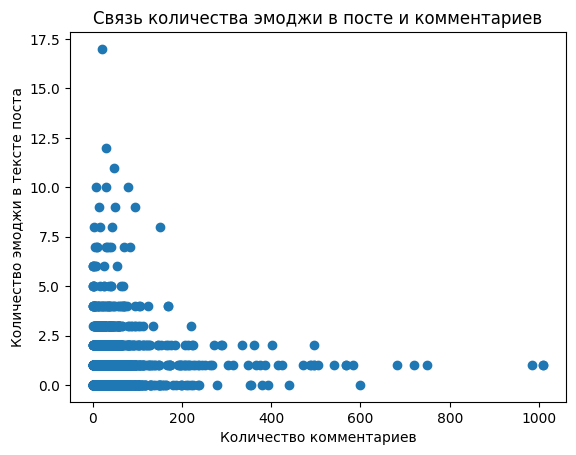

In [ ]:
# посмотрим, есть ли связь между кол-вом эмодзи и кол-вом комментариев
plt.scatter(x='comments', y='emoji_count', data=merged_df)
plt.title('Связь количества эмоджи в посте и комментариев')
plt.ylabel('Количество эмоджи в тексте поста')
plt.xlabel('Количество комментариев')
plt.show()

Выявлена отрицательньная связь - чем больше комментариев, тем меньше эмоджи в тексте.

<font color='red'>КОМЕНТАРИЙ РЕВЬЮЕРА</font> я бы рекоменовала подтверждать зависимость или связь с помощью corr(

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


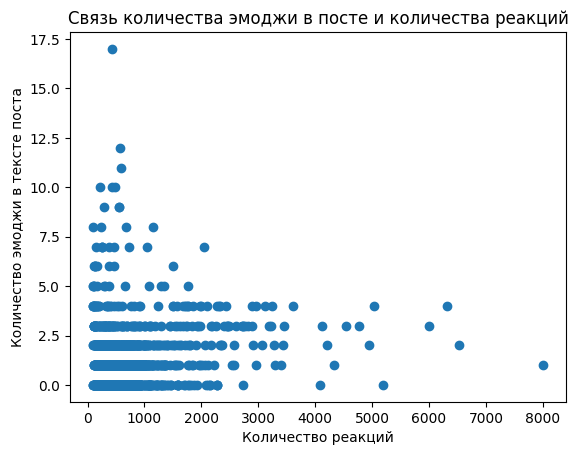

In [ ]:
plt.scatter(x='reactions_count', y='emoji_count', data=merged_df)
plt.title('Связь количества эмоджи в посте и количества реакций')
plt.ylabel('Количество эмоджи в тексте поста')
plt.xlabel('Количество реакций')
plt.show()

Выявлена отрицательньная связь - чем больше реакций, тем меньше эмоджи в тексте.

In [ ]:
result = merged_df[(merged_df['text'].str.contains('🔥 ')) & (merged_df['emoji_count'] ==1)]
print(f"Процент постов, которые содержат фразу '🔥 Подписывайтесь на Кинопоиск...' от общего количества постов с эмоджи: {round(len(result) / len(merged_df.loc[merged_df['emoji_count'] >=1]) * 100)} %")

Процент постов, которые содержат фразу '🔥 Подписывайтесь на Кинопоиск...' от общего количества постов с эмоджи: 19 %


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Проверим, есть ли различия в кол-ве эмодзи у постов с фразой 'Подписывайтесь на Кинопоиск'
result = merged_df[(merged_df['text'].str.contains('🔥 Подписывайтесь ')) & (merged_df['emoji_count'] ==1)]
print(f"Процент постов, которые содержат один эмоджи 🔥 в фразе 'Подписывайтесь на Кинопоиск...' от общего количества постов с  1 эмоджи: {round(len(result) / len(merged_df.loc[merged_df['emoji_count'] == 1]) * 100)} %")


Процент постов, которые содержат один эмоджи 🔥 в фразе 'Подписывайтесь на Кинопоиск...' от общего количества постов с  1 эмоджи: 29 %


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Выводы**

- Медианное количество эмоджи в тексте - 1.
- Большинство постов не содержат эмоджи.
- Отрицательная взаимосвязь количества эмоджи в постах и количества реакций или комментариев.
- 19% постов от постов с одним и более эмоджи содержат один 🔥.
- Треть постов с одним эмоджи - это посты с фразой '🔥 Подписывайтесь на Кинопоиск...'
- Можно сделать предположение, что у Кинопоиска есть желание не переборщить с эмоджи.

## Добавим переменную с длинной поста

In [ ]:
def text_length(text):
    return len(text)

merged_df['text_length'] = merged_df['text'].apply(text_length) # Добавим

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Посмотрим на описательную статистику длины поста
merged_df['text_length'].describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count    2674.000000
mean      386.689978
std       301.752036
min         3.000000
25%       214.000000
50%       333.000000
75%       469.000000
max      3184.000000
Name: text_length, dtype: float64

Среднее значение (mean): Средняя длина текста поста составляет примерно 386 символов.

Стандартное отклонение (std): Стандартное отклонение составляет примерно 301 символ.

Минимальное и максимальное значения (min, max): Минимальная длина текста составляет 3 символа, а максимальная - 3184 символа. Это указывает на то, что наблюдения имеют широкий диапазон значений, с постами как очень короткими, так и очень длинными текстами.

50-й процентиль (медиана) - 333 символа.

Данные распределены довольно широко относительно среднего значения, что может говорить о разнообразии в длине постов.
Также можно сказать, что в среднем посты имеют относительно средний размер.

In [ ]:
# Дополнительно посмотрим, какие посты с хэштегом и есть ли связь с длиной поста
merged_df['has_hashtag'] = merged_df['hashtags'].notna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
table_hash = pd.pivot_table(merged_df,
                            index='has_hashtag',
                            values=['text_length', 'views', 'forwarded', 'reactions_count', 'comments'],
                            aggfunc='median')
table_hash

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


comments  forwarded  reactions_count  text_length    views
has_hashtag                                                            
False              27      142.0              363          341  58839.0
True               20      202.0              425          266  61810.0

**Выводы**

- посты с хэштегом короче, чем посты без хэштегов
- просмотров немного больше у постов с хэштегом
- пересылают посты с хэштегами чаше, а комментируют немного реже

## Знаки препинания (сложность текста)

In [ ]:
def remove_links(text):
    return re.sub(r'https?://\S+', '', str(text))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# напишем функцию для выявления и посчета кол-ва знаков пунктуации в текстах постов
def count_punctuation(sentence):
  sentence = remove_links(sentence)
  punctuation_count = 0
  found_punctuation = []

  for char in sentence:
    if char in string.punctuation:
      punctuation_count += 1
      found_punctuation.append(char)

  return pd.Series({'punctuation_count': punctuation_count, 'found_punctuation': found_punctuation})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# применим функцию и посчитаем кол-во знаков пунктуации
merged_df[['punctuation_count', 'found_punctuation']] = merged_df['text'].apply(count_punctuation)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# посмотрим на кол-во знаков в посте с самыми высокими просмотрами
merged_df[['text', 'views', 'punctuation_count']] \
.sort_values('views', ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


text     views  \
2154  💯 100. Великих. Фильмов. XXI века\n\nПредставл...  278962.0   
2266  Не выходи из комнаты и ешь сыр 🧀\n\nТаким реце...  272087.0   
350   Прямо сейчас общаемся в прямом эфире с Владисл...  244143.0   
348   «Вавилон» — кино о кино, поэтому в нем много о...  239884.0   
2407  Журналист «Загадки дыры» пишет книгу о прошлом...  186321.0   
...                                                 ...       ...   
552   До #Оскар2023 осталось три дня.\n\nПродолжаем ...   39046.0   
2007  Постер «Мальчика и птицы» Хаяо Миядзаки, опубл...   38258.0   
1995  ⚡️Принцесса Диана, принц Чарльз, Елизавета II ...   38228.0   
554   Яндекс выпустил большое исследование, посвящен...   38139.0   
376   Горшок и Князь на постере сериала «Король и Шу...   34256.0   

      punctuation_count  
2154                 46  
2266                 17  
350                   8  
348                   4  
2407                 20  
...                 ...  
552                   4  
2007                 17  
1995                 12  
554                  10  
376                   7  

[2674 rows x 3 columns]

In [ ]:
merged_df.punctuation_count.median()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


12.0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated

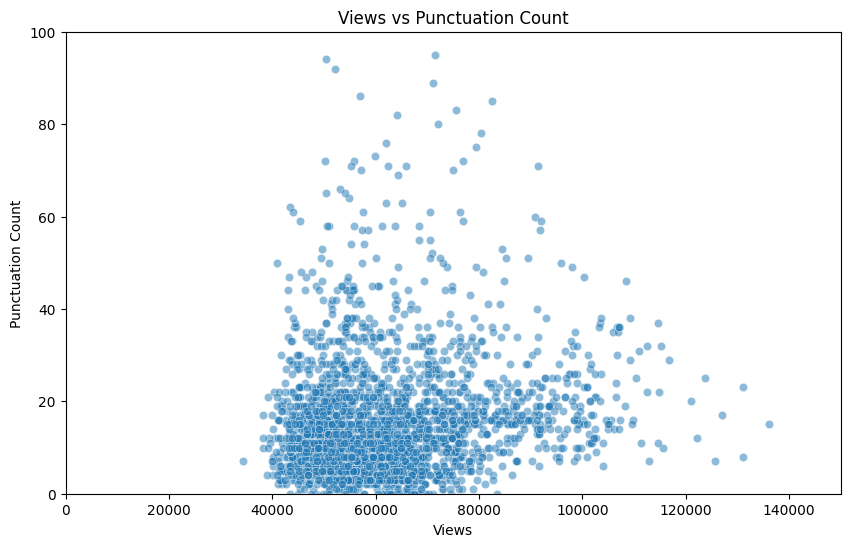

In [ ]:
# Построение графика scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='views', y='punctuation_count', alpha=0.5)

# Настройка легенды и осей
plt.title('Views vs Punctuation Count')
plt.xlabel('Views')
plt.ylabel('Punctuation Count')

# Установка лимитов на осях
plt.xlim(0, 150000)
plt.ylim(0, 100)

# Отображение графика
plt.show()

In [ ]:
merged_df.punctuation_count.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count    2674.000000
mean       15.451384
std        13.746192
min         0.000000
25%         7.000000
50%        12.000000
75%        19.000000
max       143.000000
Name: punctuation_count, dtype: float64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


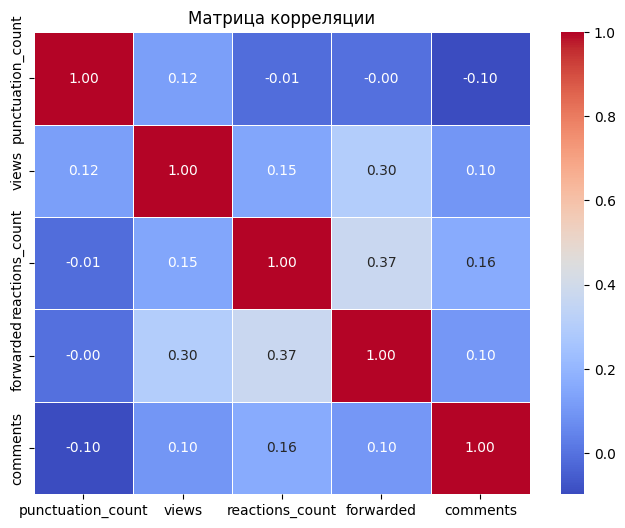

In [ ]:
# Проверим, есть ли корреляция между кол-вом знаков пунктуации и просмотрами постов
corr_matrix = merged_df[['punctuation_count', 'views', 'reactions_count', 'forwarded', 'comments']].corr()

# визуализируем матрицу корреляции
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции')
plt.show()

**Выводы**  
- Медианное кол-во знаков пунктуации в постах - 12
- Количество знаков пунктуации слабо коррелирует с кол-вом просмотров, комметариев, реакций и репостов. Значения близки к нулю, а значит разное кол-во знаков пунктуации в постах не связаны с изменениями в других переменных.

## График подписок и отписок по дням

In [ ]:
# визуализируем кол-во подписавшихся и отписавшихся по дням
trace_subscribers = go.Scatter(x=subscribers['date'], y=subscribers['subscribers'], mode='lines', name='Подписались', showlegend=True)


trace_unsubscribed = go.Scatter(x=subscribers['date'], y=subscribers['unsubscribed'], mode='lines', name='Отписались', showlegend=True)

fig = go.Figure([trace_subscribers, trace_unsubscribed])


fig.update_layout(
    title='График подписок и отписок по датам',
    xaxis_title='Дата',
    yaxis_title='Количество',
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    legend=dict(x=0, y=1, font=dict(size=16), traceorder='normal')  # Размер шрифта легенды и порядок вывода
)

# Отображение интерактивного графика
fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Выводы**

- Наблюдается симметрия в графике с июля 2023 года.
- Отдельные всплески в 2023 году - 1 января (264), 12 марта (1553), 4 апреля (657), 3 мая (389)
- Всплеск подписок в ноябре 2023 (чат-бот), приходили больше, чем отписывались, хотя и есть симметрия
- Спад подписок и отписк в январе 2024

## График подписок и отписок по часам

In [ ]:
subscribe_data = subscribers.groupby('hour')['subscribers'].sum()
unsubscribe_data = subscribers.groupby('hour')['unsubscribed'].sum()

# Создаем трассу для подписок
trace_subscribe = go.Scatter(x=subscribe_data.index, y=subscribe_data.values, mode='lines+markers', name='Subscriptions')

# Создаем трассу для отписок
trace_unsubscribe = go.Scatter(x=unsubscribe_data.index, y=unsubscribe_data.values, mode='lines+markers', name='Unsubscriptions')

# Создаем фигуру
fig = go.Figure()

# Добавляем трассы на фигуру
fig.add_trace(trace_subscribe)
fig.add_trace(trace_unsubscribe)

# Настройка внешнего вида графика
fig.update_layout(
    title='График подписок и отписок по часам',
    xaxis_title='Time',
    yaxis_title='Count',
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    legend=dict(x=0, y=1)
)

# Отображаем график
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



**Выводы**

- Симметрия в данных, подписываются и отписываются активно с 10 утра по мск и до 21 по мск
- После 21 у подписок спад небольшой
- После 21 у отписок небольшой рост (в 23)

In [ ]:
subscribers_group = subscribers.groupby('date').agg('sum').drop(columns='hour').reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
subscribers_group

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date  subscribers  unsubscribed
0   2022-08-17          124           -57
1   2022-08-18           92           -48
2   2022-08-19          221           -25
3   2022-08-20          373           -26
4   2022-08-21          135           -14
..         ...          ...           ...
515 2024-01-14         7006         -4813
516 2024-01-15         7455         -5023
517 2024-01-16         7775         -5666
518 2024-01-17         7535         -5475
519 2024-01-18         2165         -1673

[520 rows x 3 columns]

In [ ]:
# Сгруппируем данные по постам
metrics_df = merged_df.groupby('date_YMD')['views', 'reactions_count',
                                           'forwarded', 'comments'].agg('sum').reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
metrics_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date_YMD     views  reactions_count  forwarded  comments
0   2023-01-01  373191.0             3052     1046.0       339
1   2023-01-02  238682.0             1400      675.0       124
2   2023-01-03  509082.0             3541     1865.0       213
3   2023-01-04  393612.0             2705     1038.0       109
4   2023-01-05  492542.0             2129     1327.0       367
..         ...       ...              ...        ...       ...
378 2024-01-14  492951.0             3241     1332.0       518
379 2024-01-15  580259.0             5285     6790.0       303
380 2024-01-16  698010.0             9153     2445.0       304
381 2024-01-17  600478.0             4225     2704.0       203
382 2024-01-18  678769.0             6288     4846.0       305

[383 rows x 5 columns]

In [ ]:
metrics_df = pd.merge(metrics_df, subscribers_group, left_on='date_YMD', right_on='date', how='left')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Объединение третьего DataFrame
metrics_df = pd.merge(metrics_df, subscribers_g, left_on='date_YMD', right_on='date', how='left')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
metrics_df.drop(columns=['date_x', 'date_y'], inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Переименуем столбцы
metrics_df.rename(columns={'subscribers_x': 'new_subscribers', 'subscribers_y': 'total_subscribers'}, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
metrics_df.head() # Почему-то change не совпадает с разницей между подписками и отписками

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date_YMD     views  reactions_count  forwarded  comments  new_subscribers  \
0 2023-01-01  373191.0             3052     1046.0       339             1214   
1 2023-01-02  238682.0             1400      675.0       124              359   
2 2023-01-03  509082.0             3541     1865.0       213              347   
3 2023-01-04  393612.0             2705     1038.0       109              205   
4 2023-01-05  492542.0             2129     1327.0       367              229   

   unsubscribed  total_subscribers  changes  
0           -32             226447     1337  
1           -13             226928      481  
2           -34             227365      437  
3           -14             227621      256  
4           -32             227805      184

## Коэффициент роста аудитории

In [ ]:
# Рассчитаем коэффициент роста
metrics_df['grow_rate'] = metrics_df['new_subscribers']/metrics_df['total_subscribers'] * 100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:

fig = go.Figure()

fig.add_trace(go.Scatter(x=metrics_df['date_YMD'], y=metrics_df['grow_rate'], mode='lines+markers', name='Прирост подписчиков (%)'))

fig.update_layout(title='График прироста подписчиков в процентах январь 2023-январь 2024',
                  xaxis_title='Дата',
                  yaxis_title='Прирост подписчиков (%)',
                  showlegend=True)

fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



**Выводы**

- График показывает, что аудитории была примерно на одном уровне с января по ноябрь 2023 года (коэффициент роста практически не превышал 1%), а в ноябре аудитория резко начала расти и коэффициент приблизился к 5%
- После пика в ноябре рост замедлился и к середине января 2024 вернулся к коэффициенту роста в начале 2023 года (примерно 0.5%)

## Расчёт ежедневого оттока подписчиков

In [ ]:
metrics_df['previous_day_subscribers'] = metrics_df['total_subscribers'].shift(1)
# Заполнение пропущенных значений в первой строке значением из текущих подписчиков
metrics_df.loc[0, 'previous_day_subscribers'] = metrics_df.loc[0, 'total_subscribers']

metrics_df['daily_churn_rate'] = (metrics_df['previous_day_subscribers'] + metrics_df['new_subscribers'] - metrics_df['total_subscribers']) / metrics_df['previous_day_subscribers']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=metrics_df['date_YMD'], y=metrics_df['daily_churn_rate'], mode='lines+markers', name='Коэффициент оттока подписчиков (%)'))

fig.update_layout(title='Ежедневний отток подписчиков январь 2023-январь 2024',
                  xaxis_title='Дата',
                  yaxis_title='Коэффициент оттока подписчиков %',
                  showlegend=True)

fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



**Выводы**

- График показывает, что были отрицательный пик в марте, когда был пик подписок (12 марта), нужно посмотреть, что там происходило, так как пришедшие не ушли (был Оскар 2023)
- Пик описок в ноябре (быстрый рост подписок =быстрый рост отписок)
- Стабилизация отписок к середине января (околонулевой коэффициент)

## Engagement Rate (ER)

**Engagement Rate (ER)** измеряет уровень вовлеченности аудитории с контентом или медиа-каналом. Это отношение числа взаимодействий (например, реакций, комментариев, репостов) к общему числу просмотров, подписчиков или другой метрике, представляющей аудиторию.

Engagement является показателем эффективности контента или канала, а более высокие значения могут указывать на более активную и заинтересованную аудиторию.

Рассчитаем Engagement Rate к сумму реакций, комментариев, репостов к количеству подписчиков:

In [ ]:
metrics_df['daily_er'] = (metrics_df['comments'] + metrics_df['reactions_count'] + metrics_df['forwarded']) / metrics_df['total_subscribers'] * 100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
er_2022 = merged_2022.groupby('date_YMD')[['comments', 'reactions_count', 'forwarded', 'subscribers']].agg({'comments':'sum', 'reactions_count': 'sum',
                                                                                                              'forwarded':'sum', 'subscribers': 'first'}
                                                                                                              )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
er_2022['daily_er'] = (er_2022['comments'] + er_2022['reactions_count'] + er_2022['forwarded']) / er_2022['subscribers'] * 100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
er_2022['daily_er'].median()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



nan

In [ ]:
print(f"Медиана ER в 2023-2024: {round(metrics_df['daily_er'].median(), 2)} %")

Медиана ER в 2023-2024: 1.72 %


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
print(f"Среднее ER в 2023-2024: {round(metrics_df['daily_er'].mean(), 2)} %")

Среднее ER в 2023-2024: 1.91 %


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=metrics_df['date_YMD'], y=metrics_df['daily_er'], mode='lines+markers', name='ER (%)'))

fig.update_layout(title='Ежедневний ER январь 2023-январь 2024',
                  xaxis_title='Дата',
                  yaxis_title='ER подписчиков %',
                  showlegend=True)

fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



**Выводы**

- ER распределен равномерно, кроме всплеска в марте, когда ER был выше 10%
- Также всплески в конце апреля, конце октября и начале ноября (5-6%)
- в ноябре ER пошел на спад
- ER не очень большой, если смотреть на медиану и среднее

## Дневная вовлеченность подписчиков

In [ ]:
daily_ER = merged_df.groupby('date_YMD')['reactions_count', 'total_subscribers'].agg({'reactions_count':'sum', 'total_subscribers':'first'}).reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
daily_ER['ER_day'] = daily_ER['reactions_count'] / daily_ER['total_subscribers'] * 100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_ER['date_YMD'], y=daily_ER['ER_day'], mode='lines+markers', name='Дневная вовлеченность подписчиков (%)'))

fig.update_layout(title='Дневная вовлеченность подписчиков январь 2023-январь 2024',
                  xaxis_title='Дата',
                  yaxis_title='Дневная вовлеченность подписчиков %',
                  showlegend=True)

fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



**выводы**

- аналогичные тенденции предыдущему графику

In [ ]:
daily_ER_subset = daily_ER[['date_YMD', 'ER_day']]
metrics_df = metrics_df.merge(daily_ER_subset, on='date_YMD', how='left')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
metrics_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date_YMD     views  reactions_count  forwarded  comments  \
0   2023-01-01  373191.0             3052     1046.0       339   
1   2023-01-02  238682.0             1400      675.0       124   
2   2023-01-03  509082.0             3541     1865.0       213   
3   2023-01-04  393612.0             2705     1038.0       109   
4   2023-01-05  492542.0             2129     1327.0       367   
..         ...       ...              ...        ...       ...   
378 2024-01-14  492951.0             3241     1332.0       518   
379 2024-01-15  580259.0             5285     6790.0       303   
380 2024-01-16  698010.0             9153     2445.0       304   
381 2024-01-17  600478.0             4225     2704.0       203   
382 2024-01-18  678769.0             6288     4846.0       305   

     new_subscribers  unsubscribed  total_subscribers  changes  grow_rate  \
0               1214           -32             226447     1337   0.536108   
1                359           -13             226928      481   0.158200   
2                347           -34             227365      437   0.152618   
3                205           -14             227621      256   0.090062   
4                229           -32             227805      184   0.100525   
..               ...           ...                ...      ...        ...   
378             7006         -4813             544320     2021   1.287111   
379             7455         -5023             546859     2539   1.363240   
380             7775         -5666             548902     2043   1.416464   
381             7535         -5475             550963     2061   1.367605   
382             2165         -1673             551378      415   0.392653   

     previous_day_subscribers  daily_churn_rate  daily_er    ER_day  
0                    226447.0          0.005361  1.959399  1.347777  
1                    226447.0         -0.000539  0.969030  0.616936  
2                    226928.0         -0.000397  2.471357  1.557408  
3                    227365.0         -0.000224  1.692287  1.188379  
4                    227621.0          0.000198  1.678190  0.934571  
..                        ...               ...       ...       ...  
378                  542299.0          0.009192  0.935295  0.595422  
379                  544320.0          0.009031  2.263472  0.966428  
380                  546859.0          0.010482  2.168329  1.667511  
381                  548902.0          0.009973  1.294461  0.766839  
382                  550963.0          0.003176  2.074620  1.140415  

[383 rows x 14 columns]

## Среднее время до оттока (MTC)

Если вы хотите выразить среднее время жизни подписчика в днях через показатель оттока (churn rate), вы можете воспользоваться обратной величиной этого показателя. Для этого применяется концепция среднего времени до оттока (Mean Time to Churn - MTC) или обратного оттока.

In [ ]:
metrics_df['mtc'] = 1 / metrics_df['daily_churn_rate']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
mtc_median = metrics_df['mtc'].median()

print(f'Среднее время подписчика перед оттоком: {round(mtc_median)} дней')

Среднее время подписчика перед оттоком: 196 дней


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
metrics_df.query('mtc == 126757.00000000001')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date_YMD     views  reactions_count  forwarded  comments  \
77 2023-03-19  211947.0             1550      253.0       628   

    new_subscribers  unsubscribed  total_subscribers  changes  grow_rate  \
77              246            -9             253758      244   0.096943   

    previous_day_subscribers  daily_churn_rate  daily_er    ER_day       mtc  
77                  253514.0          0.000008  0.957999  0.610818  126757.0

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=metrics_df['date_YMD'], y=metrics_df['mtc'], mode='lines+markers', name='Коэффициент оттока подписчиков (%)'))

fig.update_layout(title='Динамика среднего времени подписчика в днях перед оттоком',
                  xaxis_title='Дата',
                  yaxis_title='Дни',
                  showlegend=True)

fig.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



**Выводы**

- Медиана MTC равна 215 дням, что означает, что половина подписчиков прекращают использование приложения в течение этого времени.
- Хотя на графике особо и не видно, но MTC в ноябре снизился (3 ноября 356 дней был, а далее достигал и 30 дней
- Метрика может быть неинформативна при значения уровня оттока близким к нулю

## Охваты постов

Коэффициент охвата (Engagement Rate by Reach) — метрика, которая показывает сколько людей из тех, что увидели пост, взаимодействовали с ним: комментировали, ставили лайки, делали репосты. Более правильно ERR переводится как коэффициент вовлечённости по охвату.



In [ ]:
merged_df['err'] = (merged_df['reactions_count'] + merged_df['forwarded'] + merged_df['comments']) / merged_df['views'] * 100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
merged_df['err'].median()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0.9883790707957915

In [ ]:
#Выведем посты по коэффициенту охвата (ERR) выше медианы
top_err_posts = merged_df.loc[merged_df['err'] > merged_df['err'].median()]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
top_err_posts.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(1337, 89)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: Deprecati

<Axes: xlabel='type_attachment', ylabel='err'>

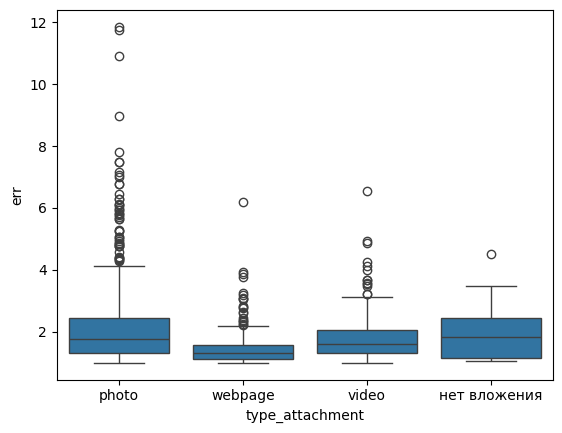

In [ ]:
sns.boxplot(x='type_attachment', y='err', data=top_err_posts)

**Выводы**

- Коэффициент охвата выше у постов с фотографиями

## Частота публикаций и время публикаций

In [ ]:
merged_df['posts_freq'] = merged_df.groupby(merged_df['datetime'].dt.date)['id'].transform('count')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
merged_df['posts_freq'].median() # в день публикуют 7 постов (медиана)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



7.0

In [ ]:
# Преобразуем столбец datetime в периоды месяцев и недель
merged_df['month'] = merged_df['datetime'].dt.to_period('M')
merged_df['week'] = merged_df['datetime'].dt.to_period('W')

# Группируем данные по месяцам и подсчитываем количество записей в каждом месяце
monthly_grouped = merged_df.groupby('month').size()

# Группируем данные по неделям и подсчитываем количество записей в каждой неделе
weekly_grouped = merged_df.groupby('week').size()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
monthly_grouped

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



month
2023-01    242
2023-02    228
2023-03    268
2023-04    195
2023-05    176
2023-06    181
2023-07    191
2023-08    192
2023-09    214
2023-10    223
2023-11    235
2023-12    210
2024-01    119
Freq: M, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



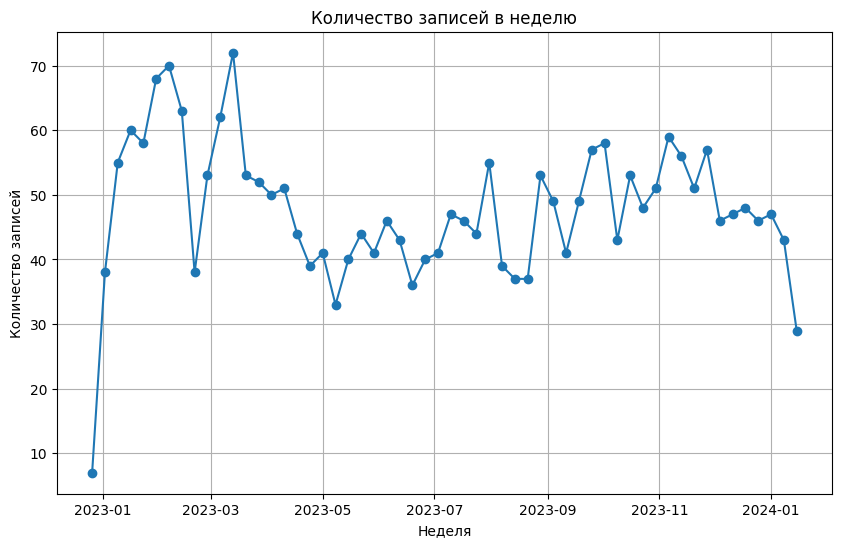

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(weekly_grouped.index.to_timestamp(), weekly_grouped.values, marker='o', linestyle='-')
plt.title('Количество записей в неделю')
plt.xlabel('Неделя')
plt.ylabel('Количество записей')
plt.grid(True)
plt.show()

**Выводы**

- В день публикуют в среднем 7 постов (медиана)
- Распределение количества постов по месяцам достаточно ровное, выделяется январь 2024 года меньшим количеством - 119 постов, но там данные не за весь месяц + праздники (выходные). В марте было больше всего постов (268)
- график по неделям также показывает, что март выделяется, как и оба января (самые низкие по частоте постов месяцы)

## Исследование корреляции характеристик и метрик постов с привлечением новых пользователей в канал Кинопоиска


In [ ]:
merged_df = merged_df.merge(metrics_df[['date_YMD', 'grow_rate', 'daily_churn_rate',	'daily_er',	'ER_day', 'mtc']], on="date_YMD", how='left')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
merged_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



👎      👍     🤔      🔥      ❤    😱    👏    🤬    🤣   ❤‍🔥  ...  \
0  163.0  115.0  20.0   18.0    9.0  7.0  2.0  2.0  2.0   1.0  ...   
1   76.0   96.0   NaN    4.0  439.0  5.0  NaN  NaN  NaN  30.0  ...   
2  152.0   41.0  13.0    3.0   52.0  NaN  NaN  NaN  NaN   NaN  ...   
3   33.0  289.0   6.0   22.0   48.0  NaN  NaN  NaN  NaN   NaN  ...   
4   60.0   51.0   NaN  331.0   46.0  NaN  2.0  NaN  NaN   4.0  ...   

                                   found_punctuation       err  posts_freq  \
0         [[, ], (, ,, ., ,, ., ,, ., ,, ,, [, ], (]  0.927214           7   
1                  [!, :, :, ,, -, ., ,, ,, [, ], (]  1.766619           7   
2  [-, ., (, ), ,, (, ), (, ), ., [, ], (, ,, -, ...  0.650031           7   
3                              [!, ., [, ], (, :, .]  1.049356           7   
4            [:, ., [, ], (, ., ,, ,, ,, ., :, :, .]  1.290908           7   

     month                   week  grow_rate  daily_churn_rate  daily_er  \
0  2023-01  2022-12-26/2023-01-01   0.536108          0.005361  1.959399   
1  2023-01  2022-12-26/2023-01-01   0.536108          0.005361  1.959399   
2  2023-01  2022-12-26/2023-01-01   0.536108          0.005361  1.959399   
3  2023-01  2022-12-26/2023-01-01   0.536108          0.005361  1.959399   
4  2023-01  2022-12-26/2023-01-01   0.536108          0.005361  1.959399   

     ER_day         mtc  
0  1.347777  186.529654  
1  1.347777  186.529654  
2  1.347777  186.529654  
3  1.347777  186.529654  
4  1.347777  186.529654  

[5 rows x 97 columns]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<Axes: >

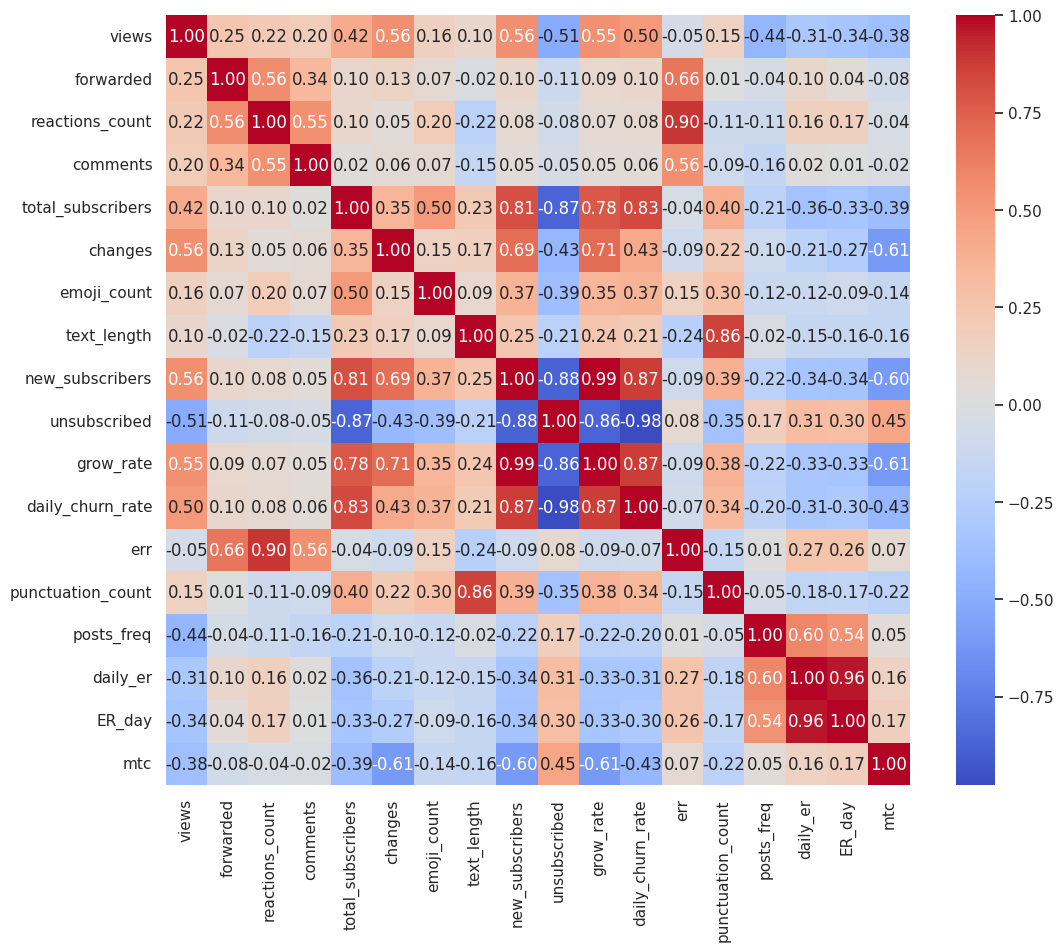

In [ ]:
# Установка размера графика
plt.figure(figsize=(12, 10))

# Установка стиля seaborn
sns.set()

# Выбираем только количественные переменные
numerical_df = merged_df[['views', 'forwarded', 'reactions_count', 'comments', 'total_subscribers', 'changes',
                'emoji_count', 'text_length', 'new_subscribers', 'unsubscribed',
                'grow_rate', 'daily_churn_rate', 'err', 'punctuation_count', 'posts_freq', 'daily_er',	'ER_day', 'mtc']]

# Вычисляем матрицу корреляции
correlation_matrix = numerical_df.corr(method="spearman")

# Построение тепловой карты
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")


**Выводы**

Просмотры и их связь с изменением количества подписчиков, количеством новых подписчиков, а также с уровнем роста аудитории и ежедневным оттоком: Все эти показатели имеют логическую связь с показателями просмотров. Большое количество просмотров может быть связано с ростом аудитории, новыми подписчиками и общим количеством подписчиков.

Репосты и их связь с количеством реакций: Положительная корреляция между количеством репостов и реакций вполне логична, так как интересный контент, вызывающий реакции, вероятно, будет репоститься чаще.

Длина текста и ее связь с количеством знаков препинания - также все логично.

Количество подписчиков и его связь с количеством эмоджи в тексте: Возможно, использование эмоджи делает контент более привлекательным и интересным для аудитории, что может привести к увеличению числа подписчиков (так как слабая положительная связь с новыми подписчиками и слабая отрицательная связь с отписками). Возможно, влияет содержание поста.

ER, как и ежедневная вовлеченность подписчиков связаны в первую очередь с частотой публикаций - чем больше публикаций, тем больше показатели.

Количество реакций и err - сильная позитивная связь, что логично, так как err рассчитывался на основании в том числе и реакций

**Новые подписчики:**
 Положительная корреляция c общим количеством просмотров, слабая положительная корреляция с количеством эмоджи и длиной текста.
 Это может говорить о том, что контент, привлекающий большое количество новых подписчиков, вероятно, также будет иметь большое количество просмотров.

## Заключение

**1. Выводы о данных:**    

Просмотры, репосты, реакции и комментарии обладают следующими характеристиками:

*1.1. Межквартильный размах(IQR - диапазон, внутри которого лежит большинство данных):*    
- просмотры ≈ от 51000 до 70000  
- репосты ≈ от 80 до 250  
- реакции ≈ от 250 до 600
- комментарии ≈ от 15 до 50

*2. Медианные значения:*    
- просмотры - 62534     
- репосты - 145
- реакции - 371
- комментарии - 26  

*3. Выбросами являются:*    
- просмотры - значения более 180000
- репосты - значения более 700
- реакции - значения более 1400
- комментарии - значения болеее 100  

**2.Типы публикаций:**

*Топ-10 категорий контента:*
- Кинопоиск медиа/статьи                      
- Текст (546 постов)
- Прочие ссылки (292 поста)  
- Кинопоиск ютуб (196 постов)  
- Кинопоиск фильмы (179 постов)  
- Кинопоиск новости тг (142 постов)  
- Кинопоиск медиа/новости (87 постов)  
- Кинопоиск сериалы (72 постов)  
- Подкаст (45 постов)  
- Кинопоиск медиа/статьи, Кинопоиск фильмы (30 постов)  

*2.1. Просмотры по типам публикации, ящик с усами:*    
График показывает, что просмотры практически никак не отличаются, медианные значения находятся на одном уровне. Это может быть связано с тем, что просмотры могут быть не самой информативной характеристикой поста.

*2.2. Реакции по типам публикации, ящик с усами:*    
Наиболее низкими медианами по количеству реакций выделяются категории:
- Кинопоиск медиа/статьи (ссылки статьи и материалы - Кинопоиска на сайте)
- Подкасты (ссылки на подкасты)
- Кинопоиск медиа/новости (ссылки на новости на сайте Кинопоиска)  
Это может быть связано с тем, что такие категории подразумевают трату времени: чтобы ознакомиться с контентом, нужно переходить, читать, слушать информацию, а реакции - это более быстрый и эмоциональный способ взаимодействия подписчиков с телеграм-каналом.  

Больше всего реакций набирают категории:
- Прочие ссылки (внешние ссылки, обычно новостные)
Тексты - как правило, общение и взаимодействие Кинопоиска с подписчиками (например, вопросы аудитории)  

Резюмируя, больше реакций набирают посты, которые являются уникальным контентом телеграм-канала Кинопоиска, а также посты, которые нацелены на взаимодействие с подписчиками, плюс короткие новости и анонсы кино-новинок.

Данный показатель (количество реакций) является информативным и может быть использован в качестве метрики эффективности поста.

*2.3. Комменты по типам публикации, ящик с усами:*  
- Количество комментариев по категориям, также как и просмотры, является не очень информативным показателем.
- В категории подкасты наблюдается меньше всего комментариев. Это может быть связано с тем, что пост представляет собой просто анонс нового подкаста/дайджеста и ссылку на него.

*2.4. Количество репостов по категориям:*  
- Ссылки на фильмы пересылают чаще других категорий  
- Посты о фильмах и сериалах часто могут и хотят порекомендовать друзьям/знакомым, поэтому показатели репостов у данной категории самые высокие
- Низким медианным значением снова выделяются подкасты.
Причина предположительно, та же: для рекомендации подкаста нужно выделить время, чтобы сначала его прослушать/посмотреть, сформировать мнение, и только потом принять решение делиться с кем-то или нет.
- Высоким количестов репостов выделяются категории:  
1) Прочие ссылки (как правило, новости)  
2) Текст (новости, анонсы премьер)  
3) Кинопоиск сериалы (ссылки на сериалы)  
4) Кинопоиск новости тг(посты с новостями из тематического новостного телеграм-канала Кинопоиска)  

Резюмируя, подписчики чаще всего делятся постами о фильмах, сериалах (рекомендации друзьям/знакомым), а также короткими текстовыми постами, с которыми можно быстро ознакомиться и переслать - новости, премьеры и новинки.

**3. Темы постов**  
*Топ-10 тем постов:*  
- сериал (134 поста)  
- коротыш (113 постов)
- рейтинги (35 постов)  
- премии_и_номинации (32 поста)  
- игра (30 постов)  
- рекомендации (30 постов)  
- ответ (30 постов)  
- друг (27 постов)  
- рецензии_и_обзоры (25 постов)  
- трейлер (22 поста)  

*3.1 Кол-во просмотров по темам:*  
- Больше всего просматривают посты с темой друг (подавляющая часть это обращение и вопросы к читателям, интерактивы с ними, чуть реже новости о партнерских проектах, прим.: "у наших друзей..")
- Высокие показатели по количеству просмотров также у рецензий, рейтингов и обзоров кино  

*3.2 Кол-во реакций по темам:*  
Количество реакций также довольно показательно и разнится для разных тем постов:
- Больше всего реакций получают видео из рубрики "коротыш"(короткие видео-отрывки из разных фильмов) и посты о грядущих или прошедших премиях и номинациях
- Довольно большое количество реакций (как и просмотров) имеют посты со взаимодействием с читателями (тема "друг")
- Меньше всего реакций ставят на посты с подкастами и рейтингами

*3.3 Кол-во комментариев по темам*
- Количество комментариев не является слишком информативным показателем в разрезе тем постов.
Все темы, за исключением одной - ответ, которая содержит в текстах прямой призыв к действию, слабо комментируются.
Меньше всего читатели комментируют подскасты и премии, остальные темы имеют схожее количество комментариев

*3.4 Кол-во репостов по темам*
Количество репостов в разрезе тем постов является слабо информативным показателем.
Однако, стоит отметить, что больше всего читатели репостят видео-контент (рубрика "коротыш"), а меньше всего посты, подразумевающие взаимодействие и общение с читателями (тема "ответ", "друг").
Остальные темы имеют схожее количество репостов.

**4. Эмодзи:**  
Анализ эмодзи показал следущее:  
- У постов больше позитивных реакций, чем негативных: среди топ-10 реакций всего 3 можно интерпретировать как негативные
- Больше всего ставят сердечек (треть реакций)  
- На втром месте реакция палец вверх (23% от всех эмоджи)  
- На третьем - палец вниз (10%)  

- Негативные реакции, в основном, ставят постам с новостями о смертях или неудачным перезапускам чего-либо, провалам и т.д.  
- Больше всего позитивных эмодзи набирают фотографии: среди выведенного топ-20 у 18 нет никакого текста.

**5. Тип вложений**  
Анализ количества комментариев, репостов, реакций и просмотров для каждого типа вложения показал:  
- Больше всего просматривают посты с видео    
- Медиана количества реакций значимо больше у постов с фото и видео (отличается почти в 2 раза)   
- Посты без вложений обсуждают также, как и посты с фотографиями, посты без вложений в основном интерактивного характера и подразумевают вопросы/общение с читателями, либо посвящены текущим событиям (новости, поздравления с новым годом и т.п.)
- Большая часть постов за все время анализа содержат ссылки, либо фотографии  
- Постов с видео-контентом довольно мало, около 250.
- Статистически значимо у постов со сслылками меньше реакций, чем у постов с фото и видео  
- Посты с фотографиями комментируют больше, чем посты с ссылками (стат. значимо)  
- Посты с фотографиями комментируют чаще, чем посты с видео  (стат. значимо)  
- Среднее значение комментариев к постам с вложением фото в два раза больше, чем у постов с ссылками и видео, и данное различие статистически значимо  
- Больше всего видео у постов с хэштегами, возможно что это специальные рубрики (проекты) кинопоиска  

**6. Анализ эмоджи в тексте постов**
- Медианное количество эмоджи в текстах постов: 1  
- Большинство постов не содержат эмоджи в тексте поста.
- Очень редко наблюдается более 3 эмоджи в тексте
- Связь между кол-вом эмодзи и кол-вом комментариев - отрицательная: чем больше комментариев, тем меньше эмоджи в тексте (согласно точечной диаграмме)  
- 19% от общего количества постов содержат фразу ’🔥 Подписывайтесь на Кинопоиск…'  
- Процент постов, которые содержат один эмоджи 🔥 в фразе 'Подписывайтесь на Кинопоиск...' от общего количества постов с  1 эмоджи: 29 %  
- Можно сделать предположение, что у Кинопоиска есть желание аккуратно рабатать с эмоджи и использовать их в меру.

**7. Длина текста**

- Среднее значение (mean): Средняя длина текста поста составляет примерно 386 символов.
- Стандартное отклонение (std): Стандартное отклонение составляет примерно 301 символ  
- Минимальное и максимальное значения (min, max): Минимальная длина текста составляет 3 символа, а максимальная - 3184 символа. Это указывает на то, что наблюдения имеют широкий диапазон значений, с постами как очень короткими, так и очень длинными текстами  
- 50-й процентиль (медиана) - 333 символа.

Данные распределены довольно широко относительно среднего значения, что может говорить о разнообразии в длине постов.
Также можно сказать, что в среднем посты имеют относительно средний размер.  
- Посты с хэштегом короче, чем посты без хэштегов.
- Просмотров немного больше у постов с хэштегом пересылают посты с хэштегами чаше, а комментируют немного реже.

**8. Знаки препинания в тексте**  

- Медианное кол-во знаков пунктуации в постах - 12   
- Количество знаков пунктуации слабо коррелирует с кол-вом просмотров  


В ходе исследования были посчитаны и проанализированы следующие показатели и метрики:  

*1. Количество подписок и отписок по дням:*
- Наблюдался всплеск подписок в ноябре 2023 (запуск чат-бота)  
- Приходило подписчиков больше, чем отписывалось, а спад подписок и отписок пришелся на январь 2024 года  


*2. Количество подписок и отписок по часам:*
- Подписываются и отписываются активно с 10 утра по мск и до 21 по мск
- После 21:00 наблюдается небольшой спад у подписок и небольшой рост у отписок (в 23:00)


*3. Коэффициент роста аудитории:*  
- С января по ноябрь 2023 года коэффициент роста практически не превышал 1%, а в ноябре аудитория резко начала расти и коэффициент приблизился к 5%  
- После пика в ноябре рост замедлился и к середине января 2024 вернулся к коэффициенту роста в начале 2023 года (примерно 0.5%)  

*4. Ежедневный отток подписчиков:*  
График показал следующие особенности:  
- отрицательный пик в марте, когда был пик подписок (12 марта). Пришедшие в тот период подписчики не ушли. Вероятно, это связано с премией Оскар 2023 и связанным с ней контентом.   
- Пик описок пришелся на ноябрь. Быстрый рост подписокв марте, за которым последовал быстрый рост отписок  
- Стабилизация отписок к середине января (околонулевой коэффициент)

*5. Engagement Rate (ER)*    

Вовлеченность аудитории не очень большая, если смотреть на медиану и средние значения показателя.  

График показал следующие особенности:  
- ER распределен равномерно, кроме всплеска в марте, когда ER был выше 10%  
- Также всплески в конце апреля, конце октября и начале ноября (5-6%)  
- В ноябре ER пошел на спад  

*6. Среднее время до оттока (MTC)*
- Медиана MTC равна 215 дням, что означает, что половина подписчиков прекращают использование канала в течение этого времени.  
- MTC в ноябре снизился: 3 ноября был 356 дней, а далее достигал и 30 дней  

Метрика может быть неинформативна при значении уровня оттока близким к нулю.


*8. Коэффициент охвата (Engagement Rate by Reach)*:
- Установили, что коэффициент охвата выше у постов с фотографиями по сравнению с другими категориями  

*9. Частота публикаций и время публикаций:*   
- В день публикуют в среднем 7 постов (медиана)
- Распределение количества постов по месяцам достаточно ровное
- Январь 2024 года выделяется меньшим количеством публикаций - 119 постов, но данные за январь неполные, представлены не за весь месяц, также в янвере много выходных и праздничных дней  
- В марте было больше всего постов (268)
- График по неделям также показывает, что март выделяется, как и оба января (самые низкие по частоте постов месяцы)  

*10. Корреляция характеристик и метрик постов с привлечением новых пользователей в канал Кинопоиска*   

- Просмотры и их связь с изменением количества подписчиков, количеством новых подписчиков, а также с уровнем роста аудитории и ежедневным оттоком:  
Все эти показатели имеют логическую связь с показателями просмотров. Большое количество просмотров может быть связано с ростом аудитории, новыми подписчиками и общим количеством подписчиков.  

- Репосты и их связь с количеством реакций:   
Положительная корреляция между количеством репостов и реакций вполне логична, так как интересный контент, вызывающий реакции, вероятно, будет репоститься чаще.  

- Длина текста и ее связь с количеством знаков препинания - также наблюдается положительная корреляция

- Количество подписчиков и его связь с количеством эмоджи в тексте:  
Возможно, использование эмоджи делает контент более привлекательным и интересным для аудитории, что может привести к увеличению числа подписчиков (так как слабая положительная связь с новыми подписчиками и слабая отрицательная связь с отписками). Возможно, влияет содержание поста.  

- ER, как и ежедневная вовлеченность подписчиков связаны в первую очередь с частотой публикаций - чем больше публикаций, тем больше показатели.   
- Количество реакций и err - сильная позитивная связь, что логично, так как err рассчитывался на основании в том числе и реакций  
- Новые подписчики: Положительная корреляция c общим количеством просмотров, слабая положительная корреляция с количеством эмоджи и длиной текста. Это может говорить о том, что контент, привлекающий большое количество новых подписчиков, вероятно, также будет иметь большое количество просмотров.



Также был проведен семантический анализ комментариев к постам, ссылка на работу на колаб: [Анализ комментариев к постам](https://colab.research.google.com/drive/14KjJUHJJaP0cPbX-iwed-7Rpiavh_1a4?usp=sharing#scrollTo=HWVTocMphpo7)